In [1]:
#!/usr/bin/env python
# validation.ipynb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
# Import model components
import sys
sys.path.append("/Users/jdli/Project/kurucz1/")
from utils import *
%reload_ext autoreload
%autoreload 2
from model import AtmosphereNetMLPtau
from dataset import KuruczDataset, load_dataset_file, create_dataloader_from_saved
from train import custom_loss
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
train_loader, val_loader, dataset = create_dataloader_from_saved(
    filepath="/Users/jdli/Project/kurucz1/data/kurucz_v5.pt",
    batch_size=128,
    num_workers=0,
    device=torch.device("cpu"),
    validation_split=0.1
)

/Users/jdli/Project/kurucz1/dataset.py:569: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(filepath, map_location=device)


In [3]:
# Load model
def load_trained_model(model_path, hidden_size, depth_points, device):

    model = AtmosphereNetMLPtau(
            stellar_embed_dim=hidden_size, tau_embed_dim=hidden_size
            ).to(device)   
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint['epoch'], checkpoint['loss']

# Validate model
def validate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    param_losses = {'RHOX': 0.0, 'T': 0.0, 'P': 0.0, 
                   'XNE': 0.0, 'ABROSS': 0.0, 'ACCRAD': 0.0}
    
    all_inputs = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            all_inputs.append(inputs.cpu())
            outputs = model(inputs)
            loss, batch_param_losses = custom_loss(outputs, targets)
            
            total_loss += loss.item()
            for param, param_loss in batch_param_losses.items():
                param_losses[param] += param_loss.item()
            
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    avg_loss = total_loss / len(dataloader)
    avg_param_losses = {k: v / len(dataloader) for k, v in param_losses.items()}
    
    all_inputs = torch.cat(all_inputs, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return avg_loss, avg_param_losses, all_inputs, all_predictions, all_targets

# Calculate metrics
def calculate_metrics(predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    metrics = {}
    
    for i, param in enumerate(param_names):
        pred = predictions[:, :, i]
        targ = targets[:, :, i]
        
        mse = torch.mean((pred - targ) ** 2).item()
        rmse = np.sqrt(mse)
        mae = torch.mean(torch.abs(pred - targ)).item()
        
        ss_tot = torch.sum((targ - torch.mean(targ)) ** 2).item()
        ss_res = torch.sum((targ - pred) ** 2).item()
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        metrics[param] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }
    return metrics

In [4]:
# model_path   = "/Users/jdli/Project/kurucz1/checkpoints_0409/best_model.pt"
# model_path = "/Users/jdli/Project/kurucz1/checkpoints_0426_temp/final_model.pt"
# model_path = "/Users/jdli/Project/kurucz1/checkpoints_0428/final_model.pt"
model_path = "/Users/jdli/Project/kurucz1/checkpoints_v0528/checkpoint_epoch_50.pt"
dataset_path = "/Users/jdli/Project/kurucz1/data/kurucz_v5.pt"

hidden_size = 512
device = torch.device('cpu')

# Load dataset and model
model, epoch, train_loss = load_trained_model(
    model_path, hidden_size, dataset.max_depth_points, device
)
print(f"Model loaded: trained for {epoch} epochs, final loss: {train_loss:.6f}")
# Validate model
val_loss, param_losses, inputs, predictions, targets = validate_model(model, val_loader, device)
# train_loss, param_losses, inputs, predictions, targets = validate_model(model, train_loader, device)
print(f"Validation loss: {val_loss:.6f}")
for param, loss in param_losses.items():
    print(f"{param} loss: {loss:.6f}")

/var/folders/9x/hr77dpxn3rg_yz8dnk3q7ny97p30wx/T/ipykernel_41044/2988730485.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locat

Model loaded: trained for 50 epochs, final loss: 7.378867
Validation loss: 0.000136
RHOX loss: 0.000020
T loss: 0.000019
P loss: 0.000015
XNE loss: 0.000004
ABROSS loss: 0.000077
ACCRAD loss: 0.000001


In [5]:
teff_input = dataset.denormalize('teff', inputs[:,0]).reshape(-1,1)
logg_input = dataset.denormalize('gravity', inputs[:,1]).reshape(-1,1)
feh_input = dataset.denormalize('feh', inputs[:,2]).reshape(-1,1)
afe_input = dataset.denormalize('afe', inputs[:,3]).reshape(-1,1)

In [6]:
print(teff_input.min(), teff_input.max())
print(logg_input.min(), logg_input.max())
print(feh_input.min(), feh_input.max())
print(afe_input.min(), afe_input.max())


tensor(2499.9995) tensor(49999.9805)
tensor(-1.) tensor(5.5000)
tensor(-4.0400) tensor(1.4600)
tensor(-0.2060) tensor(0.6260)


In [7]:
import pandas as pd
isochrones = pd.read_csv("~/Project/data/stellar_model/PARSEC_logage_6to10_MH_n2p5_0p6.csv")
isochrones.head()

def plot_isochrones(fig, ax, isochrones):
    """
    Plot stellar isochrones on a Kiel diagram with different colors for different ages.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure object to plot on
    ax : matplotlib.axes.Axes
        The axes object to plot on
    isochrones : pandas.DataFrame
        DataFrame containing isochrone data
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The updated figure object
    ax : matplotlib.axes.Axes
        The updated axes object
    """
    # Desired logAge (in years) and [M/H] values
    log_ages = [ 8.0, 9.0, 10.0]  # log10(age/yr)
    mh_values = [-1.0, 0.0]    # [M/H]

    # Colors for different stellar ages (instead of [M/H])
    # colors = ['C0', 'C1', 'C2', 'C3']  # One color per age
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    # Filter and plot isochrones
    for i, log_age in enumerate(log_ages):
        color = colors[i]  # Assign color based on age
        
        for mh in mh_values:
            # Filter isochrone for specific logAge and [M/H]
            mask = (np.abs(isochrones['logAge'] - log_age) < 0.01) & (np.abs(isochrones['MH'] - mh) < 0.1) 
            mask_label = (isochrones['label']==0) | (isochrones['label']==1) | (isochrones['label']==2) | (isochrones['label']==3)
            
            iso_subset = isochrones[mask & mask_label]
            
            if len(iso_subset) == 0:
                print(f"No data for logAge={log_age}, [M/H]={mh}")
                continue
            
            # Calculate Teff from logTe
            teff = iso_subset['logTe']  # Convert logTe to Teff (K)
            logg = iso_subset['logg']
            
            # Plot isochrone with age-based color
            # Only add to legend for first metallicity value of each age
            if mh == mh_values[0]:
                label = f'logAge={log_age}'
            else:
                label = None
                
            ax.scatter(teff, logg, color=color, linewidths=0, label=label, s=1, alpha=0.5)

    # # Customize plot
    # ax.invert_xaxis()  # Invert Teff axis (hotter stars on the left)
    # ax.set_xlabel('Effective Temperature (Teff) [K]')
    # ax.set_ylabel('Surface Gravity (log g) [cgs]')
    # ax.set_title('Kiel Diagram with PARSEC Isochrones')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    # ax.grid(True)
    
    return fig, ax

In [7]:
teff_arr, logg_arr, feh_arr, afe_arr = teff_input.numpy().flatten(), logg_input.numpy().flatten(), feh_input.numpy().flatten(), afe_input.numpy().flatten()

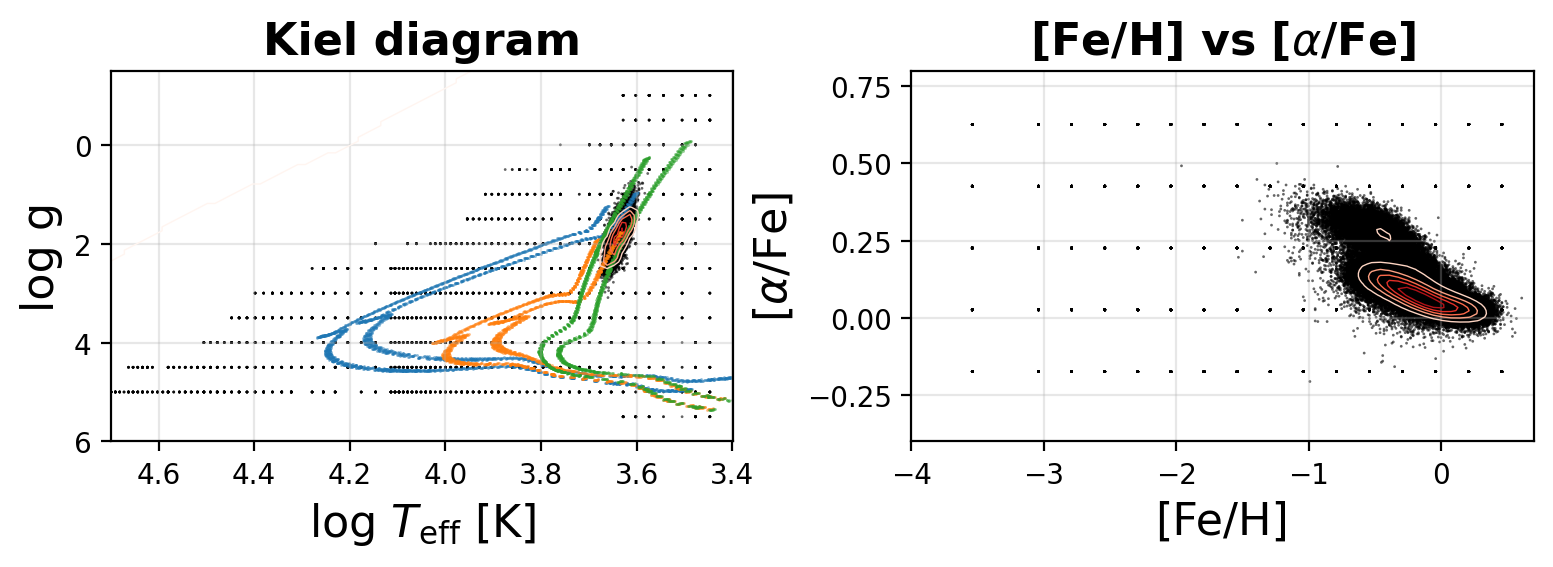

In [9]:
from scipy import stats
from scipy.ndimage import gaussian_filter
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
(ax1, ax2) = axs.flatten()

# Method 1: Gaussian KDE with smooth contours
def plot_kde_contours(ax, x, y, n_levels=4, colors='Reds', alpha=0.6):
    """Plot smooth KDE contours"""
    # Create KDE
    kde = stats.gaussian_kde(np.vstack([x, y]))
    
    # Create grid for evaluation
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    # Extend grid slightly beyond data range
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_grid = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 100)
    y_grid = np.linspace(y_min - 0.1*y_range, y_max + 0.1*y_range, 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Evaluate KDE on grid
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(positions).T.reshape(X.shape)
    
    # Plot contours
    if isinstance(colors, str) and colors.endswith('s'):  # colormap
        contours = ax.contour(X, Y, Z, levels=n_levels, cmap=colors, alpha=alpha, linewidths=0.5)
    else:  # single color or list of colors
        contours = ax.contour(X, Y, Z, levels=n_levels, colors=colors, alpha=alpha, linewidths=0.5)
    
    return contours
# Plot 1: Kiel diagram with KDE contours
log_teff = np.log10(teff_arr)
logg = logg_arr

# Scatter plot with reduced alpha and smaller points
ax1.scatter(log_teff, logg, s=1, alpha=0.6, c='k', edgecolors='none', linewidths=0, rasterized=True)

# Add smooth KDE contours
contours1 = plot_kde_contours(ax1, log_teff, logg, n_levels=5, colors='Reds', alpha=1)

# Styling
ax1.set_xlabel(r'log $T_{\mathrm{eff}}$ [K]', fontsize=16)
ax1.set_ylabel('log g', fontsize=16)
ax1.set_title('Kiel diagram', fontsize=16, fontweight='bold')
ax1.set_ylim(6, -1.5)
ax1.set_xlim(np.log10(50000), np.log10(2500))
ax1.grid(True, alpha=0.3)

# Add isochrones if available
try:
    _, ax1 = plot_isochrones(fig, ax1, isochrones)
except:
    pass

# Plot 2: [Fe/H]-[α/Fe] with multiple contour styles
feh = feh_arr
afe = afe_arr

# Scatter plot with reduced alpha
ax2.scatter(feh, afe, s=1, alpha=0.6, c='k', edgecolors='none', linewidths=0, rasterized=True)

# Method A: KDE contours (outer, smoother)
contours2a = plot_kde_contours(ax2, feh, afe, n_levels=5, colors='Reds', alpha=1)

# Method B: Smoothed histogram contours (inner, more detailed)
# contours2b = plot_smooth_hist_contours(ax2, feh, afe, bins=40, sigma=1.5, n_levels=4, colors='darkred', alpha=0.8)

# Styling
ax2.set_xlabel('[Fe/H]', fontsize=16)
ax2.set_ylabel(r'[$\alpha$/Fe]', fontsize=16)
ax2.set_title(r'[Fe/H] vs [$\alpha$/Fe]', fontsize=16, fontweight='bold')
ax2.set_xlim(-4, 0.7)
ax2.set_ylim(-0.4, 0.8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# fig.savefig("fig/training_set.png")


## bechmark  score
Validation loss: 0.008806  
RHOX loss: 0.001532  
T loss: 0.000493  
P loss: 0.001101  
XNE loss: 0.000757  
ABROSS loss: 0.004680  
ACCRAD loss: 0.000243

In [9]:
# Calculate metrics
metrics = calculate_metrics(predictions, targets)
for param, param_metrics in metrics.items():
    print(f"\n{param} metrics:")

    for metric_name, value in param_metrics.items():
        print(f"{metric_name}: {value:.6f}")


RHOX metrics:
MSE: 0.000004
RMSE: 0.001988
MAE: 0.001276
R²: 0.999925

T metrics:
MSE: 0.000002
RMSE: 0.001390
MAE: 0.000708
R²: 0.999935

P metrics:
MSE: 0.000003
RMSE: 0.001749
MAE: 0.001112
R²: 0.999907

XNE metrics:
MSE: 0.000004
RMSE: 0.001955
MAE: 0.001228
R²: 0.999951

ABROSS metrics:
MSE: 0.000008
RMSE: 0.002772
MAE: 0.001767
R²: 0.999951

ACCRAD metrics:
MSE: 0.000001
RMSE: 0.001149
MAE: 0.000564
R²: 0.999673


In [10]:
target_teff = 5772.0
target_logg = 4.4
target_feh = 0.0
target_afe = 0.0

# Combine dataset parameters into a single tensor (N, 4)
dataset_params = torch.cat([teff_input, logg_input, feh_input, afe_input], dim=1)
target_params = torch.tensor([[target_teff, target_logg, target_feh, target_afe]])

# Calculate the squared Euclidean distance (more efficient than Euclidean distance)
# Broadcasting target_params (1, 4) against dataset_params (N, 4)
distances_sq = torch.sum((dataset_params - target_params)**2, dim=1)

# Find the index of the minimum distance
nearest_index = torch.argmin(distances_sq).item()

# Retrieve the nearest data point parameters
nearest_data_params = dataset_params[nearest_index]

In [11]:
# You can also retrieve the full original data for that index if needed
nearest_full_data = {key: val[nearest_index] for key, val in dataset.original.items()}

print(f"Target parameters: teff={target_teff}, logg={target_logg}, feh={target_feh}, afe={target_afe}")
print(f"Nearest index found: {nearest_index}")
print(f"Nearest data parameters found: teff={nearest_data_params[0].item():.2f}, logg={nearest_data_params[1].item():.2f}, feh={nearest_data_params[2].item():.2f}, afe={nearest_data_params[3].item():.2f}")
# You can access other original data like this:
# nearest_T_profile = dataset.original['T'][nearest_index]
# print(f"Temperature profile (first 5 points): {nearest_T_profile[:5]}")

Target parameters: teff=5772.0, logg=4.4, feh=0.0, afe=0.0
Nearest index found: 4030
Nearest data parameters found: teff=5750.00, logg=4.50, feh=-0.04, afe=-0.17


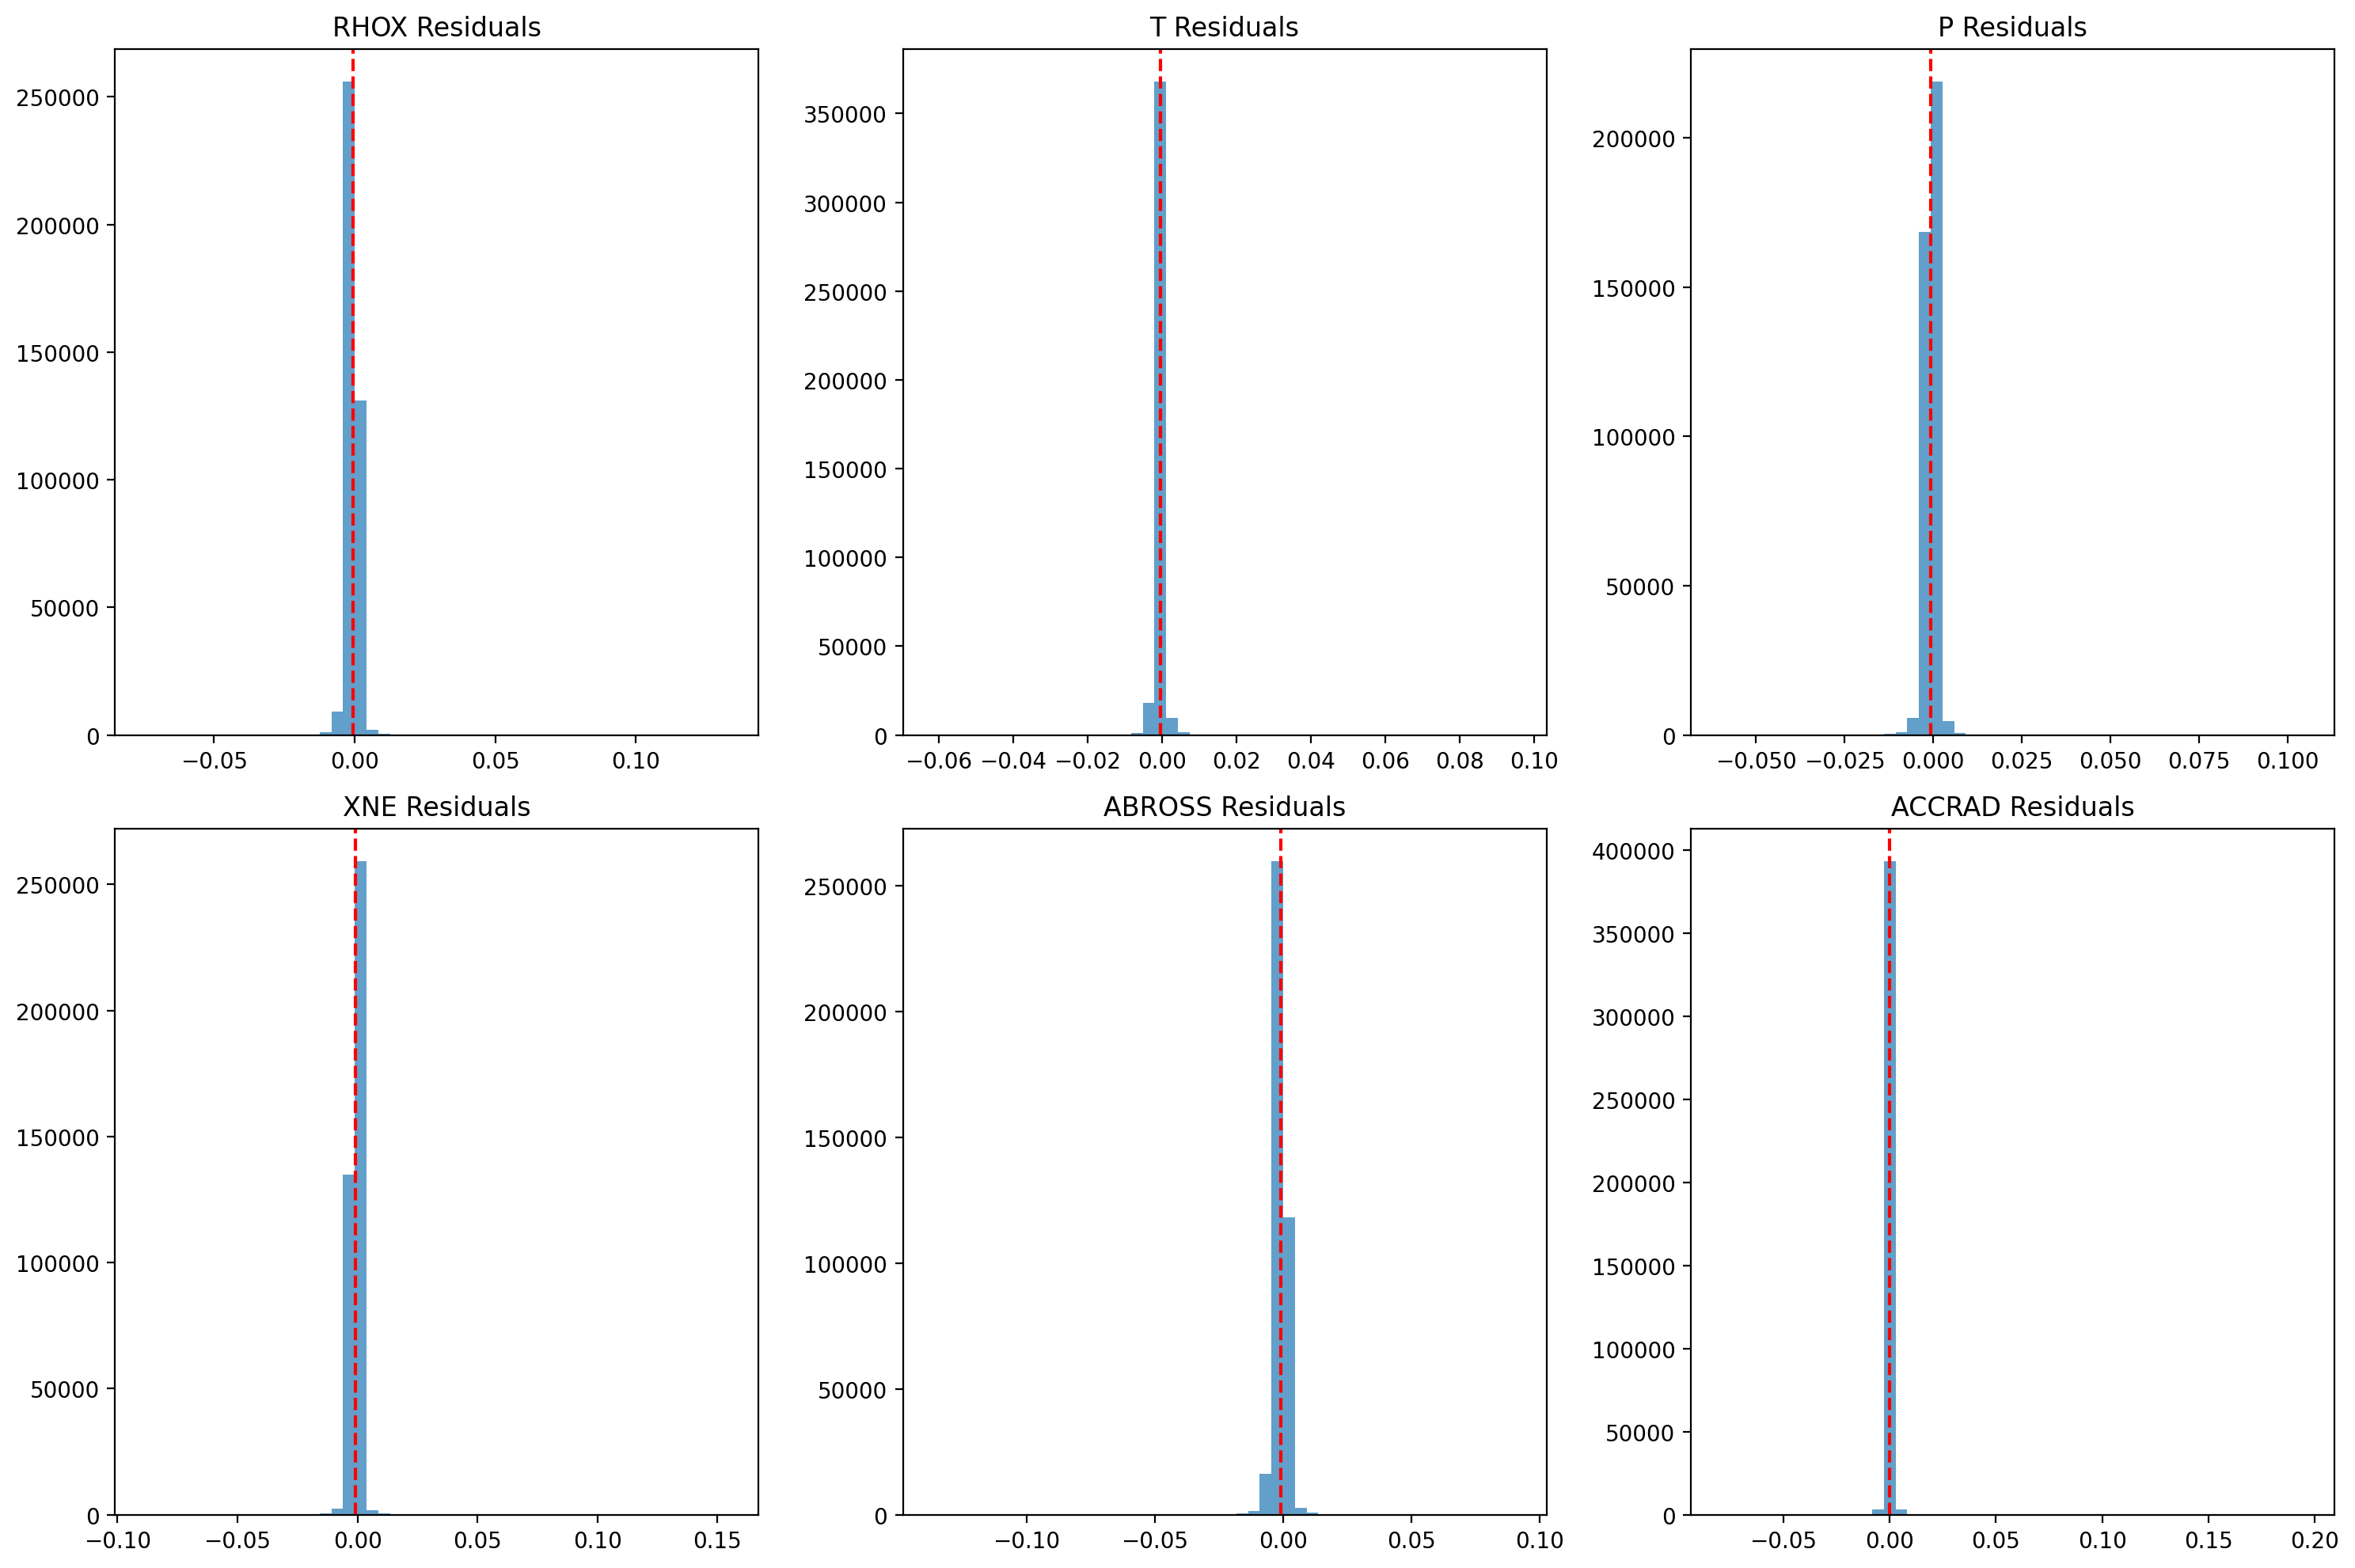

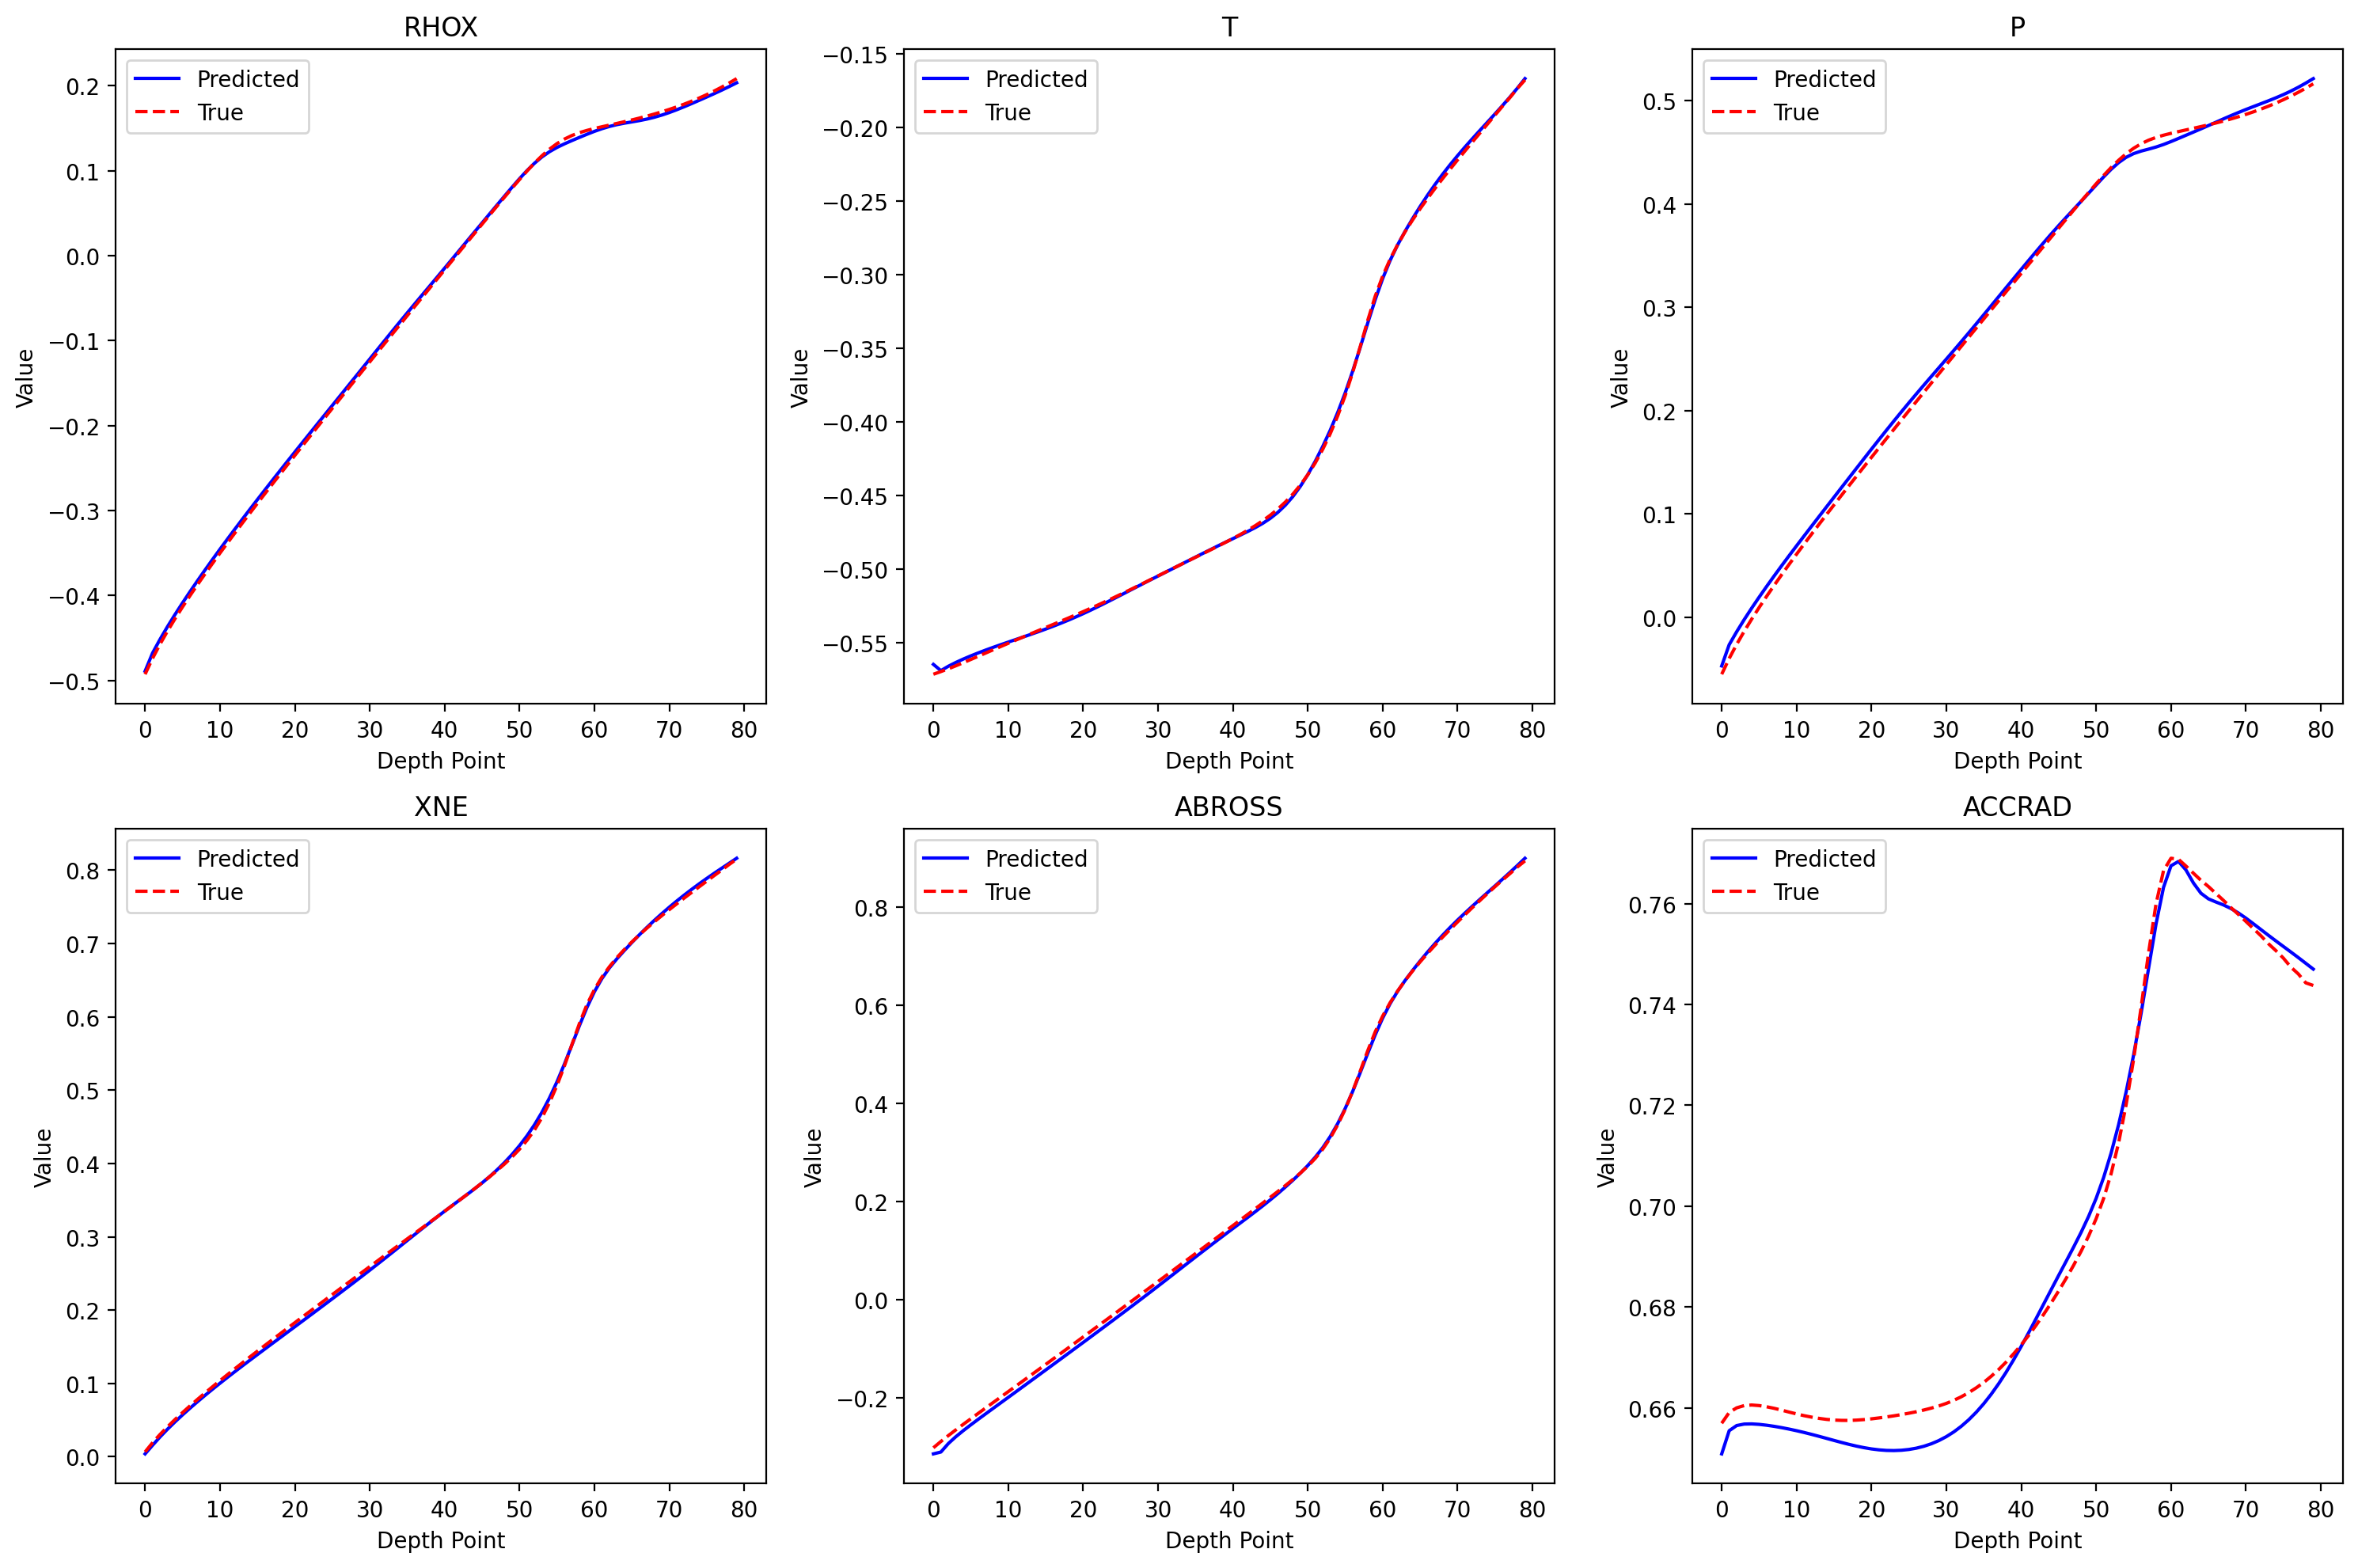

In [13]:
residual_plot = plot_residuals(predictions, targets)

# Plot a few sample profiles
torch.manual_seed(0)

# sample_indices = torch.randperm(predictions.shape[0])[:2]
sample_indices = torch.tensor([4030])
# 5370
for idx in sample_indices:
    print()
    profile_plot = plot_depth_profile(idx, predictions, targets)

# all residuals from the validation data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmasher as cmr

# Create figure and subplots

# Get TAU values
tau_lin = dataset.denormalize('TAU', dataset.TAU)[0].numpy()

# Epsilon is still useful for numerical stability
epsilon = 1e-10
# Force TAU positive before potentially taking log later
tau_lin = np.maximum(tau_lin, epsilon)

# Get denormalized predictions and targets
rhox_target = dataset.denormalize('RHOX', targets[:,:,0]).numpy()
rhox_pred = dataset.denormalize('RHOX', predictions[:,:,0]).numpy()
T_target = dataset.denormalize('T', targets[:,:,1]).numpy()
T_pred = dataset.denormalize('T', predictions[:,:,1]).numpy()
P_target = dataset.denormalize('P', targets[:,:,2]).numpy()
P_pred = dataset.denormalize('P', predictions[:,:,2]).numpy()
XNE_target = dataset.denormalize('XNE', targets[:,:,3]).numpy()
XNE_pred = dataset.denormalize('XNE', predictions[:,:,3]).numpy()
kappa_target = dataset.denormalize('ABROSS', targets[:,:,4]).numpy()
kappa_pred = dataset.denormalize('ABROSS', predictions[:,:,4]).numpy()
ACCRAD_target = dataset.denormalize('ACCRAD', targets[:,:,5]).numpy()
ACCRAD_pred = dataset.denormalize('ACCRAD', predictions[:,:,5]).numpy()


In [16]:
# plot use /Users/jdli/Project/haloimf/benxi.mplstyle
plt.style.use('/Users/jdli/Project/haloimf/benxi.mplstyle')

In [ ]:
# Set Arial font for all text
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

fig, axs = plt.subplots(1, 4, figsize=(14, 3))  # Increased figure width slightly

# Define specific y-limits for relative errors (in percentage)
param_ylims = {
    'RHOX': (-20, 20),     # -100% to +100%
    'T': (-20, 20),          # -50% to +50%
    'P': (-20, 20),        # -100% to +100%
    'ABROSS': (-20, 20)    # -100% to +100%
}

# Parameters to plot
params = [
    {'name': 'RHOX', 'target': rhox_target, 'pred': rhox_pred, 'pos': (0,0)},
    {'name': 'T', 'target': T_target, 'pred': T_pred, 'pos': (0,1)},
    {'name': 'P', 'target': P_target, 'pred': P_pred, 'pos': (1,0)},
    {'name': 'ABROSS', 'target': kappa_target, 'pred': kappa_pred, 'pos': (1,1)}
]

# Store mesh objects for colorbar
mesh_objects = []

# Plot each parameter
for i, param in enumerate(params):
    row, col = param['pos']
    ax = axs[i]  # Use flat indexing since we have 1 row
    param_name = param['name']
    ymin, ymax = param_ylims[param_name]

    # Calculate relative errors (in percentage)
    # Avoid division by zero or near-zero values
    target_safe = np.maximum(np.abs(param['target']), epsilon)
    # Use the sign of the original target for the safe value
    target_safe = np.where(param['target'] != 0, param['target'], target_safe * np.sign(param['target']))
    
    # Calculate relative error: (target - pred) / target * 100
    relative_errors = (param['target'] - param['pred']) / target_safe * 100

    # Flatten data
    if relative_errors.ndim > 1 and tau_lin.ndim == 1:
        num_batches = relative_errors.shape[0]
        all_tau = np.tile(tau_lin, num_batches)
    else:
        all_tau = np.repeat(tau_lin, relative_errors.size // tau_lin.size if tau_lin.size > 0 else 0)

    all_rel_errors = relative_errors.flatten()

    # Filter out NaN/inf values
    valid_mask_finite = np.isfinite(all_tau) & np.isfinite(all_rel_errors)
    all_tau_finite = all_tau[valid_mask_finite]
    all_rel_errors_finite = all_rel_errors[valid_mask_finite]

    # Apply Y-Limit Filtering
    valid_mask_ylim = (all_rel_errors_finite >= ymin) & (all_rel_errors_finite <= ymax)
    all_tau_filtered_y = all_tau_finite[valid_mask_ylim]
    all_rel_errors_valid_y = all_rel_errors_finite[valid_mask_ylim]

    # Calculate Log10(TAU) after Y filtering
    all_tau_filtered_y_positive = np.maximum(all_tau_filtered_y, epsilon)
    log_tau_intermediate = np.log10(all_tau_filtered_y_positive)

    # Apply X-Limit (log10(TAU) > -8) Filtering
    valid_mask_xlim = log_tau_intermediate > -8
    log_tau_valid = log_tau_intermediate[valid_mask_xlim]
    all_rel_errors_valid = all_rel_errors_valid_y[valid_mask_xlim]

    # Print median value of the relative errors
    print(f"Median {param_name} relative error: {np.median(np.abs(all_rel_errors_valid)):.2f}%")

    # Ensure there is data to plot after filtering
    if log_tau_valid.size == 0 or all_rel_errors_valid.size == 0:
        ax.text(0.5, 0.5, 'No valid data in specified range', horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)
        ax.set_title(param_name)
        ax.set_xlabel('log10(TAU) > -8')
        ax.set_ylabel('(pred - true)/true (%)')
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(left=-8)
        mesh_objects.append(None)
        continue

    # Define bins for the histogram
    bins = 100
    ybins = np.linspace(ymin, ymax, bins + 1)
    xbins_min = max(-8, log_tau_valid.min())
    xbins = np.linspace(xbins_min, log_tau_valid.max(), 20)

    # Calculate the count of points in each bin
    counts, xedges, yedges = np.histogram2d(
        log_tau_valid, all_rel_errors_valid,
        bins=[xbins, ybins]
    )
    counts_positive = np.maximum(counts, epsilon)  # For LogNorm

    # Create mesh grid for pcolormesh
    X, Y = np.meshgrid(xedges, yedges)

    # Set color normalization to LogNorm based on counts
    norm = colors.Normalize(vmin=0.1, vmax=counts_positive.max())
    # norm = colors.LogNorm(vmin=1, vmax=counts_positive.max())

    # Plot using pcolormesh, coloring by counts
    mesh = ax.pcolormesh(X, Y, counts.T,
                         cmap='bone_r',  # Use a perceptually uniform colormap
                         norm=norm,
                         rasterized=True)
    
    # Store mesh object for colorbar
    mesh_objects.append(mesh)

    # Set scales and limits
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(left=-7, right=xedges[-1])

    # Add horizontal reference lines
    if ymin <= 0 <= ymax:
        ax.axhline(0, color='white', linestyle='--', linewidth=2)
        ax.axhline(2,  color='C1', linestyle=':', linewidth=2)
        ax.axhline(-2, color='C1', linestyle=':', linewidth=2)  

    # Set labels and title
    ax.set_title(param_name)
    ax.set_xlabel(r'$\log_{10}$ ($\tau$)')

    if i == 0:
        ax.set_ylabel('Relative Error (%)')

# Add colorbar to the right of all subplots, without affecting subplot widths
if any(mesh is not None for mesh in mesh_objects):
    # Find the first valid mesh object for the colorbar
    valid_mesh = next(mesh for mesh in mesh_objects if mesh is not None)
    
    # Create colorbar with proper positioning
    cb = fig.colorbar(valid_mesh, ax=axs, shrink=0.8, aspect=20, pad=0.02)
    cb.set_label('Counts', rotation=270, labelpad=15)

# plt.tight_layout()
plt.show()

fig.savefig("fig/tau_relative_errors_hydro.pdf", bbox_inches='tight', dpi=300)

Median RHOX relative error: 1.32%
Median T relative error: 0.12%


In [27]:
# target_back = np.concatn((rhox_target, T_target, P_target, kappa_target), axis = 1)
target_back = np.c_[rhox_target.reshape(-1, 80, 1), T_target.reshape(-1, 80, 1), P_target.reshape(-1, 80, 1), 
                    XNE_target.reshape(-1, 80, 1), kappa_target.reshape(-1, 80, 1), ACCRAD_target.reshape(-1, 80, 1)]
pred_back = np.c_[rhox_pred.reshape(-1, 80, 1), T_pred.reshape(-1, 80, 1), P_pred.reshape(-1, 80, 1), 
                    XNE_pred.reshape(-1, 80, 1), kappa_pred.reshape(-1, 80, 1), ACCRAD_pred.reshape(-1, 80, 1)]


In [28]:
# Plot sample depth profiles
def plot_depth_profile(fig, axs, idx, predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    
    # Create a figure and a set of subplots (2 rows, 3 columns)
    # fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # Adjusted figsize for better layout
    axs = axs.flatten() # Flatten the 2x3 grid into a 1D array for easy iteration

    for i, param in enumerate(param_names):
        ax = axs[i] # Get the current axis
        
        pred_values = predictions[idx, :, i]
        true_values = targets[idx, :, i]
        depth_points = np.arange(len(pred_values))
        
        # Use the ax object for plotting
        ax.plot(depth_points, pred_values, lw=3, ls='-',  color='tab:blue', label='Kurucz-a1')
        ax.plot(depth_points, true_values, lw=3, ls='--', color='tab:orange', label='ATLAS-12')
        
        ax.set_title(f'{param}')
        ax.set_xlabel('Depth Point')
        ax.set_ylabel('Value')

    if i==0:
        ax.legend()
    
    # Adjust layout to prevent overlapping titles/labels
    fig.tight_layout() 
    
    # Return the figure and axes array
    return fig, axs

In [29]:
target_teff = 4500.0
target_logg = 2.5
target_feh = 0.0
target_afe = 0.0

# Combine dataset parameters into a single tensor (N, 4)
dataset_params = torch.cat([teff_input, logg_input, feh_input, afe_input], dim=1)
target_params = torch.tensor([[target_teff, target_logg, target_feh, target_afe]])

# Calculate the squared Euclidean distance (more efficient than Euclidean distance)
# Broadcasting target_params (1, 4) against dataset_params (N, 4)
distances_sq = torch.sum((dataset_params - target_params)**2, dim=1)

# Find the index of the minimum distance
nearest_index = torch.argmin(distances_sq).item()

# Retrieve the nearest data point parameters
nearest_data_params = dataset_params[nearest_index]

tensor([ 4.5000e+03,  2.5000e+00, -4.0000e-02,  2.6000e-02])


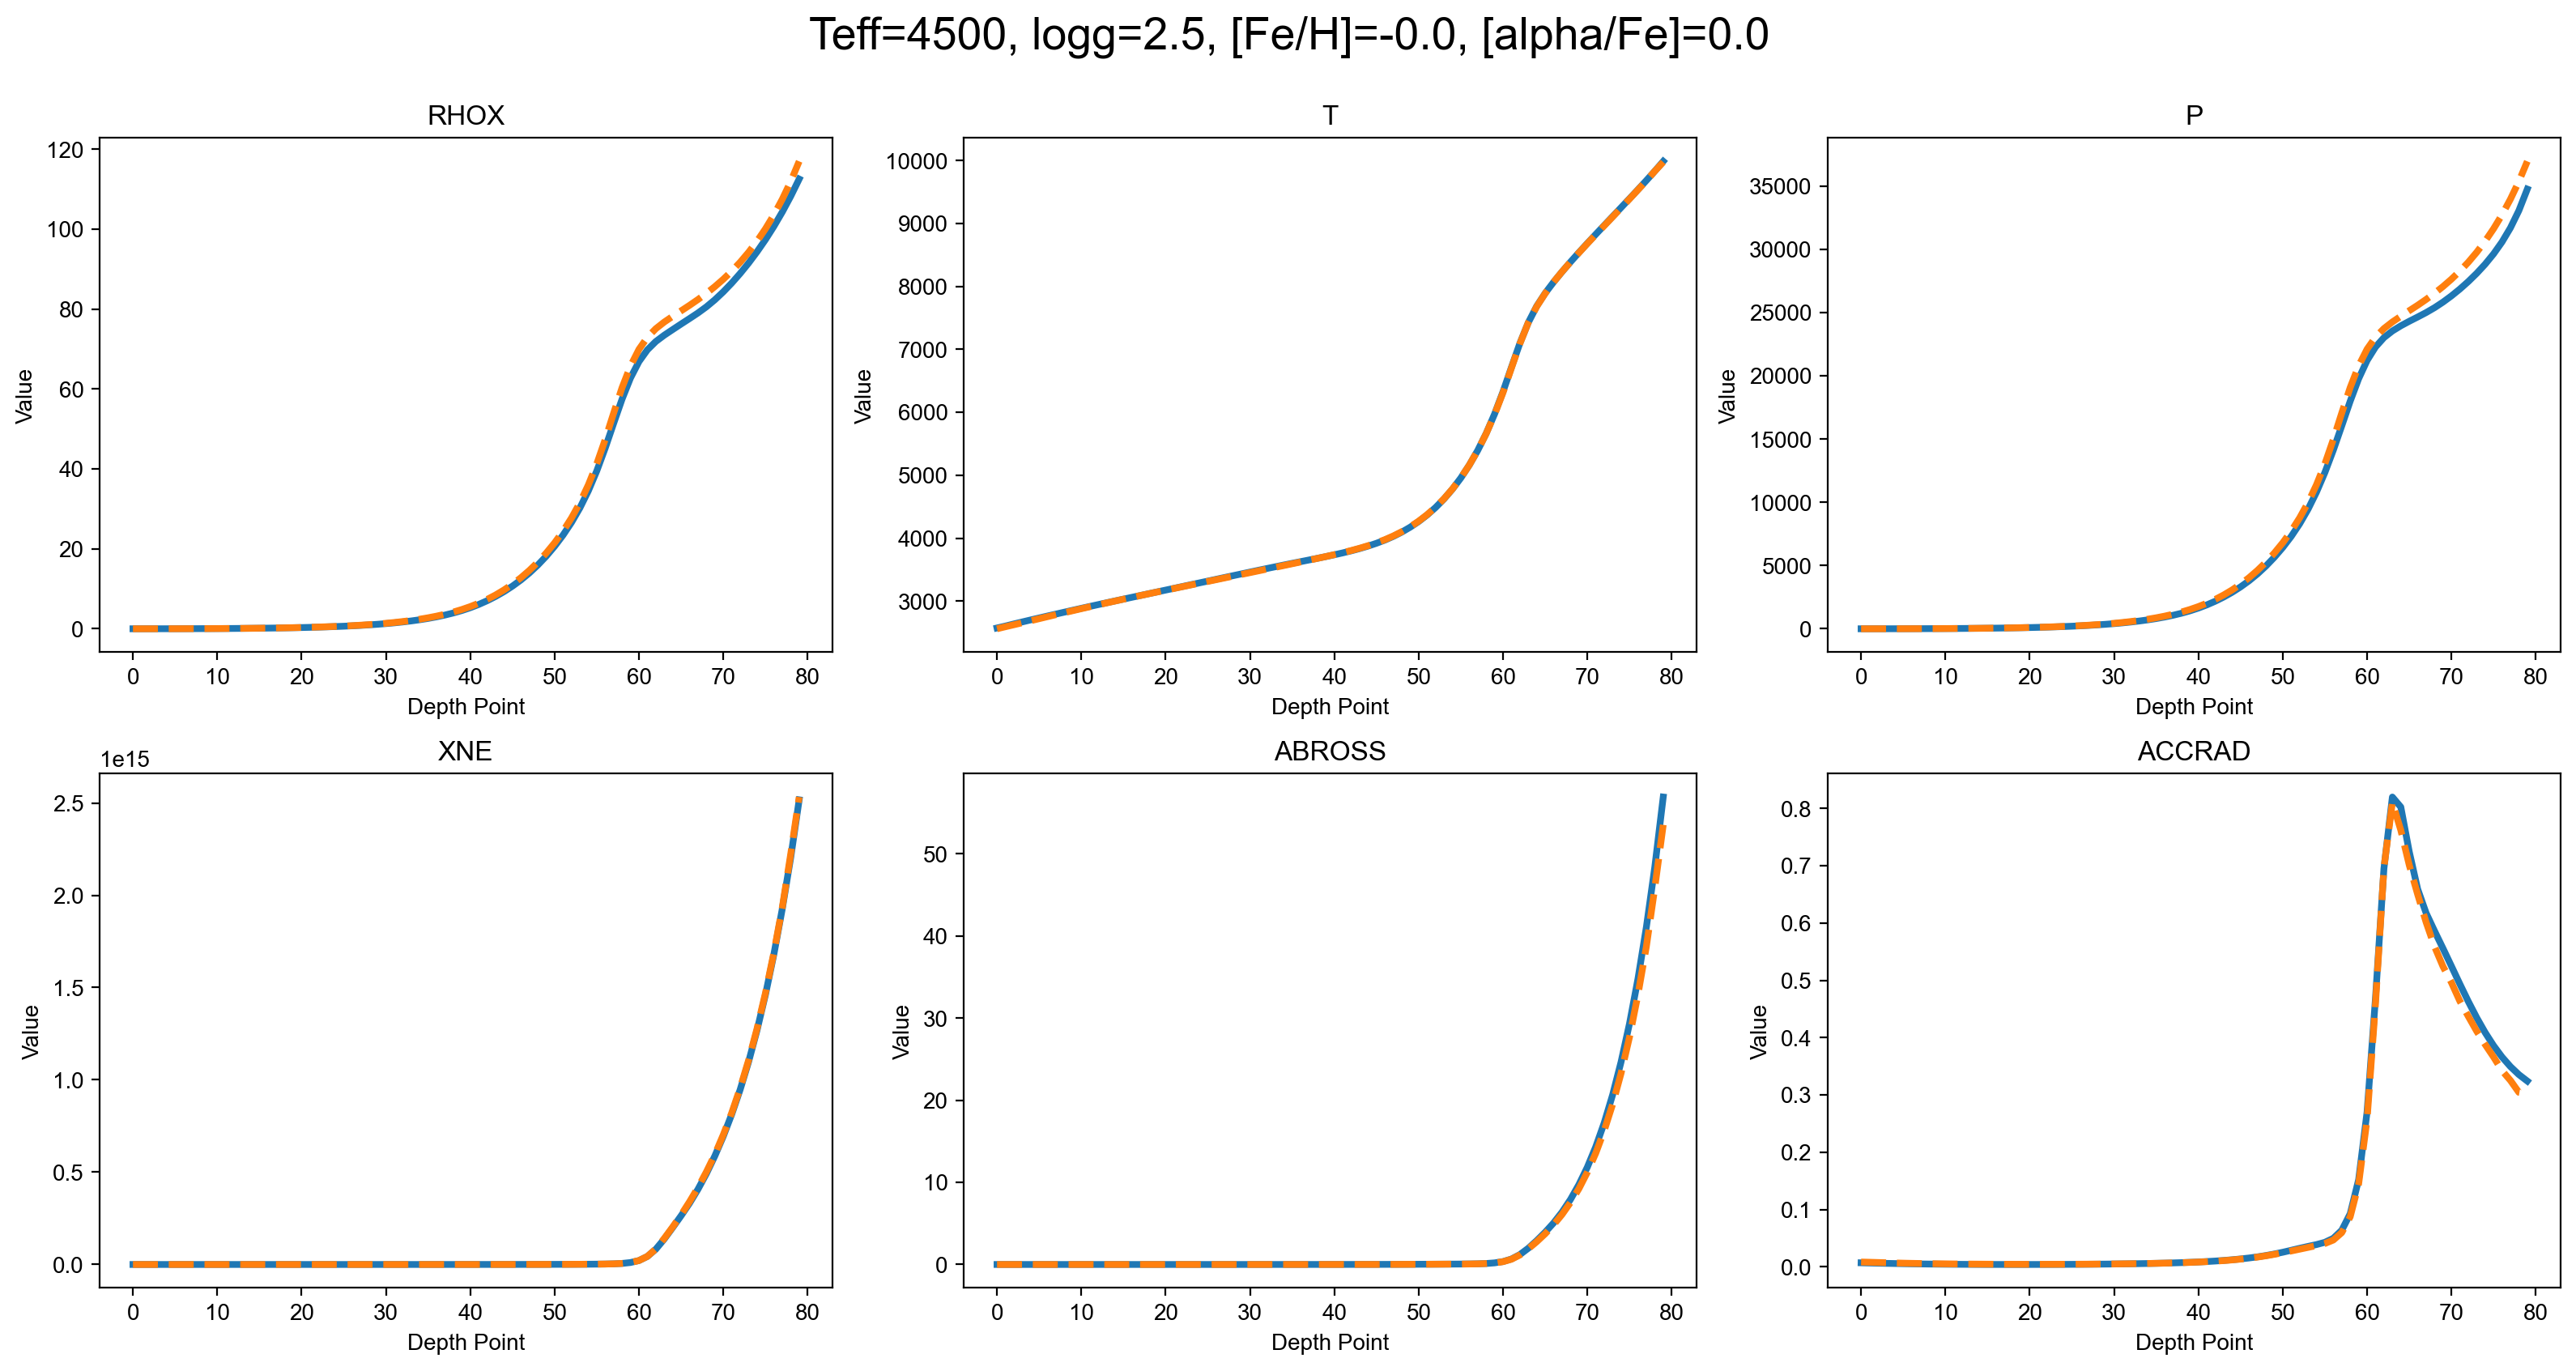

In [30]:
idx = nearest_index
fig, axes = plt.subplots(2, 3, figsize=(16, 8)) 
profile_plot = plot_depth_profile(fig, axes, idx, pred_back, target_back)
print(dataset_params[idx])
fig.suptitle(f"Teff={dataset_params[idx][0]:.0f}, logg={dataset_params[idx][1]:.1f}, [Fe/H]={dataset_params[idx][2]:.1f}, [alpha/Fe]={dataset_params[idx][3]:.1f}",
 y=1.05, fontsize=20);
# fig.savefig("/Users/jdli/Project/kurucz1/fig/predict_profile_rgkb.pdf")

# load MLP-base line

In [31]:
def load_mlp_model(model_path, device):

    model = AtmosphereNetMLPtau(
            stellar_embed_dim=128, tau_embed_dim=64
            ).to(device)   
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint['epoch'], checkpoint['loss']


model_mlp_path = "checkpoints_v0531mlp/final_model.pt"
# Load dataset and model

hidden_size = 512
model_mlp, epoch, train_loss = load_mlp_model(
    model_mlp_path,  device
)


/var/folders/9x/hr77dpxn3rg_yz8dnk3q7ny97p30wx/T/ipykernel_79056/665245247.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locati

In [36]:
val_loss_mlp, param_losses, inputs, predictions_mlp, targets_mlp = validate_model(model_mlp, val_loader, device)


In [37]:
# Get denormalized predictions and targets
rhox_target = dataset.denormalize('RHOX', targets_mlp[:,:,0]).numpy()
rhox_pred = dataset.denormalize('RHOX', predictions_mlp[:,:,0]).numpy()

T_target = dataset.denormalize('T', targets_mlp[:,:,1]).numpy()
T_pred = dataset.denormalize('T', predictions_mlp[:,:,1]).numpy()

P_target = dataset.denormalize('P', targets_mlp[:,:,2]).numpy()
P_pred = dataset.denormalize('P', predictions_mlp[:,:,2]).numpy()

XNE_target = dataset.denormalize('XNE', targets_mlp[:,:,3]).numpy()
XNE_pred = dataset.denormalize('XNE', predictions_mlp[:,:,3]).numpy()

kappa_target = dataset.denormalize('ABROSS', targets_mlp[:,:,4]).numpy()
kappa_pred = dataset.denormalize('ABROSS', predictions_mlp[:,:,4]).numpy()

ACCRAD_target = dataset.denormalize('ACCRAD', targets_mlp[:,:,5]).numpy()
ACCRAD_pred = dataset.denormalize('ACCRAD', predictions_mlp[:,:,5]).numpy()

pred_back_mlp = np.stack((rhox_pred, T_pred, P_pred, XNE_pred, kappa_pred, ACCRAD_pred), axis=-1)
target_back_mlp = np.stack((rhox_target, T_target, P_target, XNE_target, kappa_target, ACCRAD_target), axis=-1)

tensor([ 4.5000e+03,  2.5000e+00, -4.0000e-02,  2.6000e-02])


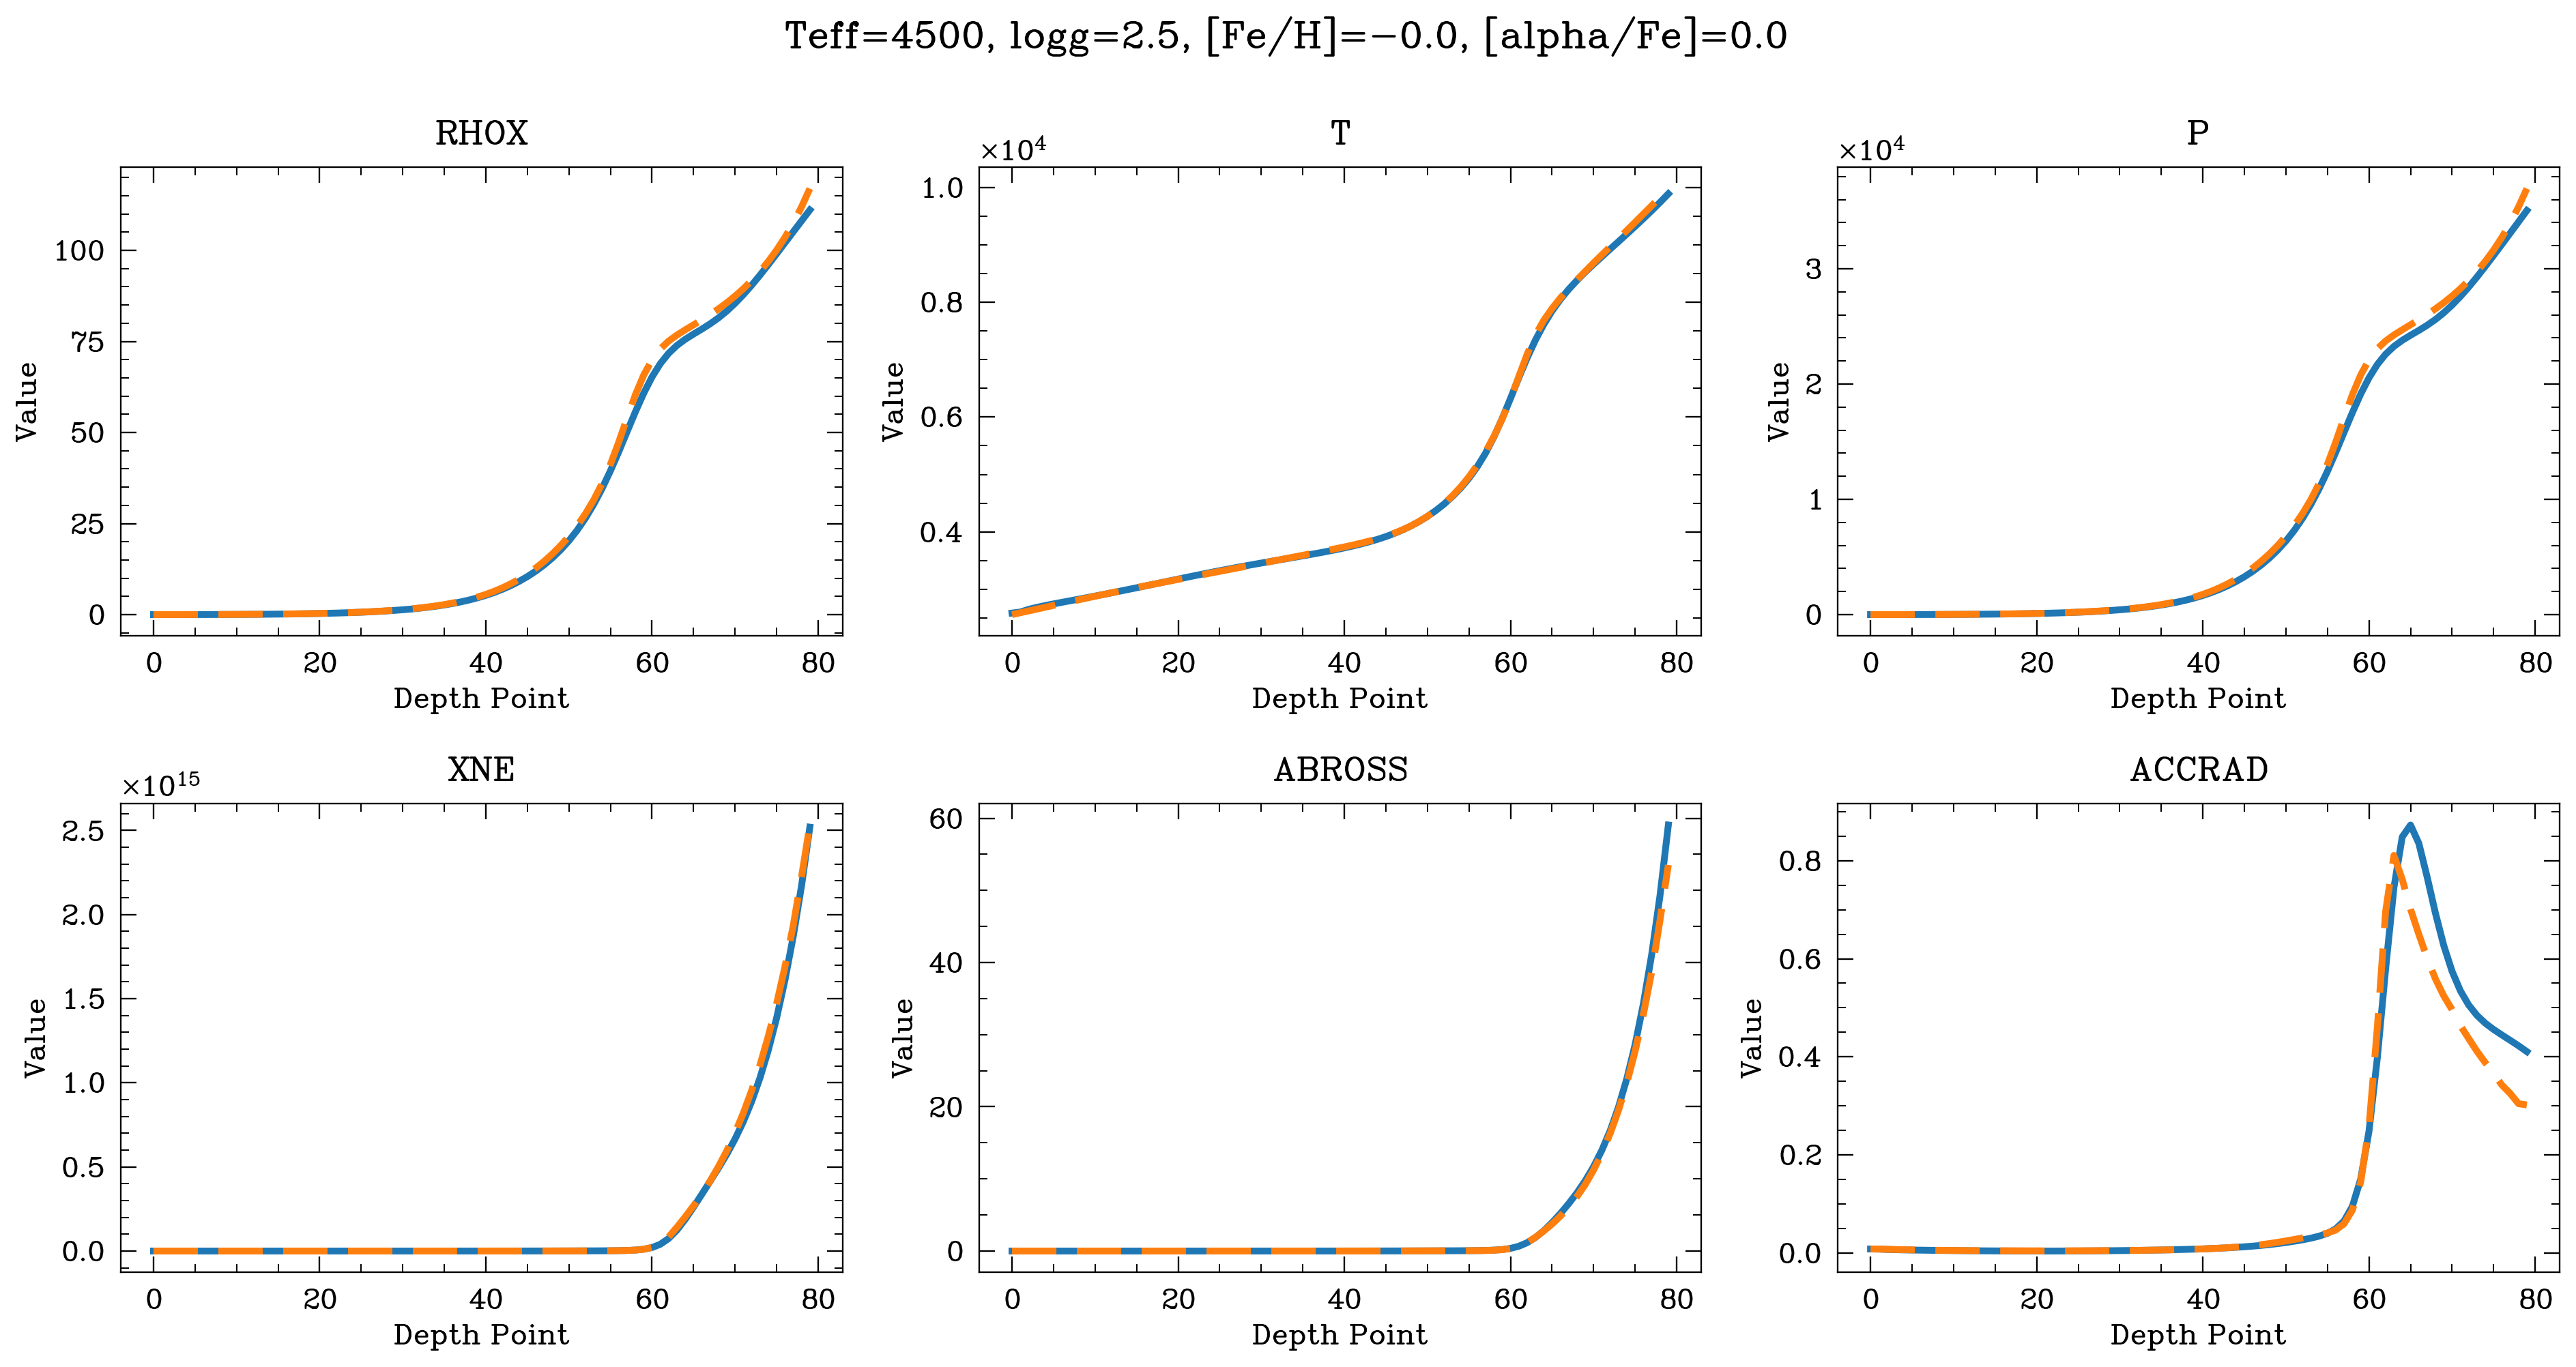

In [73]:
idx = nearest_index
fig, axes = plt.subplots(2, 3, figsize=(16, 8)) 
profile_plot = plot_depth_profile(fig, axes, idx, pred_back_mlp, target_back_mlp)
print(dataset_params[idx])
fig.suptitle(f"Teff={dataset_params[idx][0]:.0f}, logg={dataset_params[idx][1]:.1f}, [Fe/H]={dataset_params[idx][2]:.1f}, [alpha/Fe]={dataset_params[idx][3]:.1f}",
 y=1.05, fontsize=20);
# fig.savefig("/Users/jdli/Project/kurucz1/fig/predict_profile_rgkb.pdf")

In [33]:
from utils import calculate_dP_dtau_ground_truth, calculate_dP_dtau_predicted
# Calculate dP/dtau for the first 10 samples
dP_dtau_ground_truth = calculate_dP_dtau_ground_truth(dataset, sample_indices=[nearest_index])
dP_dtau_predicted = calculate_dP_dtau_predicted(model, dataset, sample_indices=[nearest_index])
dP_dtau_predicted_mlp = calculate_dP_dtau_predicted(model_mlp, dataset, sample_indices=[nearest_index])

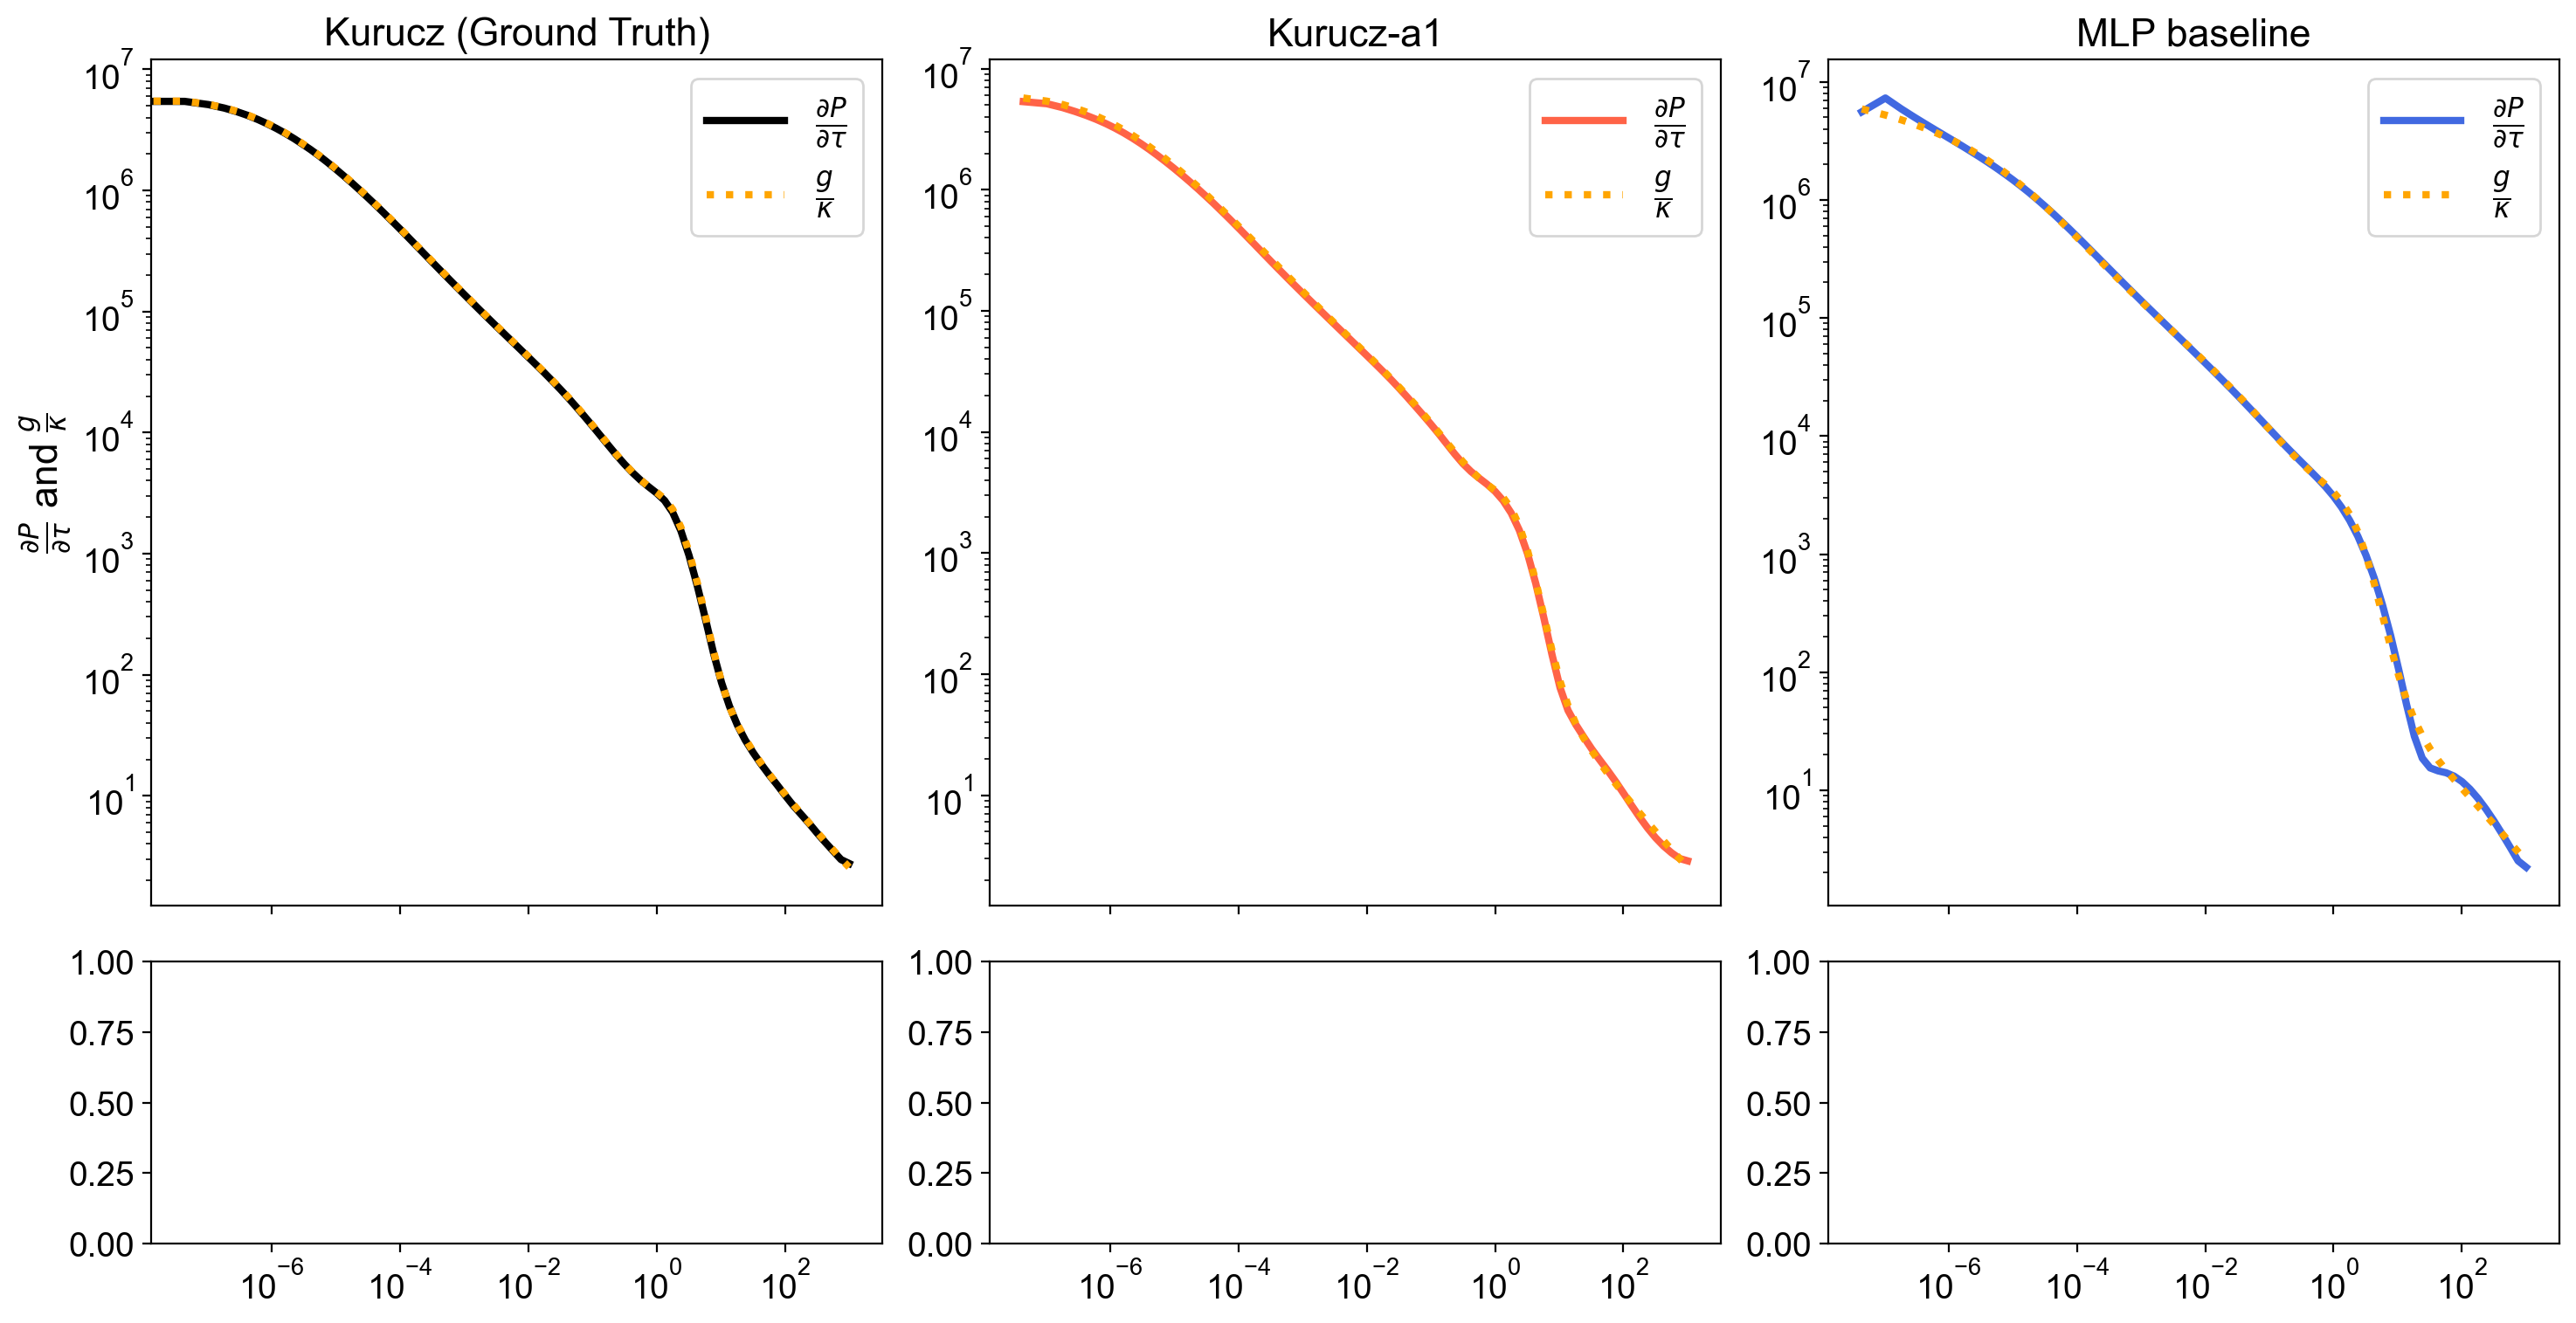

In [34]:
idx_plot = 0
# Get stellar parameters for the title
Teff = dP_dtau_ground_truth['teff'][idx_plot]
logg = np.log10(dP_dtau_ground_truth['gravity'][idx_plot])
FeH = dP_dtau_ground_truth['feh'][idx_plot]
alphaFe = dP_dtau_ground_truth['afe'][idx_plot]

# Set larger font size
plt.rcParams.update({'font.size': 14})

# Plotting with 2 rows (main plots and residuals)
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex='col', 
                        gridspec_kw={'height_ratios': [3, 1]})

# Panel 1: Ground Truth (Kurucz)
axs[0, 0].plot(dP_dtau_ground_truth['tau'][idx_plot], 
              dP_dtau_ground_truth['dP_dtau'][idx_plot], 
              label=r'$\frac{\partial P}{\partial \tau}$', color='black', linewidth=3)
axs[0, 0].plot(dP_dtau_ground_truth['tau'][idx_plot], 
              dP_dtau_ground_truth['g_kappa'][idx_plot], 
              label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
axs[0, 0].set_title('Kurucz (Ground Truth)', fontsize=16)
axs[0, 0].set_ylabel(r'$\frac{\partial P}{\partial \tau}$ and $\frac{g}{\kappa}$', fontsize=16)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].legend(fontsize=16)

start_point = 1

# Panel 2: MLP Baseline
axs[0, 1].plot(dP_dtau_predicted['tau'][idx_plot][start_point:], 
              dP_dtau_predicted['dP_dtau_pred'][idx_plot][start_point:],
              label=r'$\frac{\partial P}{\partial \tau}$', color='tomato', linewidth=3)
axs[0, 1].plot(dP_dtau_predicted['tau'][idx_plot][start_point:], 
              dP_dtau_predicted['g_kappa_pred'][idx_plot][start_point:], 
              label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
axs[0, 1].set_title('Kurucz-a1', fontsize=16)
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].legend(fontsize=16)

# Panel 3: PINN (hydro)
axs[0, 2].plot(dP_dtau_predicted_mlp['tau'][idx_plot][start_point:], 
              dP_dtau_predicted_mlp['dP_dtau_pred'][idx_plot][start_point:], 
              label=r'$\frac{\partial P}{\partial \tau}$', color='royalblue', linewidth=3)
axs[0, 2].plot(dP_dtau_predicted_mlp['tau'][idx_plot][start_point:], 
              dP_dtau_predicted_mlp['g_kappa_pred'][idx_plot][start_point:], 
              label=r'$\frac{g}{\kappa}$', color='orange', linestyle=':', linewidth=3)
axs[0, 2].set_title('MLP baseline', fontsize=16)
axs[0, 2].set_xscale('log')
axs[0, 2].set_yscale('log')
axs[0, 2].legend(fontsize=16)


plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

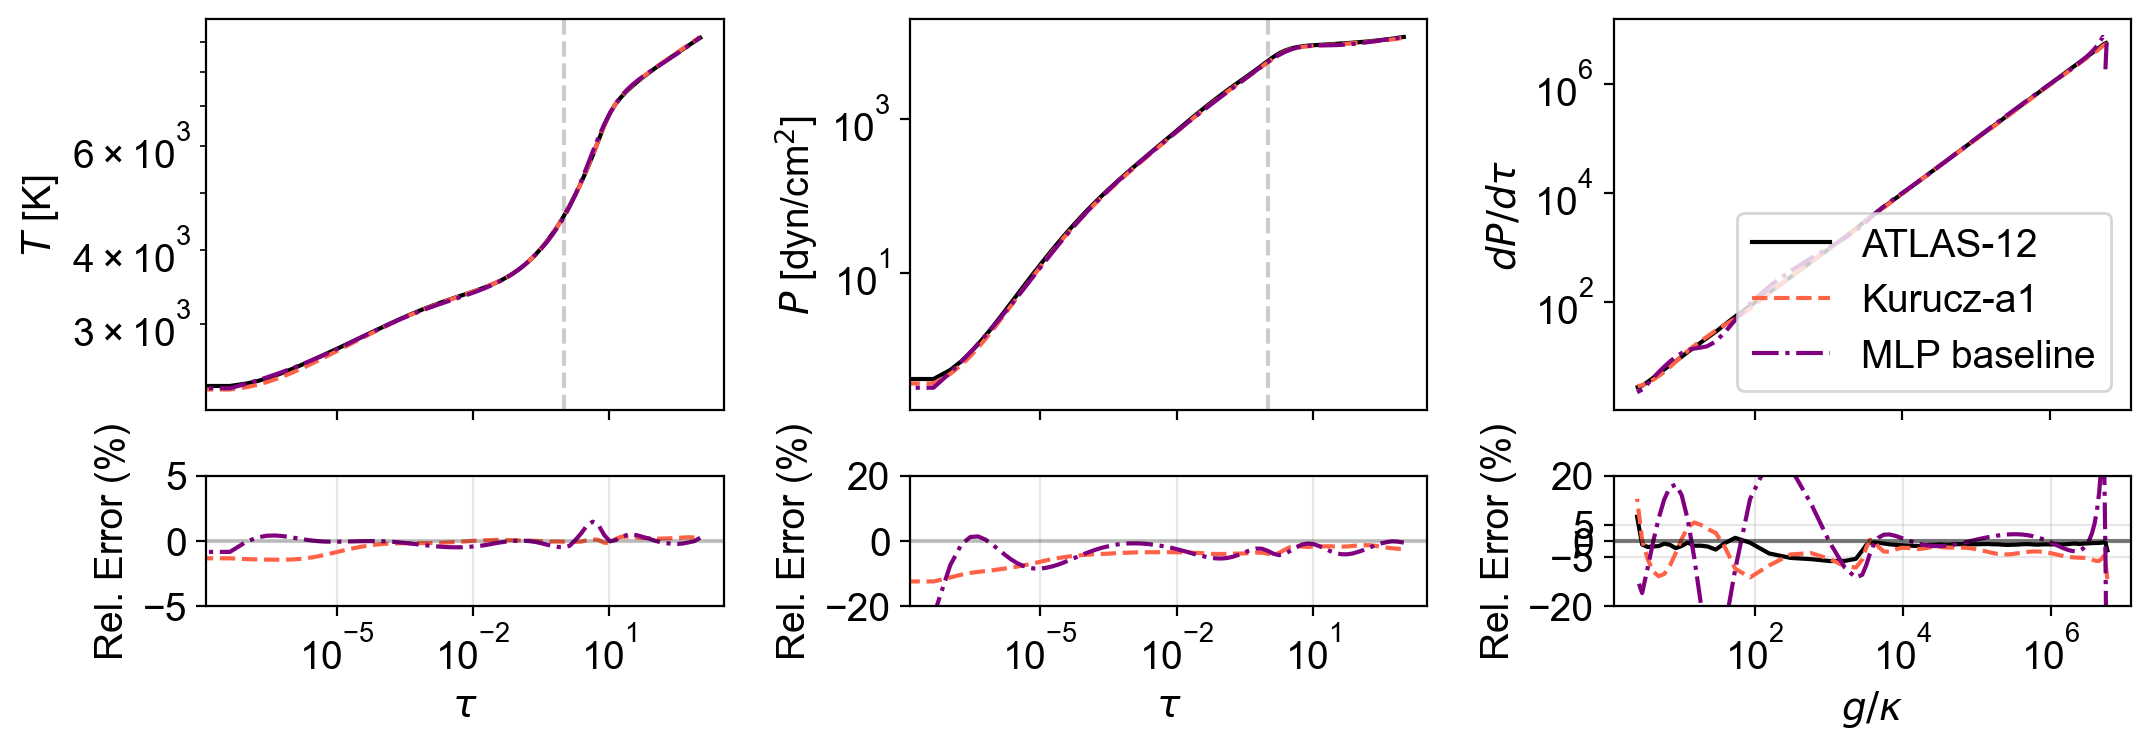

In [38]:
from matplotlib.ticker import FormatStrFormatter, FuncFormatter, LogFormatterMathtext
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(11, 4), height_ratios=[3, 1])

# Top row - original plots
ax1, ax2, ax3 = axs[0]
# Bottom row - relative error plots
ax1_err, ax2_err, ax3_err = axs[1]

# Original plots (top row)
# Plot T vs tau
ax1.plot(dP_dtau_ground_truth['tau'][idx_plot], target_back[idx_plot, :, 1], c='k', linestyle='-',
            label='ATLAS-12')
ax1.plot(dP_dtau_ground_truth['tau'][idx_plot], pred_back[idx_plot, :, 1], c='tomato', linestyle='--',
            label='Kurucz-a1')
ax1.plot(dP_dtau_ground_truth['tau'][idx_plot], pred_back_mlp[idx_plot, :, 1], c='purple', linestyle='-.',
            label='MLP baseline')
ax1.set_ylabel(r'$T$ [K]')
ax1.set(xscale='log', yscale='log')
ax1.axvline(x=1, color='k', linestyle='--', alpha=0.2)
# annotate the optical surface
# ax1.legend()
ax1.tick_params(labelbottom=False)  # Remove x-axis labels for top row

# Plot P vs tau
ax2.plot(dP_dtau_ground_truth['tau'][idx_plot], target_back[idx_plot, :, 2], c='k', linestyle='-',
            label='ATLAS-12')
ax2.plot(dP_dtau_ground_truth['tau'][idx_plot], pred_back[idx_plot, :, 2], c='tomato', linestyle='--',
            label='Kurucz-a1')
ax2.plot(dP_dtau_ground_truth['tau'][idx_plot], pred_back_mlp[idx_plot, :, 2], c='purple', linestyle='-.',
            label='MLP baseline')
ax2.set_ylabel(r'$P$ [dyn/cm$^2$]')
ax2.axvline(x=1, color='k', linestyle='--', alpha=0.2)


ax2.set(xscale='log', yscale='log')
# ax2.legend()
ax2.tick_params(labelbottom=False)  # Remove x-axis labels for top row

# Plot dP/dtau vs g/kappa
ax3.plot(dP_dtau_ground_truth['g_kappa'][idx_plot], dP_dtau_ground_truth['dP_dtau'][idx_plot], c='k', linestyle='-',
            label='ATLAS-12')
ax3.plot(dP_dtau_predicted['g_kappa_pred'][idx_plot], dP_dtau_predicted['dP_dtau_pred'][idx_plot], c='tomato', linestyle='--',
            label='Kurucz-a1')
ax3.plot(dP_dtau_predicted_mlp['g_kappa_pred'][idx_plot], dP_dtau_predicted_mlp['dP_dtau_pred'][idx_plot], c='purple', linestyle='-.',
            label='MLP baseline')
ax3.set_ylabel(r'$dP/d\tau$')
ax3.set(xscale='log', yscale='log')
ax3.legend()
ax3.tick_params(labelbottom=False)  # Remove x-axis labels for top row

# Apply formatters to top plots
# For ax1: use LogFormatterMathtext for scientific notation
ax1.yaxis.set_major_formatter(LogFormatterMathtext())
ax1.xaxis.set_major_formatter(LogFormatterMathtext())

# For ax2: use LogFormatterMathtext for scientific notation
ax2.yaxis.set_major_formatter(LogFormatterMathtext())
ax2.xaxis.set_major_formatter(LogFormatterMathtext())

# For ax3: use LogFormatterMathtext for scientific notation
ax3.xaxis.set_major_formatter(LogFormatterMathtext())
ax3.yaxis.set_major_formatter(LogFormatterMathtext())

# Relative error plots (bottom row)
# Calculate relative errors for T
rel_err_T_kurucz = (pred_back[idx_plot, :, 1] - target_back[idx_plot, :, 1]) / target_back[idx_plot, :, 1] * 100
rel_err_T_mlp = (pred_back_mlp[idx_plot, :, 1] - target_back[idx_plot, :, 1]) / target_back[idx_plot, :, 1] * 100

ax1_err.plot(dP_dtau_ground_truth['tau'][idx_plot], rel_err_T_kurucz, c='tomato', linestyle='--', label='Kurucz-a1')
ax1_err.plot(dP_dtau_ground_truth['tau'][idx_plot], rel_err_T_mlp, c='purple', linestyle='-.', label='MLP baseline')
ax1_err.axhline(y=0, color='k', linestyle='-', alpha=0.2)
ax1_err.set_xlabel(r'$\tau$')
ax1_err.set_ylabel('Rel. Error (%)')
ax1_err.set_xscale('log')
ax1_err.set_ylim([-5, 5])
ax1_err.set_yticks([-5, 0, 5])
ax1_err.grid(True, alpha=0.3)

# Calculate relative errors for P
rel_err_P_kurucz = (pred_back[idx_plot, :, 2] - target_back[idx_plot, :, 2]) / target_back[idx_plot, :, 2] * 100
rel_err_P_mlp = (pred_back_mlp[idx_plot, :, 2] - target_back[idx_plot, :, 2]) / target_back[idx_plot, :, 2] * 100

ax2_err.plot(dP_dtau_ground_truth['tau'][idx_plot], rel_err_P_kurucz, c='tomato', linestyle='--', label='Kurucz-a1')
ax2_err.plot(dP_dtau_ground_truth['tau'][idx_plot], rel_err_P_mlp, c='purple', linestyle='-.', label='MLP baseline')
ax2_err.axhline(y=0, color='k', linestyle='-', alpha=0.2)
ax2_err.set_xlabel(r'$\tau$')
ax2_err.set_ylabel('Rel. Error (%)')
ax2_err.set_xscale('log')
ax2_err.set_ylim([-20, 20])
ax3_err.set_yticks([-20, -5, 0, 5, 20])
ax2_err.grid(True, alpha=0.3)

# Calculate relative errors for dP/dtau
rel_err_gt = (dP_dtau_ground_truth['dP_dtau'][idx_plot] - dP_dtau_ground_truth['g_kappa'][idx_plot]) / dP_dtau_ground_truth['g_kappa'][idx_plot] * 100
rel_err_dP_kurucz = (dP_dtau_predicted['dP_dtau_pred'][idx_plot] - dP_dtau_predicted['g_kappa_pred'][idx_plot]) / dP_dtau_predicted['g_kappa_pred'][idx_plot] * 100
rel_err_dP_mlp = (dP_dtau_predicted_mlp['dP_dtau_pred'][idx_plot] - dP_dtau_predicted_mlp['g_kappa_pred'][idx_plot]) / dP_dtau_predicted_mlp['g_kappa_pred'][idx_plot] * 100

ax3_err.plot(dP_dtau_ground_truth['g_kappa'][idx_plot], rel_err_gt, c='k', linestyle='-', label='ATLAS-12')
ax3_err.plot(dP_dtau_ground_truth['g_kappa'][idx_plot], rel_err_dP_kurucz, c='tomato', linestyle='--', label='Kurucz-a1')
ax3_err.plot(dP_dtau_ground_truth['g_kappa'][idx_plot], rel_err_dP_mlp, c='purple', linestyle='-.', label='MLP baseline')
ax3_err.axhline(y=0, color='k', linestyle='-', alpha=0.5)
ax3_err.set_xlabel(r'$g / \kappa$')
ax3_err.set_ylabel('Rel. Error (%)')
ax3_err.set_xscale('log')
ax3_err.set_ylim([-20, 20])
ax3_err.set_yticks([-20, -5, 0, 5, 20])
ax3_err.grid(True, alpha=0.3)

# Apply formatters to bottom plots
# For ax1_err and ax2_err: use LogFormatterMathtext for nice 10^n notation
ax1_err.xaxis.set_major_formatter(LogFormatterMathtext())

# For ax2_err: same formatter
ax2_err.xaxis.set_major_formatter(LogFormatterMathtext())

# For ax3_err: use LogFormatterMathtext for scientific notation
ax3_err.xaxis.set_major_formatter(LogFormatterMathtext())

plt.tight_layout()
plt.show()


# fig.savefig('fig/T_P_hydro.pdf')

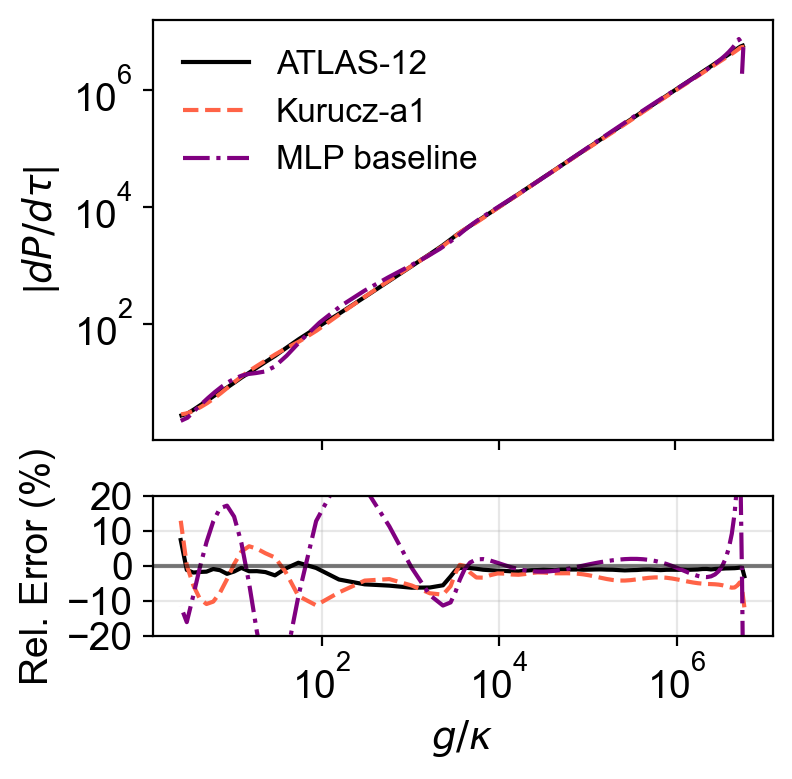

In [54]:
# Create figure with two panels vertically stacked
fig, (ax, ax_err) = plt.subplots(2, 1, figsize=(4., 4), height_ratios=[3, 1])

# Plot dP/dtau vs g/kappa (top panel)
ax.plot(dP_dtau_ground_truth['g_kappa'][idx_plot], dP_dtau_ground_truth['dP_dtau'][idx_plot], c='k', linestyle='-',
        label='ATLAS-12')
ax.plot(dP_dtau_predicted['g_kappa_pred'][idx_plot], dP_dtau_predicted['dP_dtau_pred'][idx_plot], c='tomato', linestyle='--',
        label='Kurucz-a1')
ax.plot(dP_dtau_predicted_mlp['g_kappa_pred'][idx_plot], dP_dtau_predicted_mlp['dP_dtau_pred'][idx_plot], c='purple', linestyle='-.',
        label='MLP baseline')
ax.set_ylabel(r'|$dP/d\tau$|')
ax.set(xscale='log', yscale='log')
ax.legend(frameon=False, fontsize=12)
ax.tick_params(labelbottom=False)

# Calculate relative errors for dP/dtau (bottom panel)
rel_err_gt = (dP_dtau_ground_truth['dP_dtau'][idx_plot] - dP_dtau_ground_truth['g_kappa'][idx_plot]) / dP_dtau_ground_truth['g_kappa'][idx_plot] * 100
rel_err_dP_kurucz = (dP_dtau_predicted['dP_dtau_pred'][idx_plot] - dP_dtau_predicted['g_kappa_pred'][idx_plot]) / dP_dtau_predicted['g_kappa_pred'][idx_plot] * 100
rel_err_dP_mlp = (dP_dtau_predicted_mlp['dP_dtau_pred'][idx_plot] - dP_dtau_predicted_mlp['g_kappa_pred'][idx_plot]) / dP_dtau_predicted_mlp['g_kappa_pred'][idx_plot] * 100

ax_err.plot(dP_dtau_ground_truth['g_kappa'][idx_plot], rel_err_gt, c='k', linestyle='-')
ax_err.plot(dP_dtau_ground_truth['g_kappa'][idx_plot], rel_err_dP_kurucz, c='tomato', linestyle='--')
ax_err.plot(dP_dtau_ground_truth['g_kappa'][idx_plot], rel_err_dP_mlp, c='purple', linestyle='-.')
ax_err.axhline(y=0, color='k', linestyle='-', alpha=0.5)
ax_err.set_xlabel(r'$g / \kappa$')
ax_err.set_ylabel('Rel. Error (%)')
ax_err.set_xscale('log')
ax_err.set_ylim([-20, 20])
ax_err.set_yticks([-20, -10, 0, 10, 20])
ax_err.grid(True, alpha=0.3)

# Apply formatters
ax.xaxis.set_major_formatter(LogFormatterMathtext())
ax.yaxis.set_major_formatter(LogFormatterMathtext())
ax_err.xaxis.set_major_formatter(LogFormatterMathtext())

plt.show()

fig.savefig('fig/dp_dtau_gk.pdf', dpi=500)

# Teff-logg Validation


In [51]:
teff_input = inputs[:, 0]
logg_input = inputs[:, 1]
feh_input = inputs[:, 2]
alpha_fe_input = inputs[:, 3]

teff_input = dataset.denormalize('teff', teff_input)
logg_input = dataset.denormalize('gravity', logg_input)
feh_input = dataset.denormalize('feh', feh_input)
alpha_fe_input = dataset.denormalize('afe', alpha_fe_input)

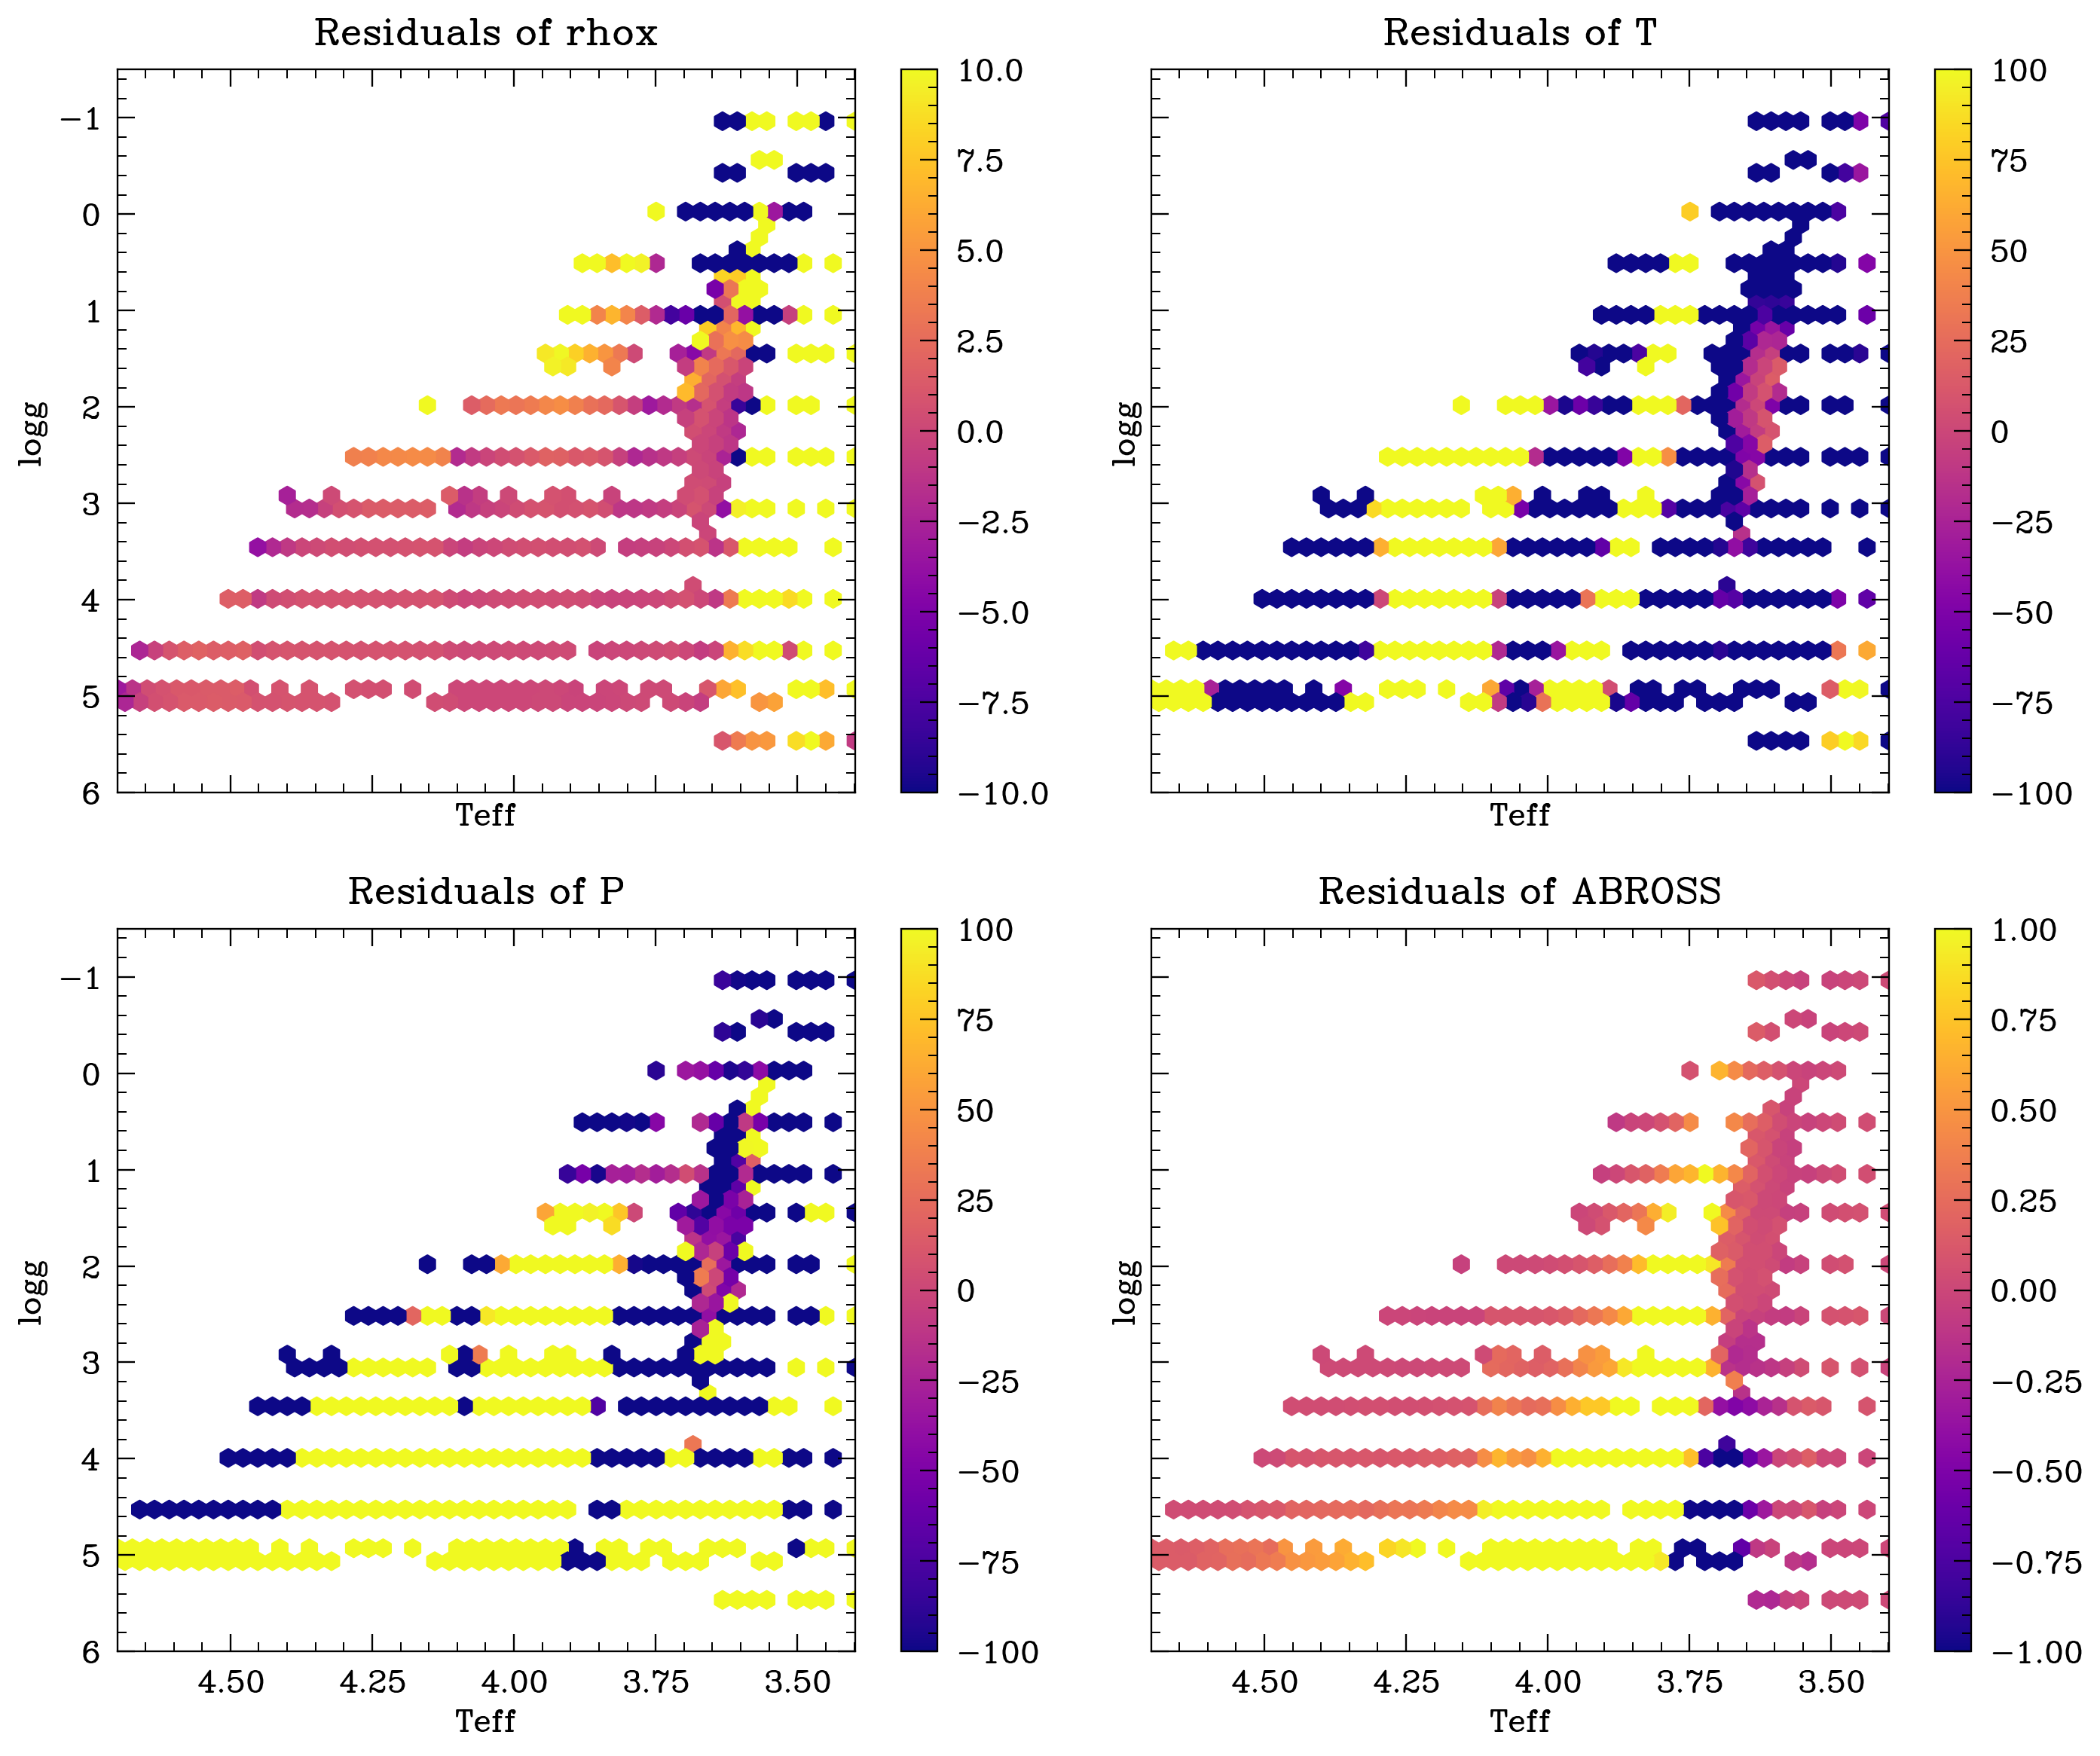

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Define variables, their titles, and their specific vmin/vmax values
variables = [
    (rhox_target-rhox_pred, 'RHOX', -10, 10),
    (T_target-T_pred, 'T', -100, 100),
    (P_target-P_pred, 'P', -100, 100),
    (kappa_target-kappa_pred, 'ABROSS', -1, 1)
]

# Create all four plots
for i, (error, title, vmin, vmax) in enumerate(variables):
    hexplot = axs[i].hexbin(np.log10(teff_input), logg_input, C=error, 
                 gridsize=50, cmap='plasma', extent=[np.log10(2500), np.log10(50000), -1.5, 6], 
                 mincnt=1, vmin=vmin, vmax=vmax)
    
    axs[i].set_xlabel('Teff')
    axs[i].set_ylabel('logg')
    axs[i].set_title(f'Residuals of {title}')
    axs[i].set_yscale('linear')
    axs[i].set_xlim(np.log10(50000), np.log10(2500))
    axs[i].set_ylim(6, -1.5)
    
    # Add a colorbar for each plot
    fig.colorbar(hexplot, ax=axs[i])

# Adjust the spacing between subplots
plt.tight_layout()

In [78]:
import pandas as pd
isochrones = pd.read_csv("~/Project/data/stellar_model/PARSEC_logage_6to10_MH_n2p5_0p6.csv")
isochrones.head()

Zini       MH  logAge      Mini    int_IMF   Mass   logL   logTe  \
0  0.000049 -2.19174     6.0  0.100000  25.728825  0.100 -0.791  3.5824   
1  0.000049 -2.19174     6.0  0.109821  25.871746  0.109 -0.729  3.5862   
2  0.000049 -2.19174     6.0  0.129464  26.082912  0.129 -0.636  3.5930   
3  0.000049 -2.19174     6.0  0.135367  26.132504  0.135 -0.623  3.5946   
4  0.000049 -2.19174     6.0  0.150608  26.239723  0.150 -0.581  3.5990   

    logg  label  ...         Z  mbolmag   Gmag  G_BPmag  G_RPmag  B_Tmag  \
0  3.511      0  ...  0.000200    6.748  7.100    7.907    6.242   9.226   
1  3.503      0  ...  0.000162    6.593  6.932    7.724    6.083   9.014   
2  3.508      0  ...  0.000142    6.359  6.675    7.438    5.841   8.682   
3  3.522      0  ...  0.000136    6.327  6.636    7.394    5.807   8.627   
4  3.543      0  ...  0.000105    6.222  6.514    7.254    5.694   8.459   

   V_Tmag   Jmag   Hmag  Ksmag  
0   7.861  5.095  4.502  4.312  
1   7.673  4.949  4.356  4.166  
2   7.383  4.733  4.140  3.952  
3   7.337  4.704  4.114  3.927  
4   7.195  4.609  4.022  3.837  

[5 rows x 36 columns]

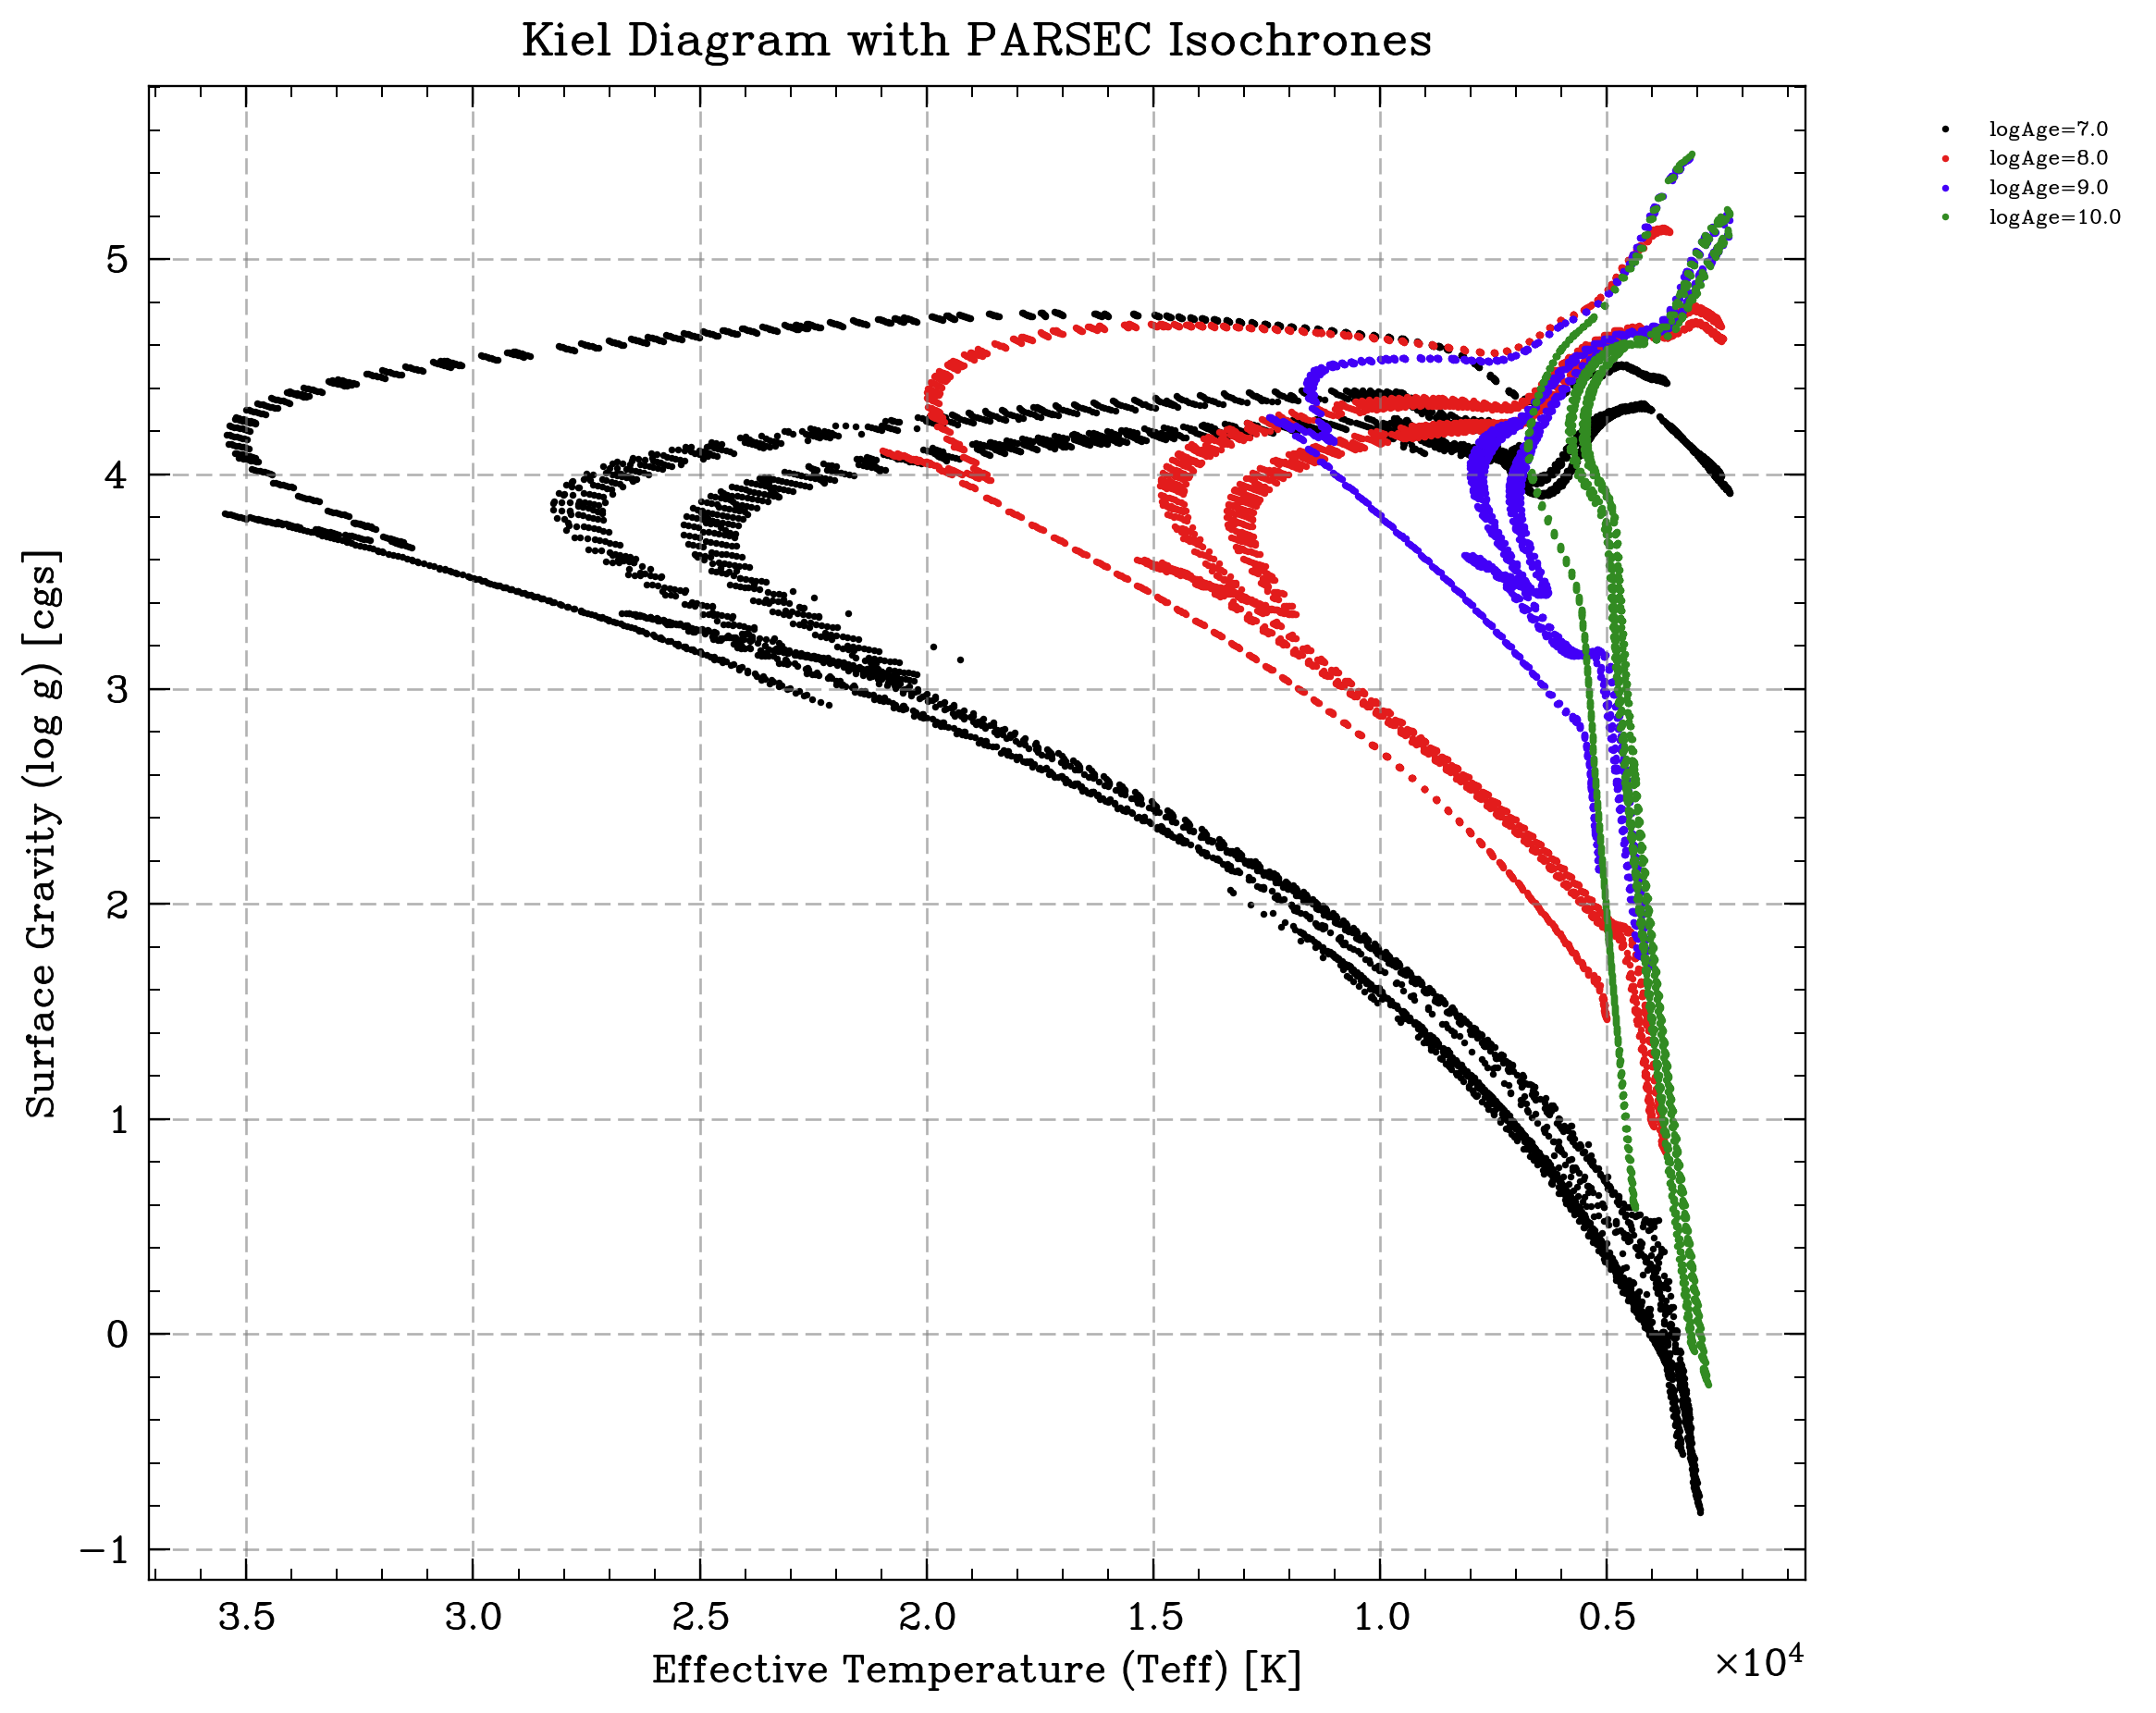

In [86]:
# Desired logAge (in years) and [M/H] values
log_ages = [7.0, 8.0, 9.0, 10.0]  # log10(age/yr)
mh_values = [-2, 0.0, 0.5]    # [M/H]
labels = [0, 1, 2, 3]             # Main Sequence, Subgiant, Red Giant

# Initialize plot
plt.figure(figsize=(10, 8))

# Colors for different stellar ages (instead of [M/H])
colors = ['C0', 'C1', 'C2', 'C3']  # One color per age

# Filter and plot isochrones
for i, log_age in enumerate(log_ages):
    color = colors[i]  # Assign color based on age
    
    for mh in mh_values:
        # Filter isochrone for specific logAge and [M/H]
        mask = (np.abs(isochrones['logAge'] - log_age) < 0.01) & (np.abs(isochrones['MH'] - mh) < 0.1) 
        mask_label = (isochrones['label']==0) | (isochrones['label']==1) | (isochrones['label']==2) | (isochrones['label']==3)
        
        iso_subset = isochrones[mask & mask_label]
        
        if iso_subset.empty:
            print(f"No data for logAge={log_age}, [M/H]={mh}")
            continue
        
        # Calculate Teff from logTe
        teff = 10 ** iso_subset['logTe']  # Convert logTe to Teff (K)
        logg = iso_subset['logg']
        
        # Plot isochrone with age-based color
        # Only add to legend for first metallicity value of each age
        if mh == mh_values[0]:
            label = f'logAge={log_age}'
        else:
            label = None
            
        plt.scatter(teff, logg, color=color, linewidths=0, label=label, s=5)

# Customize plot
plt.gca().invert_xaxis()  # Invert Teff axis (hotter stars on the left)
plt.xlabel('Effective Temperature (Teff) [K]')
plt.ylabel('Surface Gravity (log g) [cgs]')
plt.title('Kiel Diagram with PARSEC Isochrones')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()

In [93]:
def plot_isochrones(fig, ax, isochrones):
    """
    Plot stellar isochrones on a Kiel diagram with different colors for different ages.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure object to plot on
    ax : matplotlib.axes.Axes
        The axes object to plot on
    isochrones : pandas.DataFrame
        DataFrame containing isochrone data
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The updated figure object
    ax : matplotlib.axes.Axes
        The updated axes object
    """
    # Desired logAge (in years) and [M/H] values
    log_ages = [ 8.0, 9.0, 10.0]  # log10(age/yr)
    mh_values = [-2, 0.0, 0.5]    # [M/H]

    # Colors for different stellar ages (instead of [M/H])
    colors = ['C0', 'C1', 'C2', 'C3']  # One color per age

    # Filter and plot isochrones
    for i, log_age in enumerate(log_ages):
        color = colors[i]  # Assign color based on age
        
        for mh in mh_values:
            # Filter isochrone for specific logAge and [M/H]
            mask = (np.abs(isochrones['logAge'] - log_age) < 0.01) & (np.abs(isochrones['MH'] - mh) < 0.1) 
            mask_label = (isochrones['label']==0) | (isochrones['label']==1) | (isochrones['label']==2) | (isochrones['label']==3)
            
            iso_subset = isochrones[mask & mask_label]
            
            if len(iso_subset) == 0:
                print(f"No data for logAge={log_age}, [M/H]={mh}")
                continue
            
            # Calculate Teff from logTe
            teff = iso_subset['logTe']  # Convert logTe to Teff (K)
            logg = iso_subset['logg']
            
            # Plot isochrone with age-based color
            # Only add to legend for first metallicity value of each age
            if mh == mh_values[0]:
                label = f'logAge={log_age}'
            else:
                label = None
                
            ax.scatter(teff, logg, color=color, linewidths=0, label=label, s=1, alpha=0.5)

    # # Customize plot
    # ax.invert_xaxis()  # Invert Teff axis (hotter stars on the left)
    # ax.set_xlabel('Effective Temperature (Teff) [K]')
    # ax.set_ylabel('Surface Gravity (log g) [cgs]')
    # ax.set_title('Kiel Diagram with PARSEC Isochrones')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    # ax.grid(True)
    
    return fig, ax

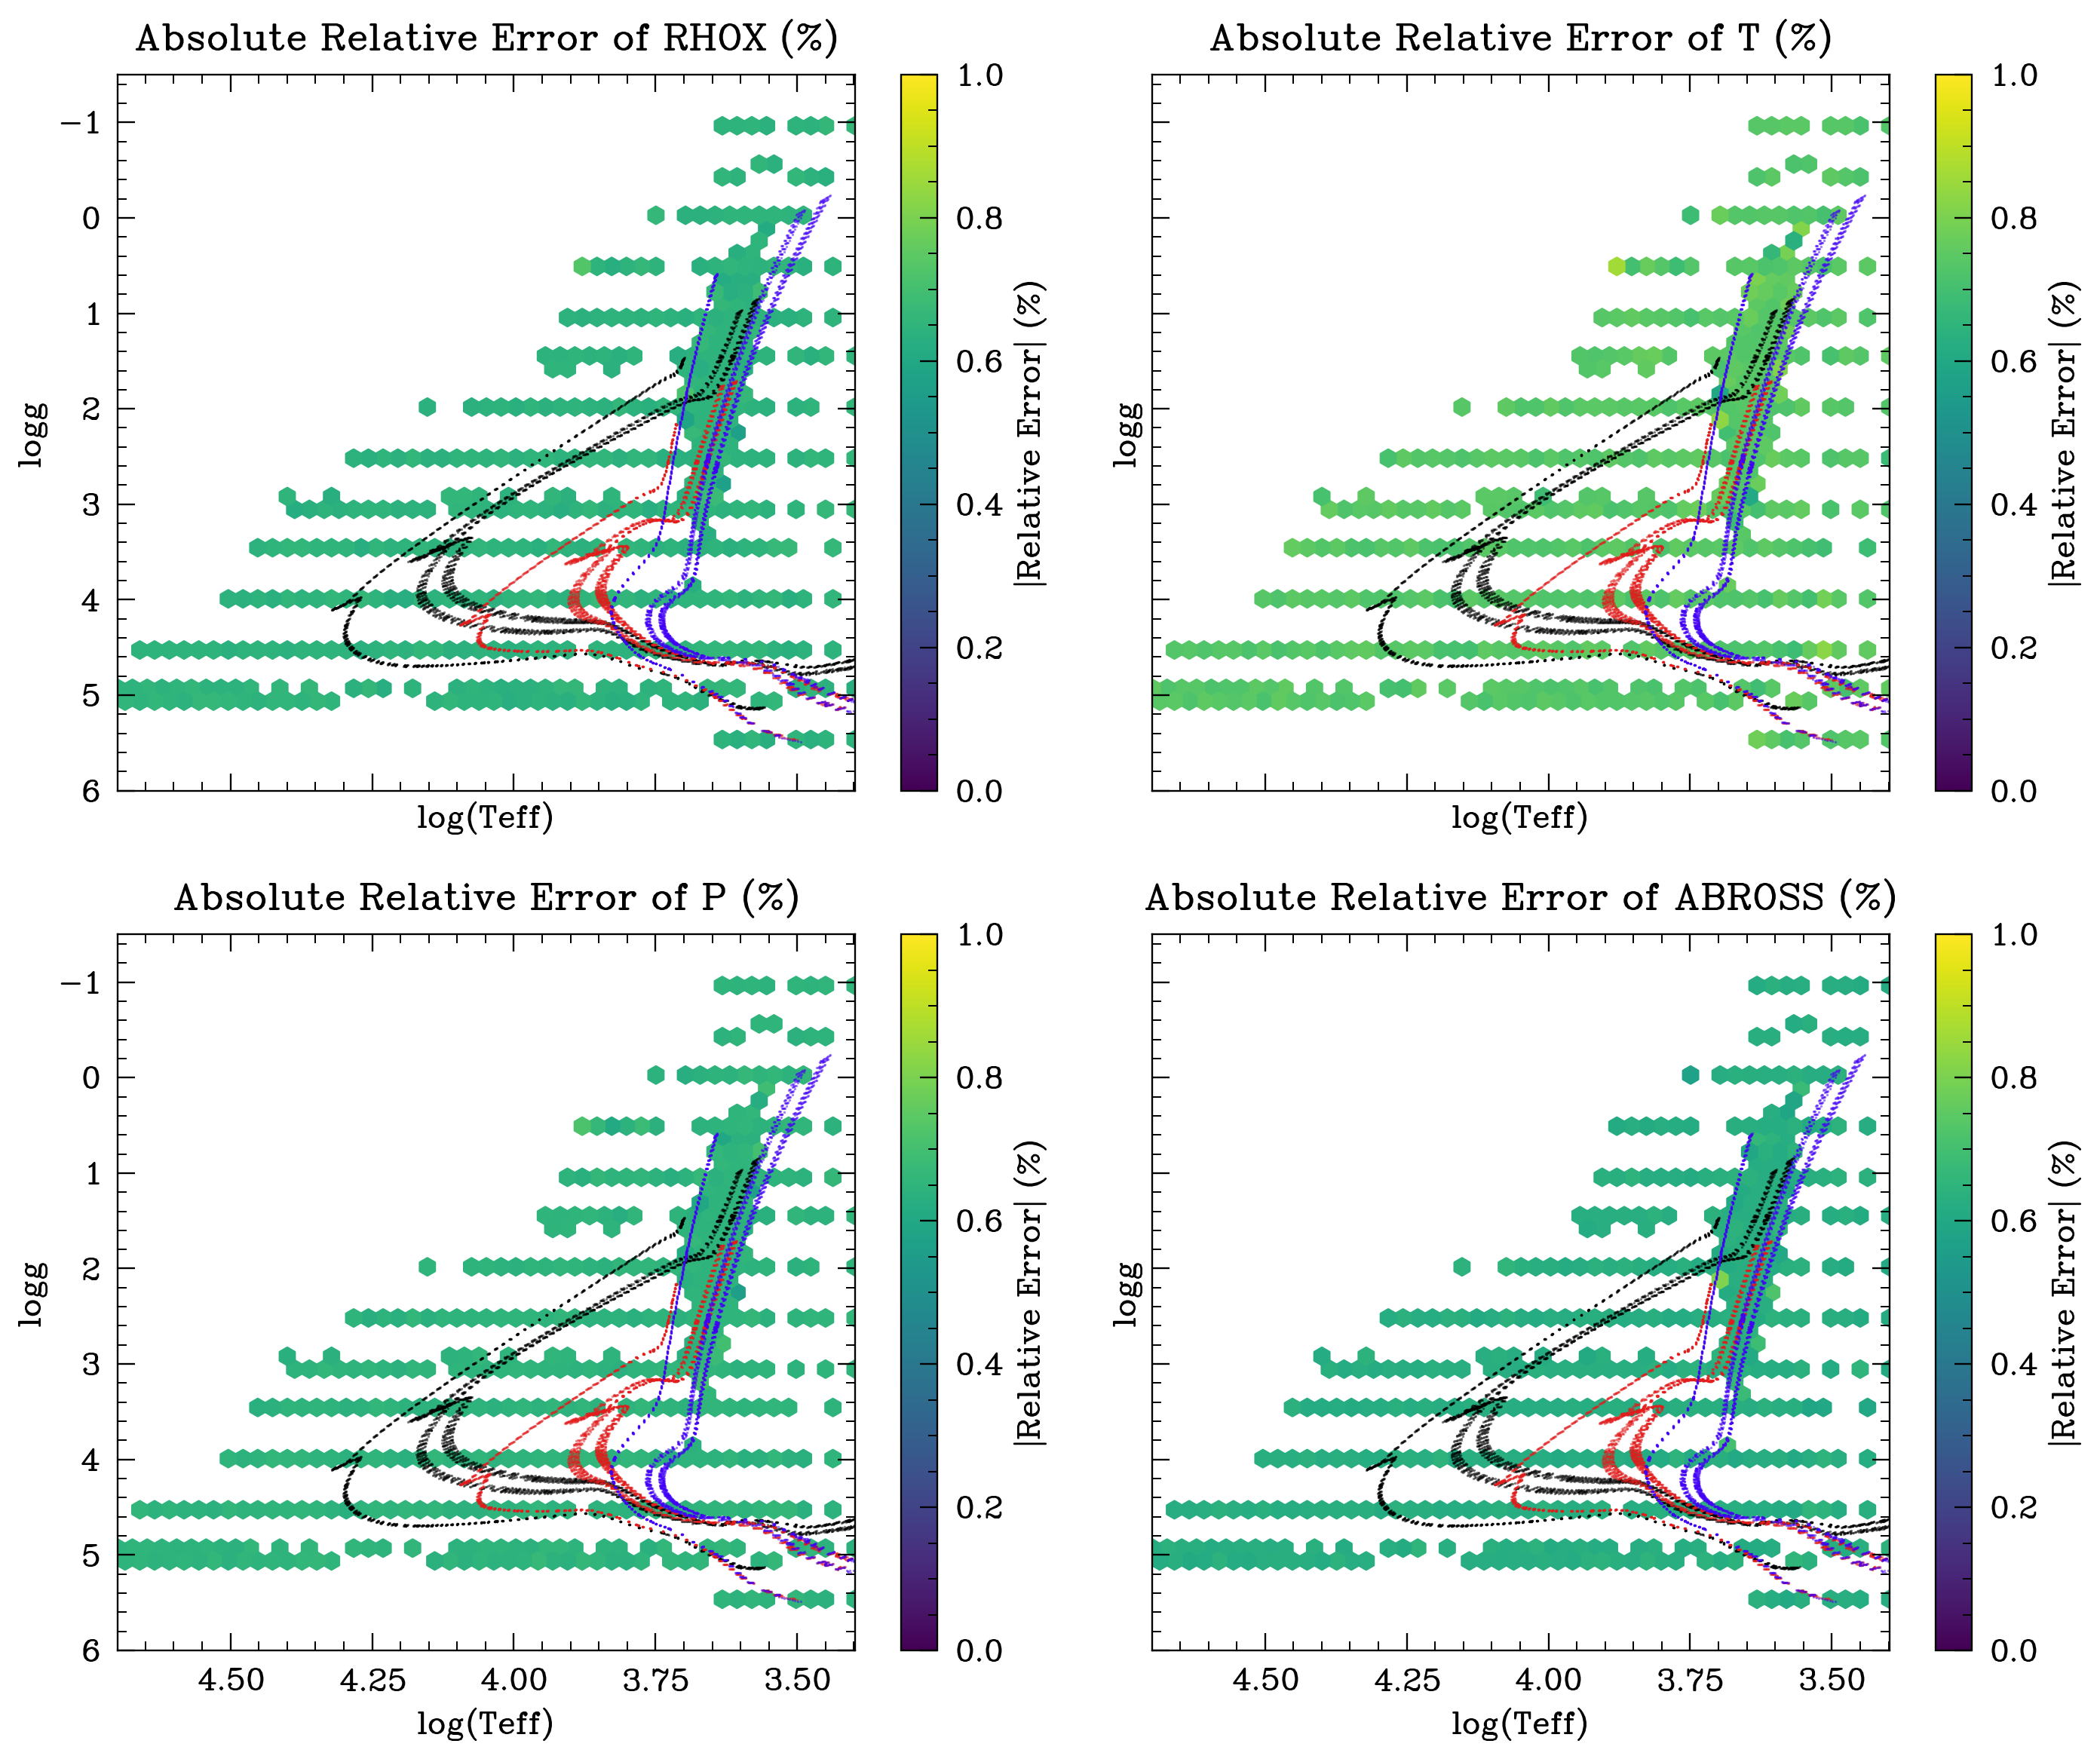

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Small epsilon to avoid division by zero
epsilon = 1e-10

# Calculate median values for target variables
rhox_median = np.median(rhox_target)
T_median = np.median(T_target)
P_median = np.median(P_target)
kappa_median = np.median(kappa_target)

# Calculate absolute relative errors (in percentage) using median as the denominator
# Use safe division to avoid division by zero
rhox_abs_rel_error = np.abs((rhox_target - rhox_pred) / np.median(rhox_target) * 100)
T_abs_rel_error = np.abs((T_target - T_pred) / np.median(T_target) * 100)
P_abs_rel_error = np.abs((P_target - P_pred) / np.median(P_target) * 100)
kappa_abs_rel_error = np.abs((kappa_target - kappa_pred) / np.median(kappa_target) * 100)

# Define variables, their titles with uniform vmin/vmax values
variables = [
    (rhox_abs_rel_error, 'RHOX', 0, 1),    # 0-10% absolute relative error
    (T_abs_rel_error, 'T', 0, 1),          # 0-10% absolute relative error
    (P_abs_rel_error, 'P', 0, 1),          # 0-10% absolute relative error
    (kappa_abs_rel_error, 'ABROSS', 0, 1)  # 0-10% absolute relative error
]

# Create all four plots
for i, (error, title, vmin, vmax) in enumerate(variables):
    # Apply filtering to limit extreme values for better visualization
    error_filtered = np.clip(error, vmin, vmax)
    
    hexplot = axs[i].hexbin(np.log10(teff_input), logg_input, C=error_filtered, 
                 gridsize=50, cmap='viridis', extent=[np.log10(2500), np.log10(50000), -1.5, 6], 
                 rasterized=True,
                 mincnt=1, vmin=vmin, vmax=vmax)
    
    axs[i].set_xlabel('log(Teff)')
    axs[i].set_ylabel('logg')
    axs[i].set_title(f'Absolute Relative Error of {title} (%)')
    axs[i].set_yscale('linear')
    axs[i].set_xlim(np.log10(50000), np.log10(2500))
    axs[i].set_ylim(6, -1.5)

    # Plot isochrones if the function is available
    try:
        fig, ax = plot_isochrones(fig, axs[i], isochrones)
    except NameError:
        # If isochrones plotting is not available, continue without it
        pass
    
    # Add a colorbar for each plot
    cbar = fig.colorbar(hexplot, ax=axs[i])
    cbar.set_label('|Relative Error| (%)')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure
fig.savefig("fig/kiel_abs_relative_errors.pdf")

# SME format

In [161]:
%reload_ext autoreload
%autoreload 2
import torch
from kuruczone import emulator

# Load pre-trained model
model = emulator.load_from_checkpoint("checkpoints_0409/best_model.pt")

# Create stellar parameter inputs
stellar_params = torch.tensor([[5772.0, 4.44, 0.0, 0.0]])  # Teff, log(g), [Fe/H], [α/Fe]

# Create optical depth grid (optional)
tau_grid = torch.from_numpy(tau_lin)

# Predict atmospheric structure
atmosphere = model.predict(stellar_params, tau_grid)

# Access variables
temperature = atmosphere['T']  # Shape: [batch_size, n_depth_points]
pressure = atmosphere['P']

Model loaded: trained for 55 epochs, final loss: 0.000762


In [162]:
import numpy as np

def convert_to_sme_format(atlas_data, teff=5777.0, logg=4.485, m_h=0.0, vturb=1.0):
    """
    Convert ATLAS12 model grid data to SME format.
    
    Parameters:
    -----------
    atlas_data : dict
        Dictionary with keys ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'TAU'],
        each containing arrays of 80 depth points.
    teff : float, optional
        Effective temperature (K). Default: 5777.0 (solar-like).
    logg : float, optional
        Surface gravity (log g, cgs units). Default: 4.485.
    m_h : float, optional
        Metallicity [M/H]. Default: 0.0 (solar).
    vturb : float, optional
        Microturbulence velocity (km/s). Default: 1.0.
    
    Returns:
    --------
    sme_atmos : dict
        Dictionary in SME format with stellar parameters, abundances, and atmospheric structure.
    """
    # Constants
    mu = 1.2  # Mean molecular weight (solar photosphere, partially ionized)
    m_H = 1.6735575e-24  # Mass of hydrogen (g)
    k = 1.380649e-16  # Boltzmann constant (erg/K)
    g = 10**logg  # Surface gravity (cm/s^2)
    sigma_eff = 1e-26  # Effective cross-section for H^- (cm^2)

    # Extract input data (80 depth points)
    rhox = atlas_data['RHOX'][0]  # g/cm^2
    temp = atlas_data['T'][0]    # K
    pressure = atlas_data['P'][0]  # dyn/cm^2
    xne = atlas_data['XNE'][0]    # cm^-3
    abross = atlas_data['ABROSS'][0]  # cm^2/g
    tau = atlas_data['TAU'][0]    # Optical depth (dimensionless)

    n_layers = len(rhox)
    # Compute density (rho)
    rho = (pressure * mu * m_H) / (k * temp)  # g/cm^3

    # Compute height (z)
    # Set reference height z = 0 at tau ≈ 1
    ref_idx = np.argmin(np.abs(tau - 1.0))
    z_ref = 0.0
    dRHOX = np.diff(rhox)  # Shape: (79,)
    dz = -dRHOX / rho[:-1]  # Shape: (79,)
    
    # Initialize height array
    height = np.zeros(n_layers)
    height[ref_idx] = z_ref
    # Integrate outward (i > ref_idx)
    for i in range(ref_idx, n_layers-1):
        height[i+1] = height[i] + dz[i]
    # Integrate inward (i < ref_idx)
    for i in range(ref_idx-1, -1, -1):
        height[i] = height[i+1] - dz[i]

    # Compute XNA (number density of absorbers)
    kappa_vol = abross * rho  # cm^-1
    xna = kappa_vol / sigma_eff  # cm^-3

    # Solar abundances (from your SME example)
    abundances = {
        'H': 12.000, 'He': 12.114, 'Li': 1.046, 'Be': 1.376, 'B': 2.696,
        'C': 8.386, 'N': 7.776, 'O': 8.656, 'F': 4.556, 'Ne': 7.836,
        'Na': 6.166, 'Mg': 7.526, 'Al': 6.366, 'Si': 7.506, 'P': 5.356,
        'S': 7.136, 'Cl': 5.496, 'Ar': 6.176, 'K': 5.076, 'Ca': 6.306,
        'Sc': 3.166, 'Ti': 4.896, 'V': 3.996, 'Cr': 5.636, 'Mn': 5.386,
        'Fe': 7.446, 'Co': 4.916, 'Ni': 6.226, 'Cu': 4.206, 'Zn': 4.596,
        'Ga': 2.876, 'Ge': 3.576, 'As': 2.286, 'Se': 3.326, 'Br': 2.556,
        'Kr': 3.246, 'Rb': 2.596, 'Sr': 2.916, 'Y': 2.206, 'Zr': 2.576,
        'Nb': 1.416, 'Mo': 1.916, 'Tc': -7.964, 'Ru': 1.836, 'Rh': 1.116,
        'Pd': 1.656, 'Ag': 0.936, 'Cd': 1.766, 'In': 1.596, 'Sn': 1.996,
        'Sb': 0.996, 'Te': 2.186, 'I': 1.506, 'Xe': 2.236, 'Cs': 1.066,
        'Ba': 2.166, 'La': 1.126, 'Ce': 1.696, 'Pr': 0.576, 'Nd': 1.446,
        'Pm': -7.964, 'Sm': 0.996, 'Eu': 0.516, 'Gd': 1.106, 'Tb': 0.276,
        'Dy': 1.136, 'Ho': 0.506, 'Er': 0.926, 'Tm': -0.004, 'Yb': 1.076,
        'Lu': 0.056, 'Hf': 0.876, 'Ta': -0.174, 'W': 1.106, 'Re': 0.226,
        'Os': 1.246, 'Ir': 1.376, 'Pt': 1.636, 'Au': 1.006, 'Hg': 1.126,
        'Tl': 0.896, 'Pb': 1.996, 'Bi': 0.646, 'Po': -7.964, 'At': -7.964,
        'Rn': -7.964, 'Fr': -7.964, 'Ra': -7.964, 'Ac': -7.964, 'Th': 0.056,
        'Pa': -7.964, 'U': -0.524, 'Np': -7.964, 'Pu': -7.964, 'Am': -7.964,
        'Cm': -7.964, 'Bk': -7.964, 'Cf': -7.964, 'Es': -7.964
    }

    # Construct opflag (example: 1 for used layers, 0 for extrapolated or unused)
    opflag = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]

    # SME atmosphere dictionary
    sme_atmos = {
        'teff': teff,
        'logg': logg,
        'abund': f'[M/H]={m_h:.3f} applied to abundance pattern. Values below are abundances.\n' +
                 '  '.join([f'{k:3} {v:7.3f}' for k, v in abundances.items()]),
        'vturb': vturb,
        'lonh': 1.5,  # Hydromagnetic pressure parameter (from your example)
        'source': 'marcs2012.sav',  # Source identifier (adjust if ATLAS12-specific)
        'method': 'grid',  # Interpolation method
        'geom': 'PP',  # Plane-parallel geometry
        'radius': 1.0,  # Stellar radius (normalized or in solar units, adjust if needed)
        'height': -height,  # cm
        'opflag': opflag,  # Flags for layers
        'wlstd': 5000.0,  # Reference wavelength for TAU (Å)
        'depth': 'RHOX',  # Depth scale
        'interp': 'TAU',  # Interpolation method for SME
        'rhox': rhox,  # g/cm^2
        'tau': tau,  # Optical depth
        'temp': temp,  # K
        'rho': rho,  # g/cm^3
        'xna': xna,  # cm^-3
        'xne': xne  # cm^-3
    }

    return sme_atmos

sme_atmos = convert_to_sme_format(atmosphere, teff=5772.0, logg=4.44, m_h=0.0, vturb=1.0)

In [164]:
sme_atmos

{'teff': 5772.0,
 'logg': 4.44,
 'abund': '[M/H]=0.000 applied to abundance pattern. Values below are abundances.\nH    12.000  He   12.114  Li    1.046  Be    1.376  B     2.696  C     8.386  N     7.776  O     8.656  F     4.556  Ne    7.836  Na    6.166  Mg    7.526  Al    6.366  Si    7.506  P     5.356  S     7.136  Cl    5.496  Ar    6.176  K     5.076  Ca    6.306  Sc    3.166  Ti    4.896  V     3.996  Cr    5.636  Mn    5.386  Fe    7.446  Co    4.916  Ni    6.226  Cu    4.206  Zn    4.596  Ga    2.876  Ge    3.576  As    2.286  Se    3.326  Br    2.556  Kr    3.246  Rb    2.596  Sr    2.916  Y     2.206  Zr    2.576  Nb    1.416  Mo    1.916  Tc   -7.964  Ru    1.836  Rh    1.116  Pd    1.656  Ag    0.936  Cd    1.766  In    1.596  Sn    1.996  Sb    0.996  Te    2.186  I     1.506  Xe    2.236  Cs    1.066  Ba    2.166  La    1.126  Ce    1.696  Pr    0.576  Nd    1.446  Pm   -7.964  Sm    0.996  Eu    0.516  Gd    1.106  Tb    0.276  Dy    1.136  Ho    0.506  Er    0.926  T

In [ ]:
# save to dict
import pickle
with open('solar_kurucza1.pkl', 'wb') as f:
    pickle.dump(sme_atmos, f)

: 

# hydro equibrium

In [48]:
# Example usage:
dP_dtau_ground_truth = calculate_dP_dtau_ground_truth(dataset, sample_indices=sample_indices)
dP_dtau_predicted = calculate_dP_dtau_predicted(model, dataset, sample_indices=sample_indices, device=device)

IndexError: list index out of range

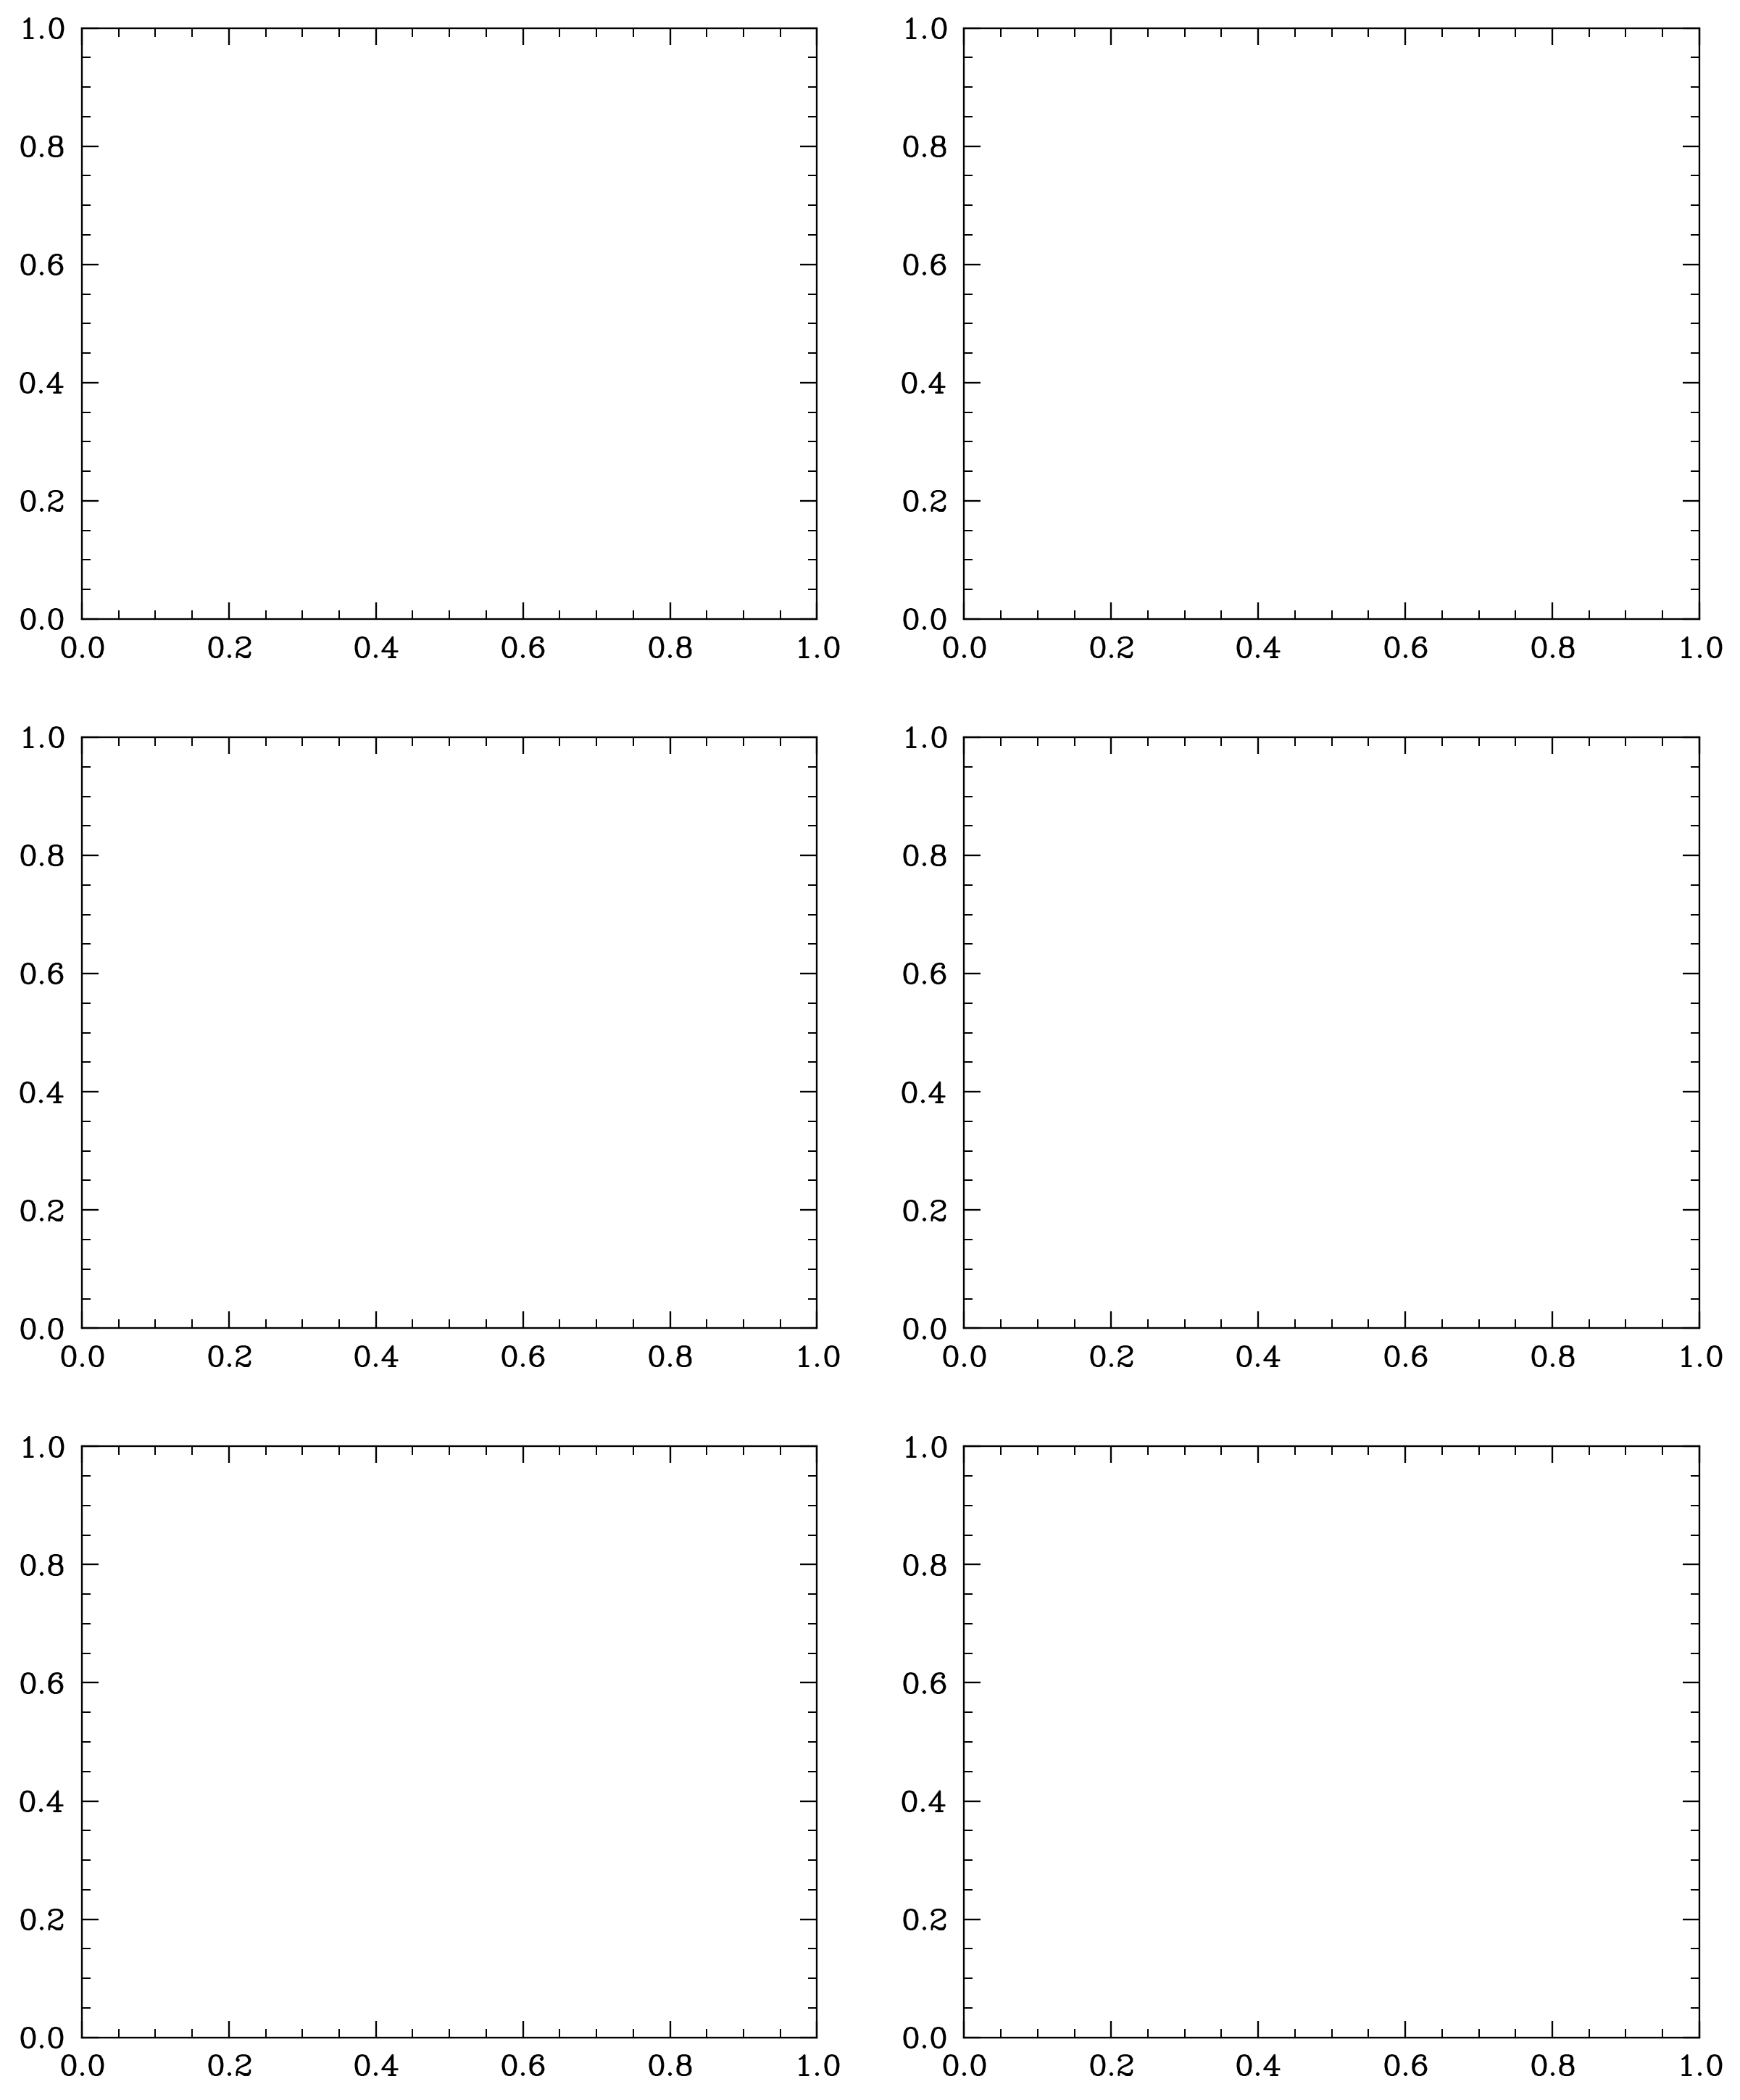

In [49]:
# Example usage:
fig = plot_comprehensive_comparison(dP_dtau_predicted, dP_dtau_ground_truth, sample_idx=3)

# Physical losses


In [90]:
%reload_ext autoreload
%autoreload 2
from physics import hydro_equilibrium_loss

Model loaded: trained for 1000 epochs, final loss: 0.002732
Validation loss: 0.002708
Validation loss hydro: 0.002864
RHOX loss: 0.000432
T loss: 0.000106
P loss: 0.000352
XNE loss: 0.000144
ABROSS loss: 0.001614
ACCRAD loss: 0.000060

RHOX metrics:
MSE: 0.000087
RMSE: 0.009305
MAE: 0.006114
R²: 0.999426

T metrics:
MSE: 0.000011
RMSE: 0.003248
MAE: 0.001764
R²: 0.999480

P metrics:
MSE: 0.000071
RMSE: 0.008411
MAE: 0.005503
R²: 0.999259

XNE metrics:
MSE: 0.000145
RMSE: 0.012027
MAE: 0.007660
R²: 0.998592

ABROSS metrics:
MSE: 0.000162
RMSE: 0.012717
MAE: 0.008306
R²: 0.998642

ACCRAD metrics:
MSE: 0.000059
RMSE: 0.007713
MAE: 0.005527
R²: 0.996847


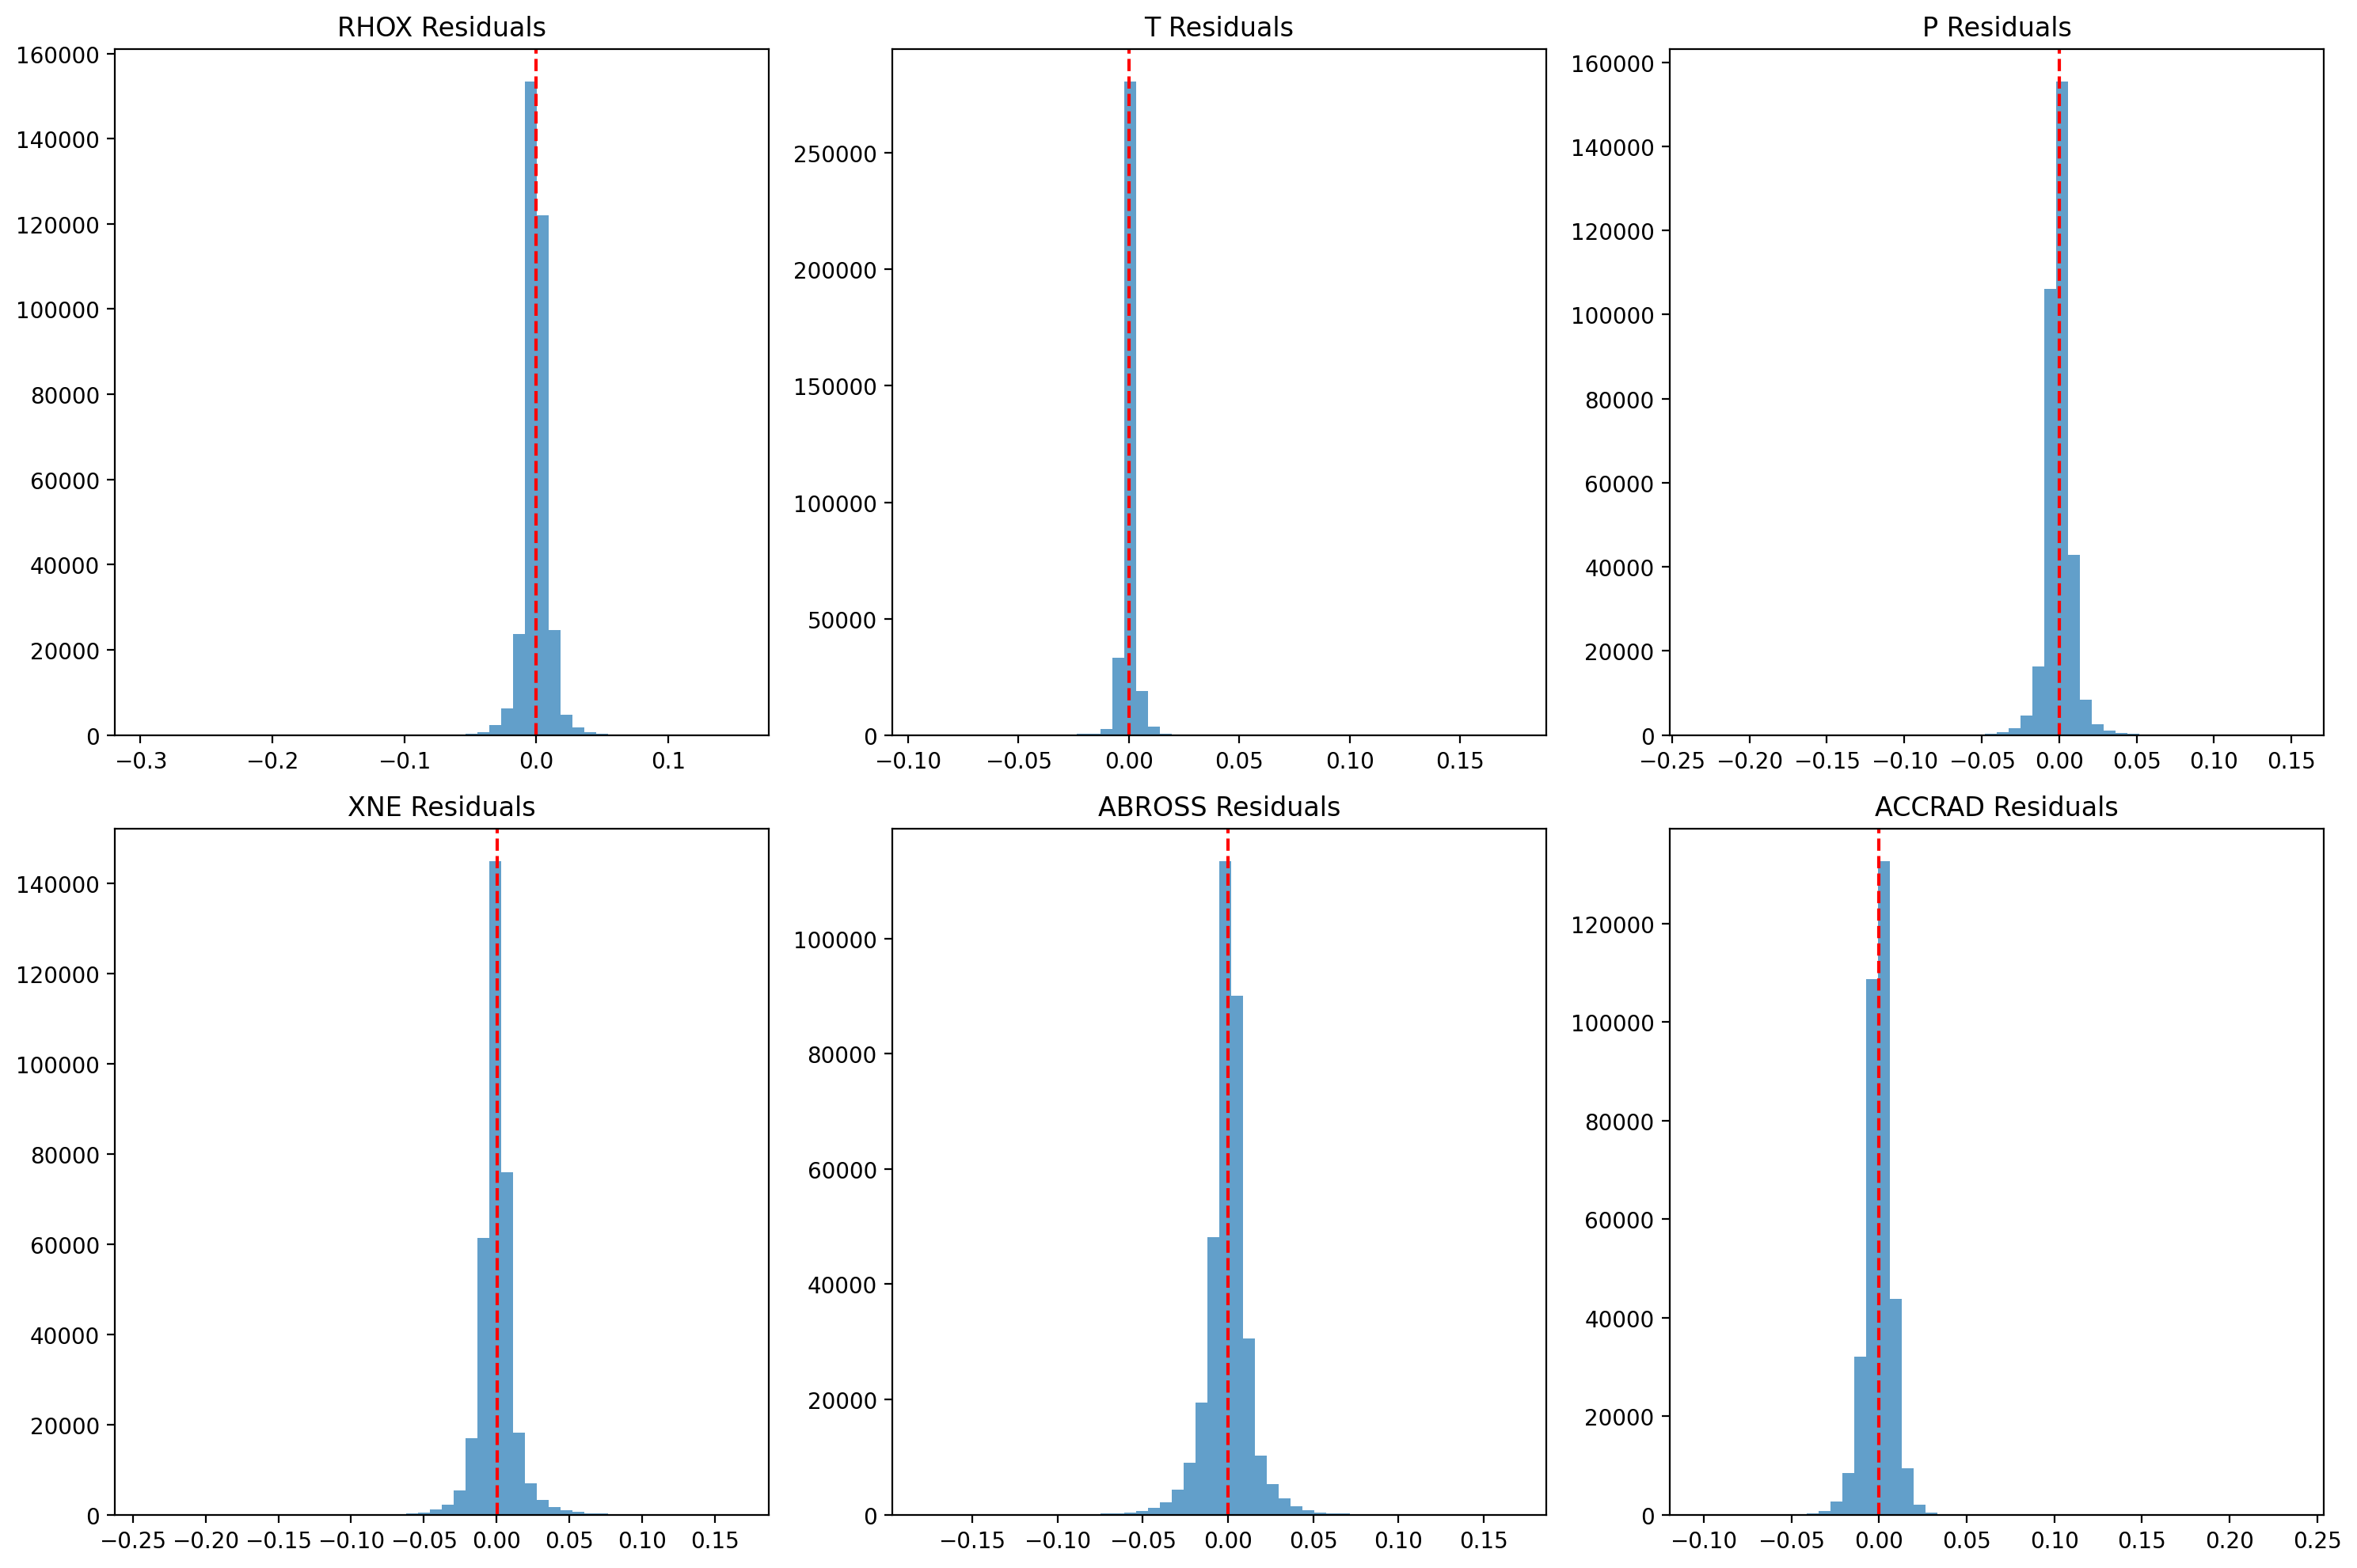

In [53]:
model_path = "/home/jdli/xiasangju/kurucz1/checkpoints_v0327enc/best_model.pt"
model_hytro_path = "/home/jdli/xiasangju/kurucz1/checkpoints_v0327enc_hydro/best_model.pt"
dataset_path = "/home/jdli/xiasangju/kurucz1/data/kurucz_vturb_0p5_tau_v3.pt"

hidden_size = 128
device = torch.device('cpu')

# Load dataset and model
model, epoch, train_loss = load_trained_model(
    model_path, hidden_size, dataset.max_depth_points, device
)
print(f"Model loaded: trained for {epoch} epochs, final loss: {train_loss:.6f}")


model_hydro, epoch_hydro, train_loss_hydro = load_trained_model(
    model_hytro_path, hidden_size, dataset.max_depth_points, device
)

# Validate model
val_loss, param_losses, inputs, predictions, targets = validate_model(model, val_loader, device)
val_loss_hydro, param_losses_hydro, inputs_hydro, predictions_hydro, targets_hydro = validate_model(model_hydro, val_loader, device)
print(f"Validation loss: {val_loss:.6f}")
print(f"Validation loss hydro: {val_loss_hydro:.6f}")
for param, loss in param_losses.items():
    print(f"{param} loss: {loss:.6f}")


# Calculate metrics
metrics = calculate_metrics(predictions, targets)
for param, param_metrics in metrics.items():
    print(f"\n{param} metrics:")

    for metric_name, value in param_metrics.items():
        print(f"{metric_name}: {value:.6f}")

        
residual_plot = plot_residuals(predictions, targets)
# Plot a few sample profiles
torch.manual_seed(0)
sample_indices = torch.randperm(predictions.shape[0])[:10]

In [54]:
# random seed
torch.manual_seed(0)
sample_indices = torch.randperm(predictions.shape[0])[:10]

dP_dtau_ground_truth    = calculate_dP_dtau_ground_truth(dataset, sample_indices=sample_indices)
dP_dtau_predicted       = calculate_dP_dtau_predicted(model, dataset, sample_indices=sample_indices, device=device)
dP_dtau_predicted_hydro = calculate_dP_dtau_predicted(model_hydro, dataset, sample_indices=sample_indices, device=device)


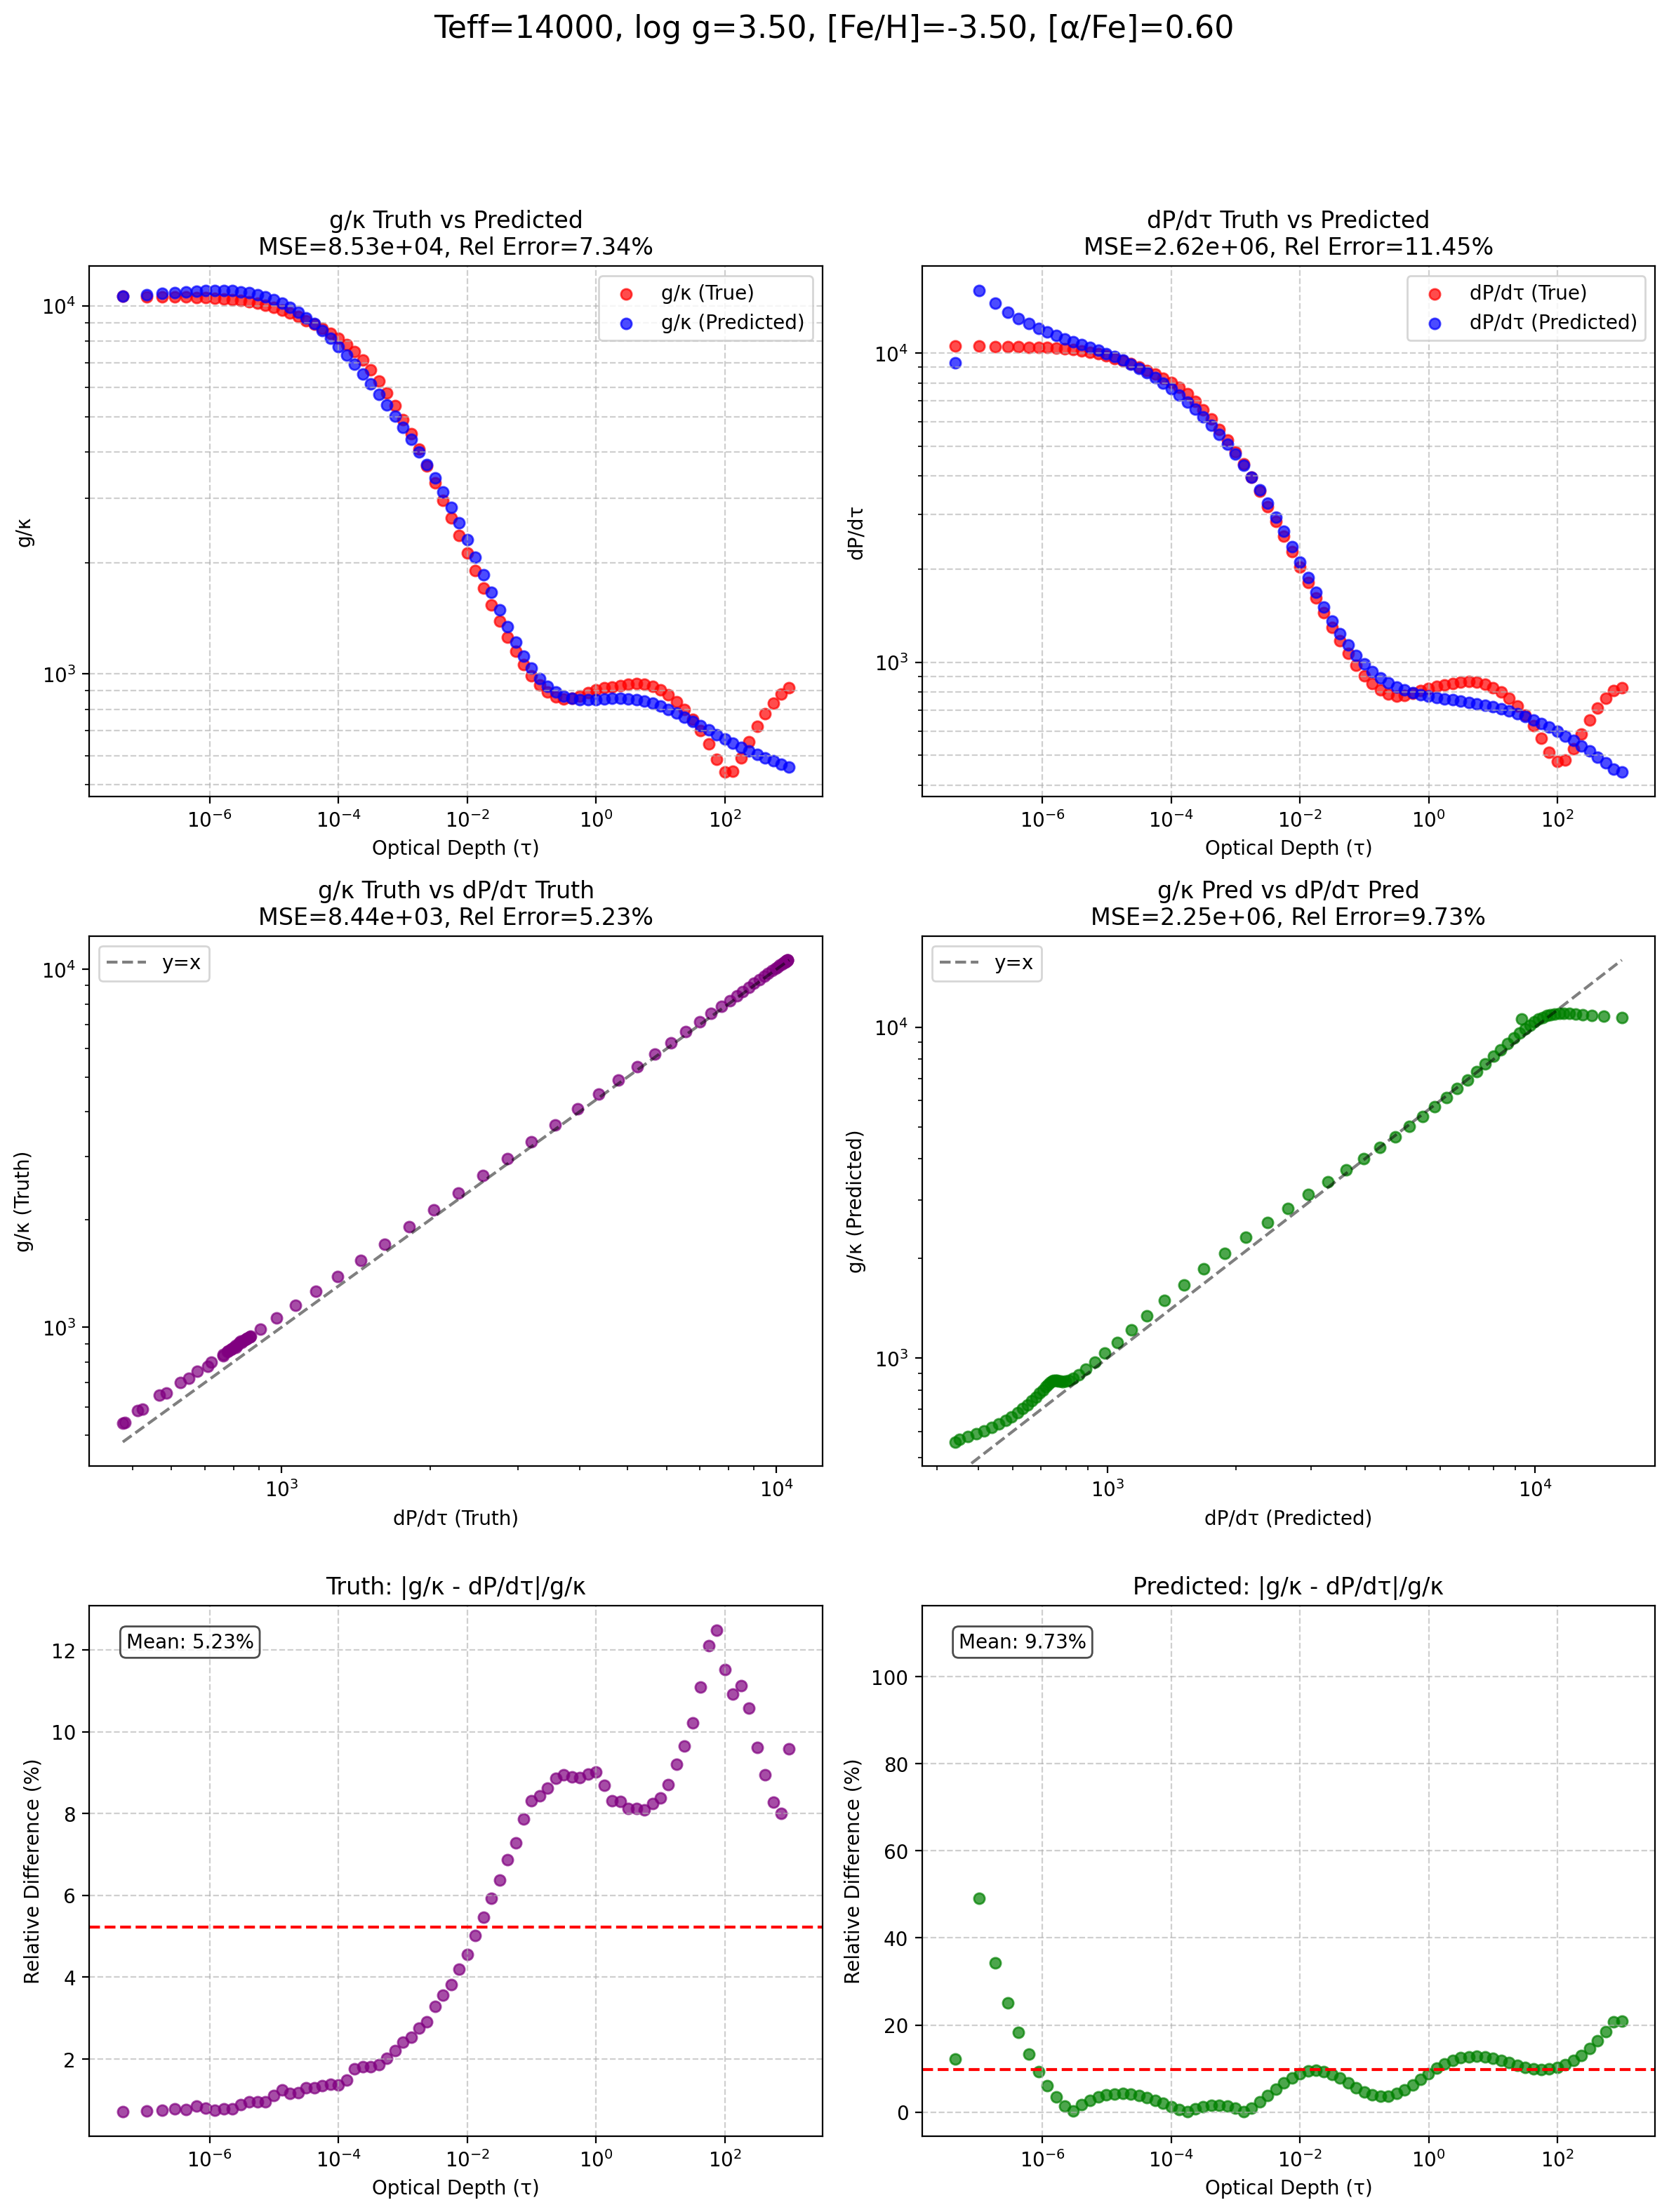

In [68]:
fig = plot_comprehensive_comparison(dP_dtau_predicted, dP_dtau_ground_truth, sample_idx=6)


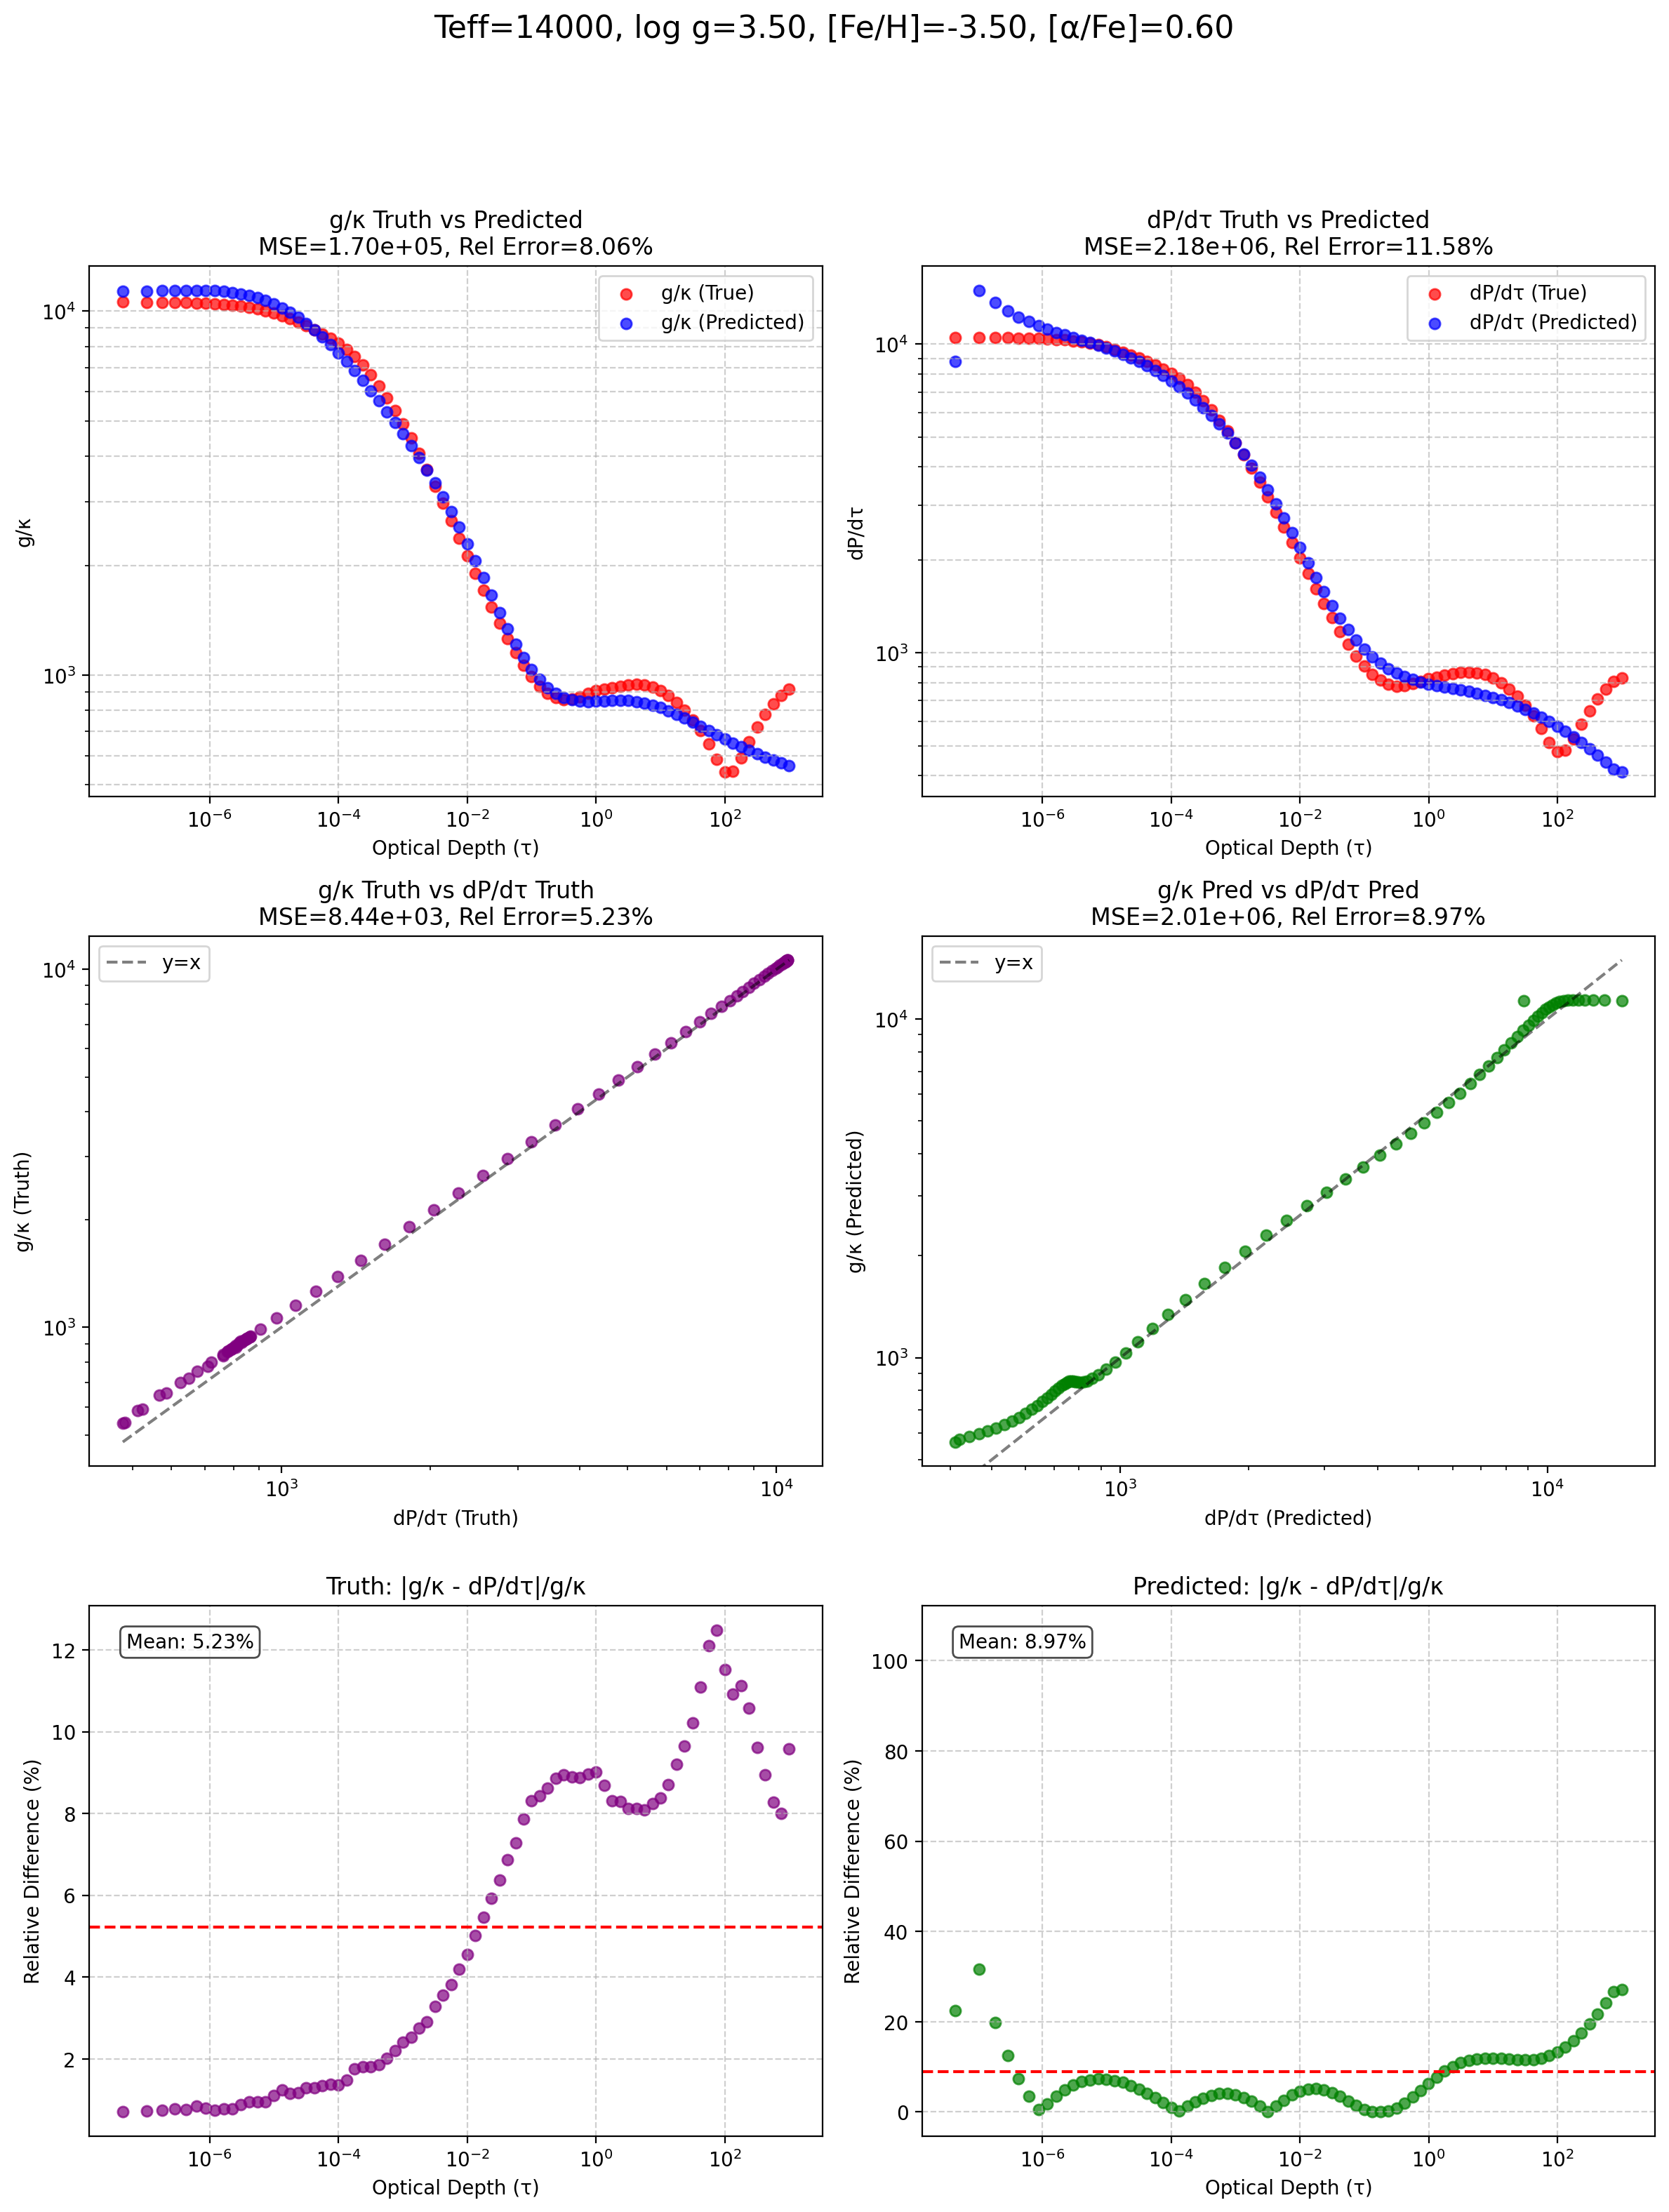

In [69]:
fig = plot_comprehensive_comparison(dP_dtau_predicted_hydro, dP_dtau_ground_truth, sample_idx=6)

In [59]:
def hydro_equilibrium_loss(outputs, inputs, dataset, model, is_training=True):
    """
    Calculate hydrostatic equilibrium physics-informed loss
    
    Args:
        outputs (torch.Tensor): Model outputs (normalized)
        inputs (torch.Tensor): Model inputs
        dataset (KuruczDataset): Dataset object containing normalization parameters
        model (nn.Module): The neural network model
        is_training (bool): Whether we're in training mode
    
    Returns:
        torch.Tensor: Computed physics loss
    """
    # Constants for numerical stability and gradient clipping
    GRAD_CLIP = 1e3
    SAFE_LOG = 1e-30
    
    # ===== Parameter indices =====
    P_idx = 2        # Pressure index in output (3rd parameter)
    ABROSS_idx = 4    # ABROSS index in output (5th parameter)
    TAU_START = 4     # Starting index of tau parameters in input

    # ===== 1. Data Preparation =====
    p_params = dataset.norm_params['P']
    tau_params = dataset.norm_params['TAU']
    
    # Create inputs that require gradients
    grad_inputs = inputs.detach().clone()
    grad_inputs.requires_grad_(True)

    # ===== 2. Gradient Calculation =====
    # Temporarily set model to eval/train mode as needed
    original_training = model.training
    if is_training:
        model.train()
    else:
        model.eval()
        
    # Forward pass through the model
    model_outputs = model(grad_inputs)  # Output shape: (n_batch, 6, 80)
    P_norm = model_outputs[:, :, P_idx]  # [batch, depth]

    # Compute gradients
    grad_outputs = torch.ones_like(P_norm)
    try:
        gradients = torch.autograd.grad(
            outputs=P_norm,
            inputs=grad_inputs,
            grad_outputs=grad_outputs,
            create_graph=is_training,
            retain_graph=True,
            allow_unused=False
        )[0]
    
        # Extract tau gradients and clamp
        dlogP_norm_dlogtau_norm = gradients[:, TAU_START:TAU_START+80]
        dlogP_norm_dlogtau_norm = torch.clamp(dlogP_norm_dlogtau_norm, -GRAD_CLIP, GRAD_CLIP)

        # ===== 3. Physical Conversion =====
        logtau = (grad_inputs[:, TAU_START:TAU_START+80] * tau_params['scale'] 
                + (tau_params['min'] + tau_params['max'])/2)
        logP = (P_norm * p_params['scale'] 
            + (p_params['min'] + p_params['max'])/2)
        
        scale_ratio = p_params['scale'] / tau_params['scale']
        dlogP_dlogtau = dlogP_norm_dlogtau_norm * scale_ratio
        
        # Improved numerical stability in logarithm
        eps_mask = dlogP_dlogtau.abs() < SAFE_LOG
        safe_dlogP = dlogP_dlogtau.clone()
        safe_dlogP[eps_mask] = torch.sign(safe_dlogP[eps_mask]) * SAFE_LOG
        log_dP_dtau = logP - logtau + torch.log10(safe_dlogP.abs())

    except RuntimeError as e:
        if is_training:
            # During training, re-raise the error for debugging
            raise RuntimeError(f"Gradient calculation failed during training: {e}")
        else:
            # During validation/inference, log warning and return zero loss
            print(f"[WARNING] d(logP)/d(tau) gradient calculation failed: {e}")
            # Restore model state and return zero loss
            model.train(original_training)
            return torch.tensor(0.0, device=outputs.device)

    # ===== 4. Equilibrium Condition =====
    ABROSS_norm = torch.clamp(outputs[:, :, ABROSS_idx], -5.0, 5.0)
    kappa = dataset.denormalize('ABROSS', ABROSS_norm)
    log_kappa = torch.log10(torch.clamp(kappa, min=SAFE_LOG))
    
    logg = dataset.denormalize('gravity', inputs[:, 1])
    logg = torch.clamp(logg, -1, 6).unsqueeze(-1)

    term_left = log_dP_dtau     # (n_batch, 80)
    term_right = logg - log_kappa  # (n_batch, 80)

    # ===== 5. Modified Loss Calculation =====
    valid_mask = torch.isfinite(term_left) & torch.isfinite(term_right)
    
    # Create depth exclusion mask
    depth_mask = torch.ones_like(term_left, dtype=torch.bool)
    depth_mask[:, :1] = False    # Exclude first 1 depth points
    depth_mask[:, -21] = False   # Exclude last  1 depth points
    final_mask = valid_mask & depth_mask

    # Handle empty masks properly
    if not final_mask.any():
        # Restore model state
        model.train(original_training)
        # Return a small non-zero loss to maintain gradient flow
        return torch.tensor(1e-6, device=outputs.device, requires_grad=True)
    
    # Main MSE loss between terms
    mse_loss = F.mse_loss(term_left[final_mask], term_right[final_mask])
    
    # Reinclude physics sign constraint (gradient should have correct sign)
    # Pressure should increase with optical depth
    sign_loss = F.relu(-dlogP_dlogtau * torch.sign(term_right.detach())).mean()
    
    # Combine losses
    total_loss = mse_loss + 0.1 * sign_loss
    
    # Restore original model state
    model.train(original_training)
    
    return total_loss, term_left.detach(), term_right.detach()

def plot_hydro_terms(log_deriv_term, log_rhs, sample_idx=0):
    """
    绘制流体静力学平衡项的对比图
    
    参数:
    - log_deriv_term: (batch_size, depth_points) 对数压力梯度项
    - log_rhs: (batch_size, depth_points) 对数重力/不透明度项
    - sample_idx: 要绘制的批次样本索引
    """
    deriv = log_deriv_term[sample_idx].cpu().numpy()
    rhs = log_rhs[sample_idx].cpu().numpy()
    depth_points = np.arange(len(deriv))
    
    plt.figure(figsize=(12, 6))
    
    # 绘制两条曲线
    plt.plot(depth_points, deriv, 'b-', label='log(dP/dτ)', linewidth=2)
    plt.plot(depth_points, rhs, 'r--', label='log(g/κ)', linewidth=2)
    
    # 计算并填充差异区域
    diff = deriv - rhs
    # 标记和装饰
    plt.title("Hydrostatic Equilibrium Terms Comparison")
    plt.xlabel("Depth Point Index")
    plt.ylabel("Logarithmic Value")
    plt.legend()    
    # 添加平均差异标注
    avg_diff = np.mean(diff)
    plt.annotate(f'Avg Difference: {avg_diff:.3f}', 
                xy=(0.05, 0.9), xycoords='axes fraction',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.ylim(1, 10)
    plt.tight_layout()

# 在训练循环中:
loss_true, log_deriv_true, log_rhs_true = hydro_equilibrium_loss(targets[:10,:,:], inputs[:10,:], dataset, model)
loss, log_deriv, log_rhs = hydro_equilibrium_loss(predictions[:10,:,:], inputs[:10,:], dataset, model)
loss_hydro, log_deriv_hydro, log_rhs_hydro = hydro_equilibrium_loss(predictions_hydro[:10,:,:], inputs[:10,:], dataset, model_hydro)

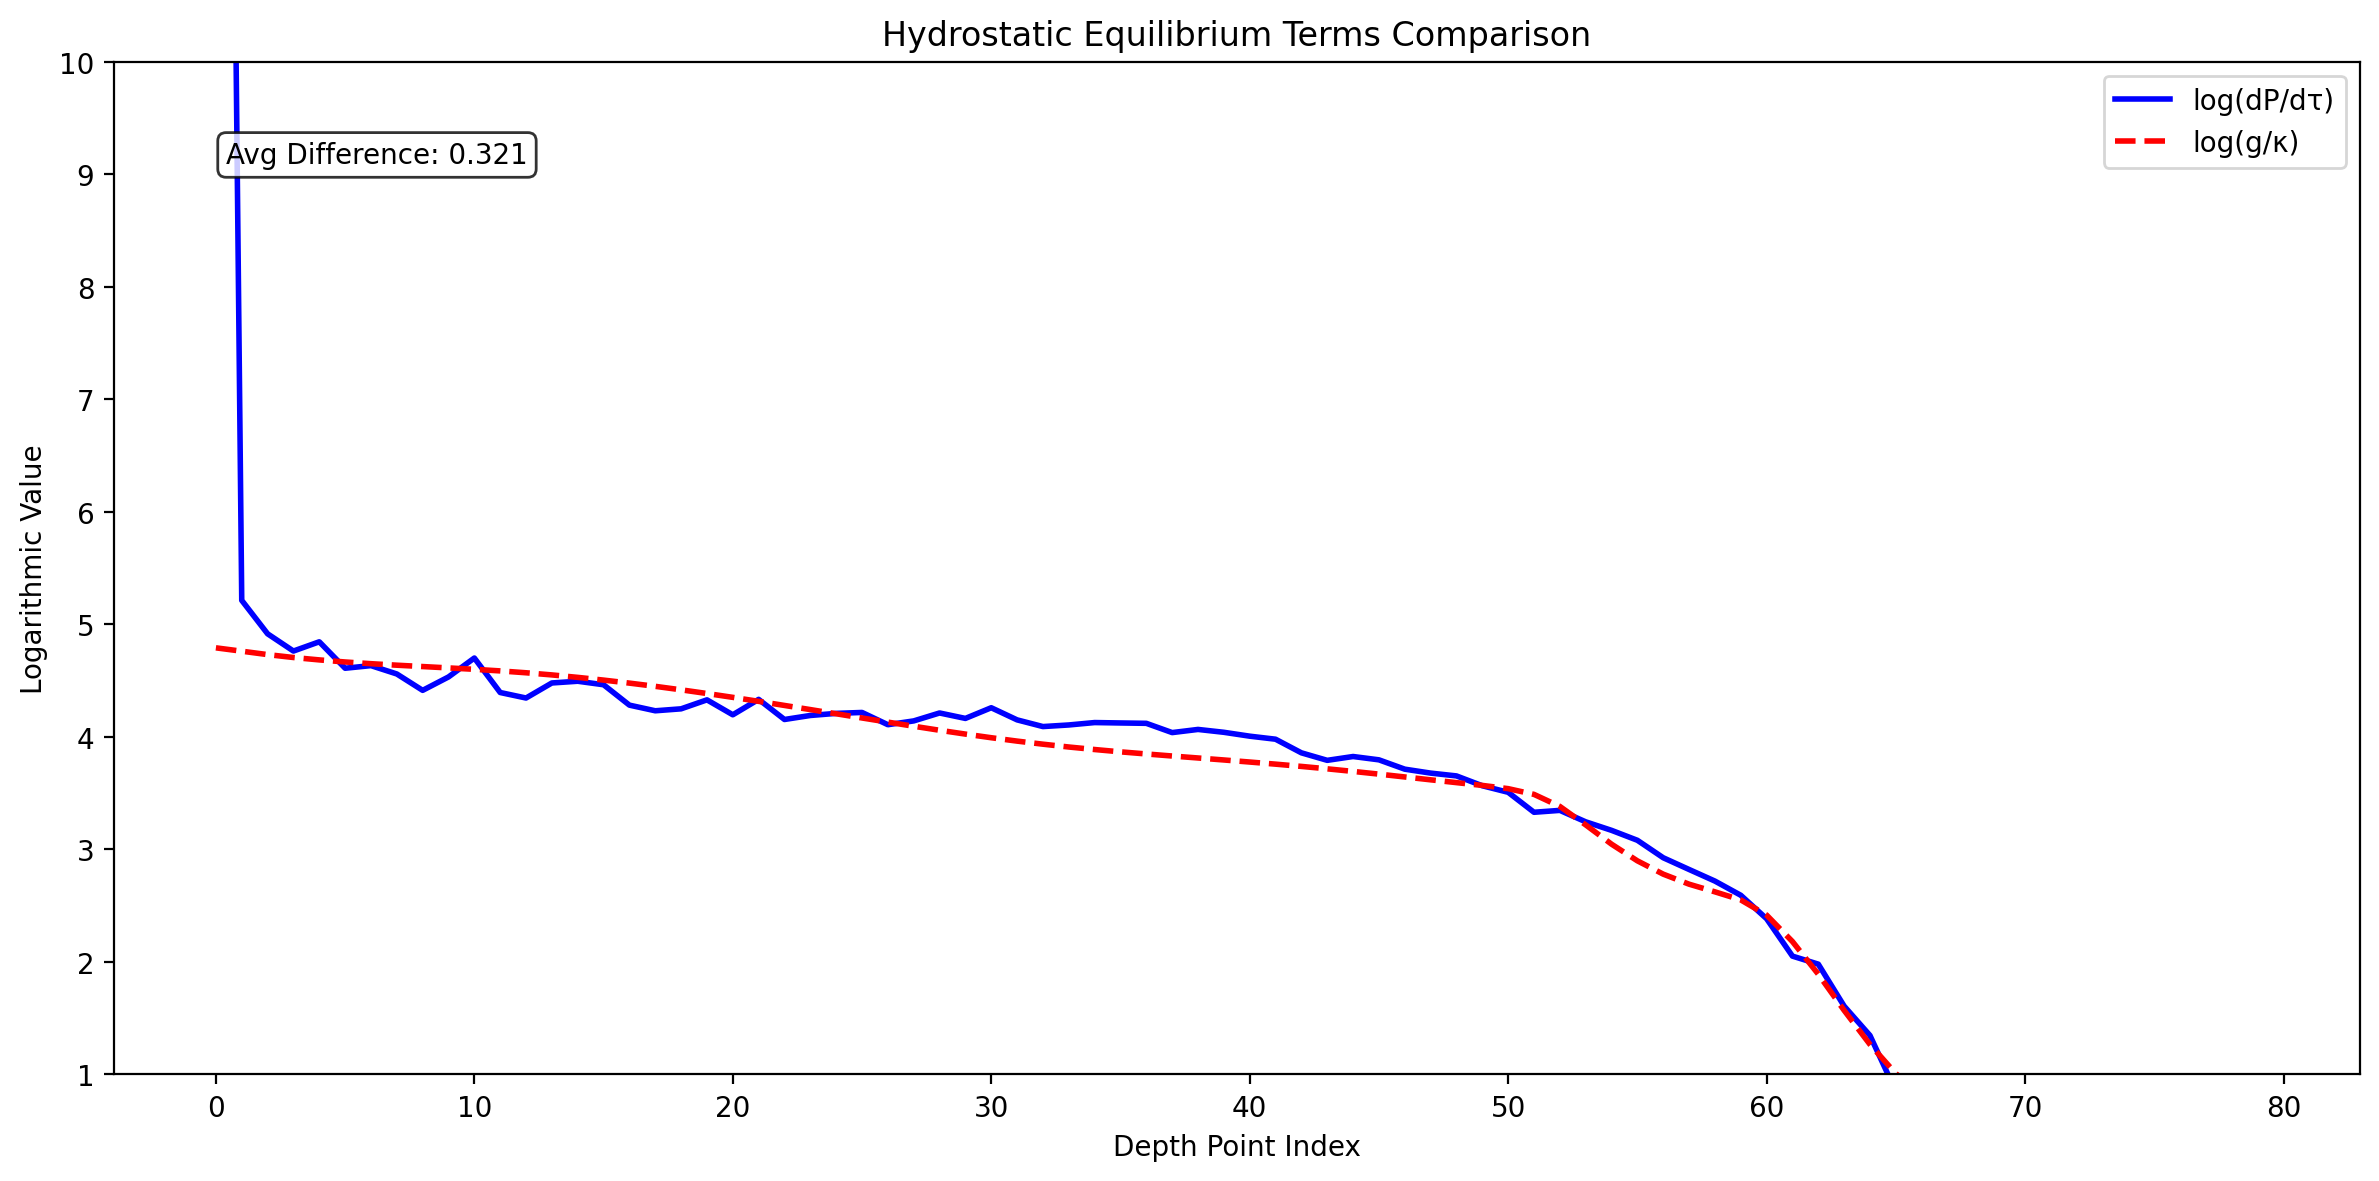

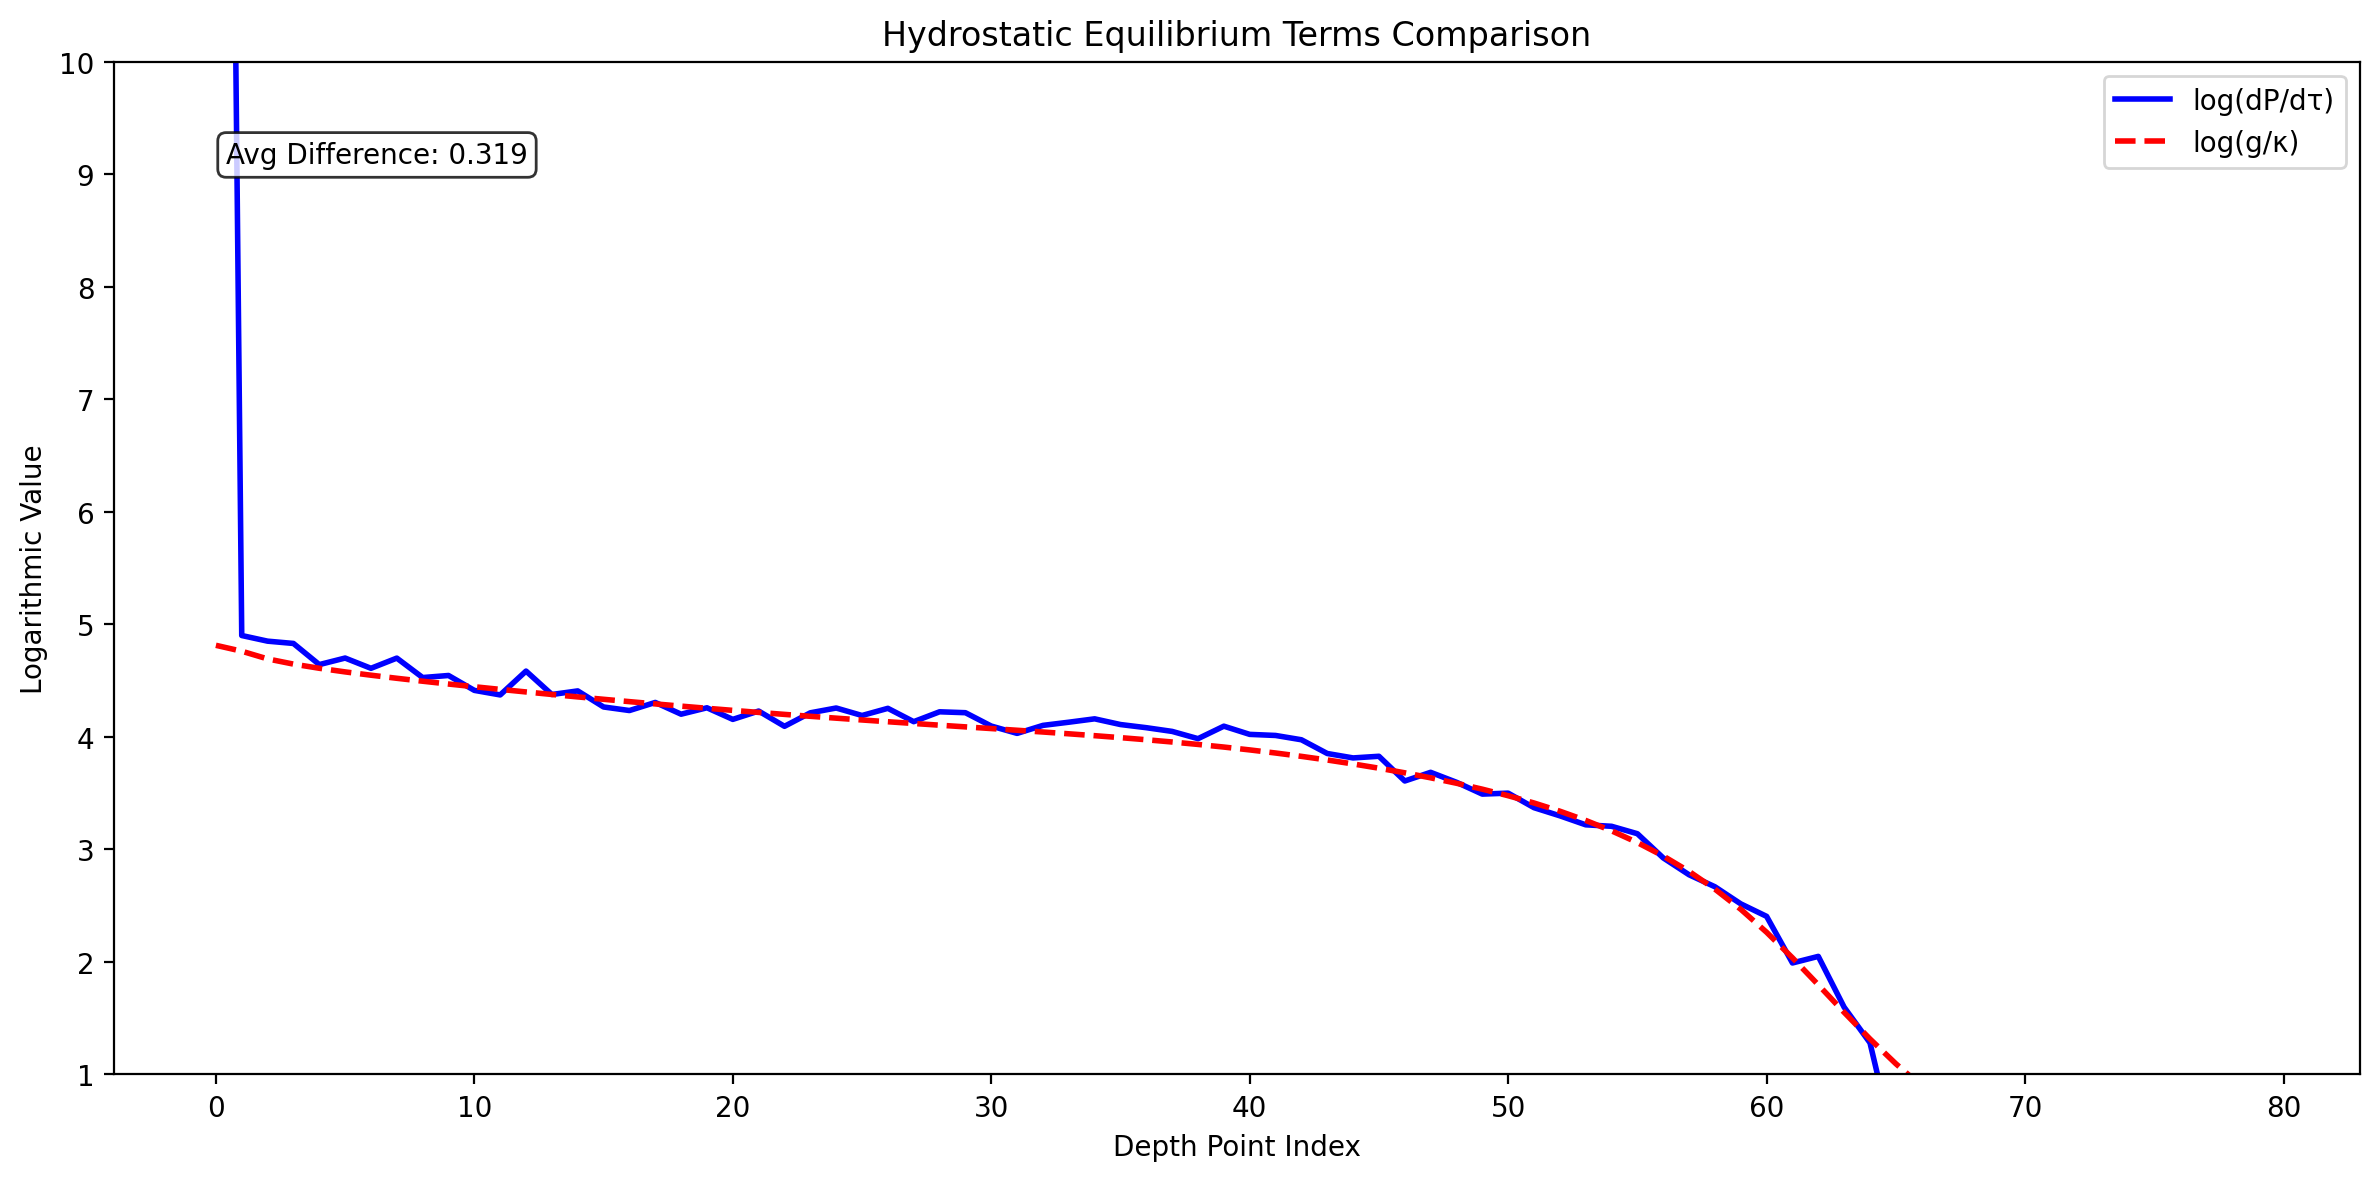

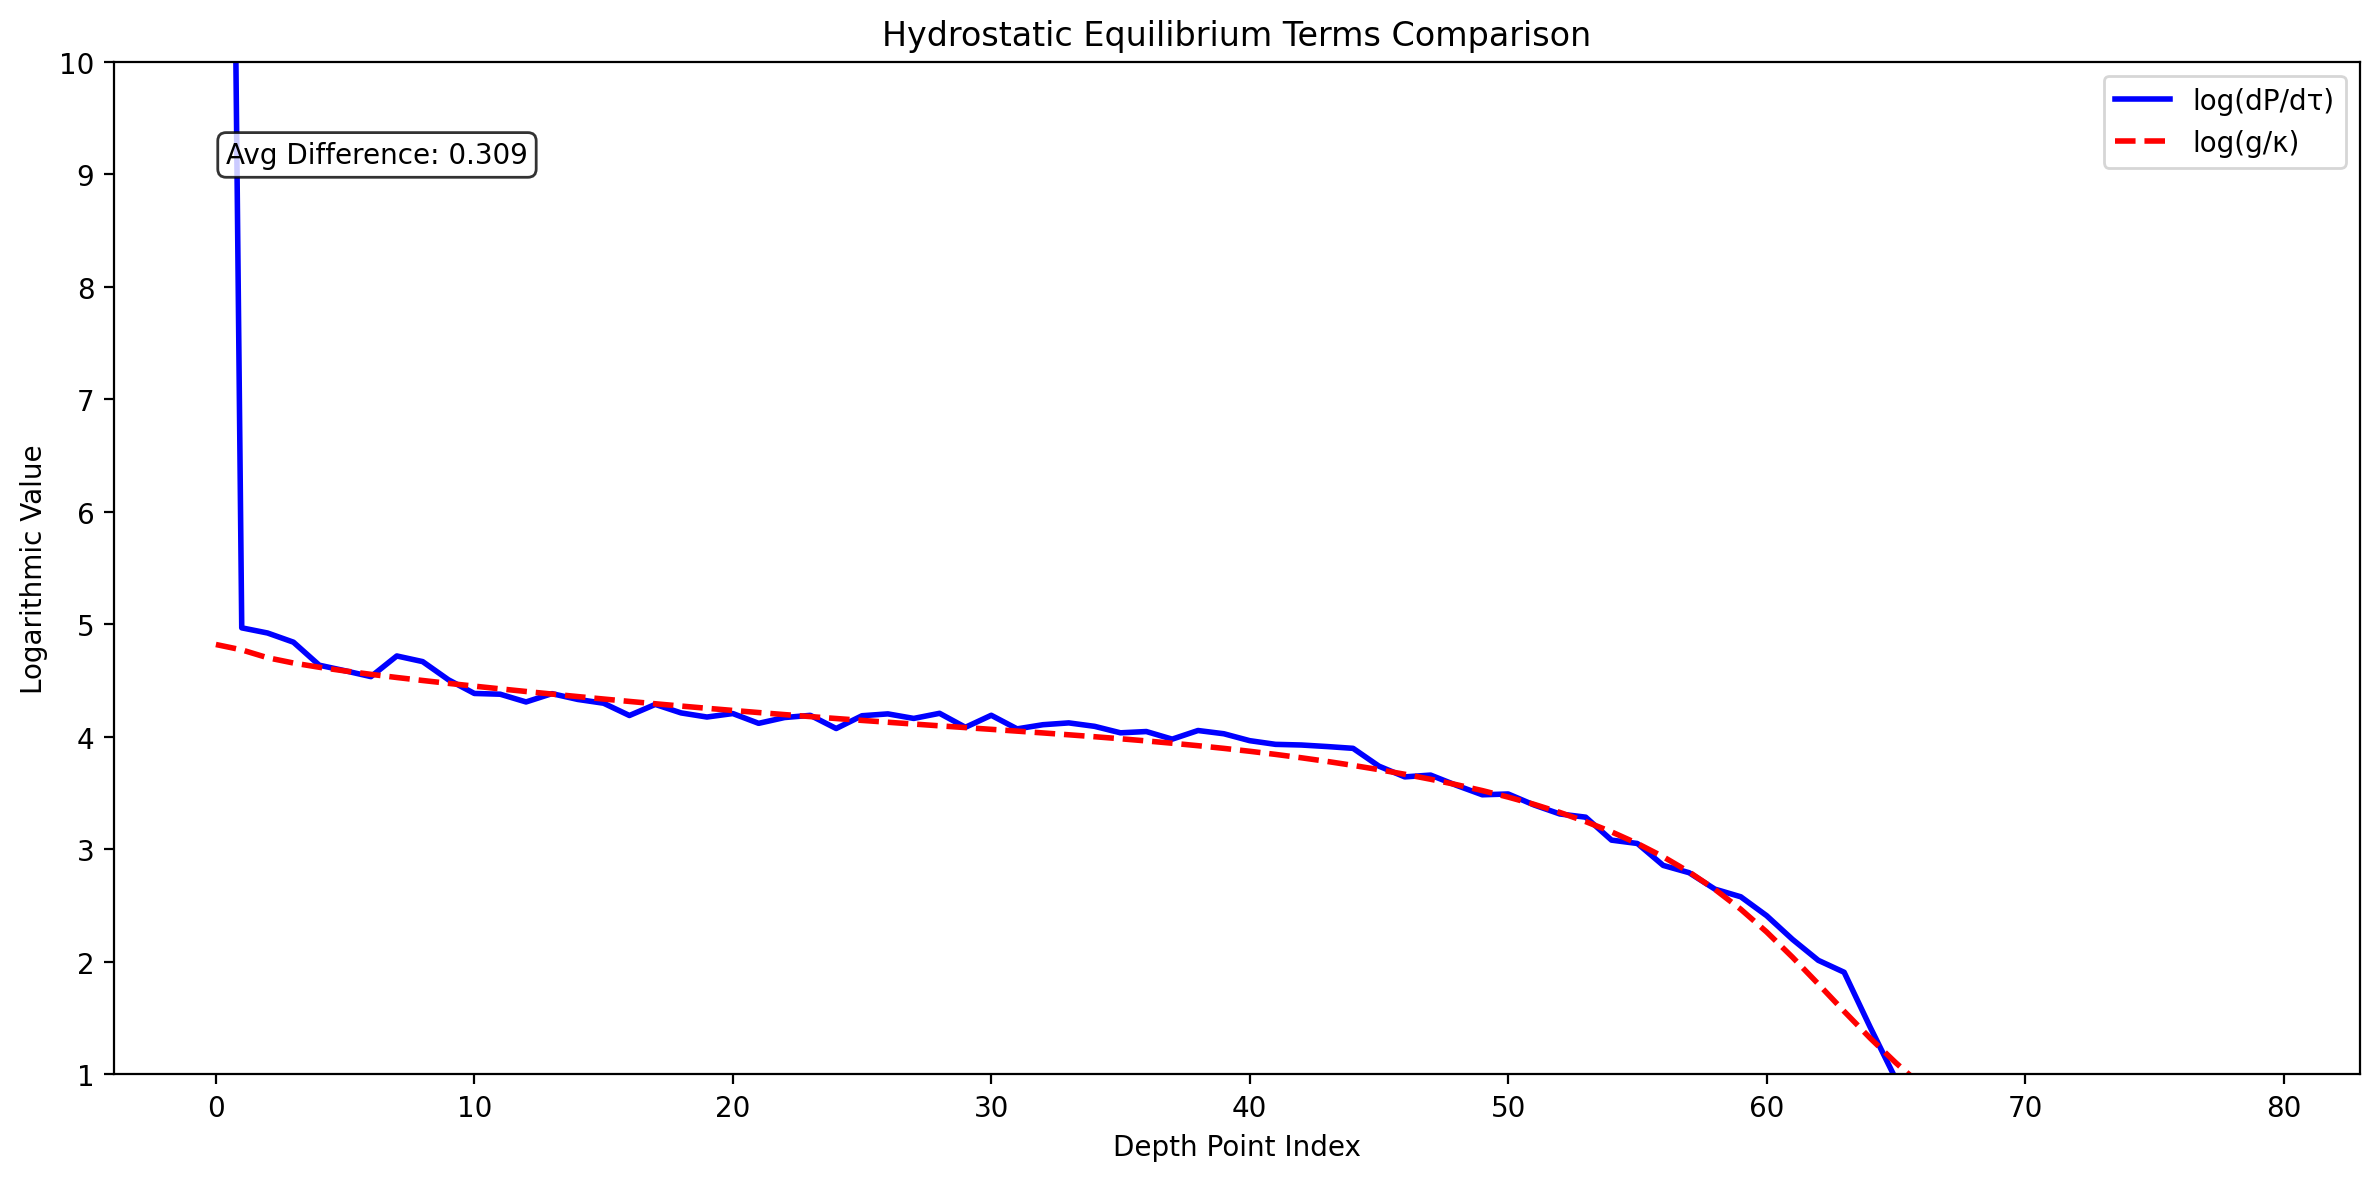

In [67]:
idx = 6
plot_hydro_terms(log_deriv_true, log_rhs_true, sample_idx=idx)  # 绘制第一个样本
plot_hydro_terms(log_deriv, log_rhs, sample_idx=idx)  # 绘制第一个样本
plot_hydro_terms(log_deriv_hydro, log_rhs_hydro, sample_idx=idx)  # 绘制第一个样本